In [1]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
import pickle
import glob
from scipy import interpolate
import os
from scipy.optimize import nnls
from scipy.linalg import lstsq
%matplotlib inline
# jupyters notebook Befehl zum direkten Anzeigen von Matplotlib Diagrammen
plt.rcParams['figure.figsize'] = (9, 6)
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25
colormap={0:'red',1:'green'}
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True 
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.major.size'] = plt.rcParams['ytick.major.size'] = 7
plt.rcParams['xtick.minor.size'] = plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.major.width'] = plt.rcParams['ytick.major.width'] = 1.6
plt.rcParams['font.size'] = 12

from spectres.spectral_resampling_numba import spectres_numba  as spectres

In [2]:

from  matplotlib import colormaps as cmaps
cm=cmaps['viridis']

This version of the dust model uses linear scale factors for every dust component instead of ratios that are summed up to 1



Here you have to set the path where the dust files are

In [3]:
dust_path='./'
dust_path='../dust_model/Q-curves/fitting-Qcurves/Newcurves/GRF/'

In [4]:
old_version=False
continuum_penalty=False
radial_version=True
#cosi=True

# Model

The next cell includes the model with all needed functions

In [93]:

def degree_to_cos(deg):
    return np.cos(np.pi/180*deg)
def temp_to_rad(rmin,t,q,tmax):
    return (t/tmax)**(1/q) *rmin 
def powerlaw_radius(rmin,r,q,tmax):
    return (r/rmin)**q *tmax 
def powerlaw_density_temp(tmax,tmin,t,sigma_tmin,sigma_tmax):
    return (t/tmax)**p *sigma_max 
def area(rmin,rmax):
    return np.pi*(rmax**2-rmin**2)


def generate_grid(R=1,lambda_0=1,lambda_n=1):
    del_loglam=np.log10(1.0+1.0/R)
    N=1+int(np.log10(lambda_n/lambda_0)/del_loglam)
    mwlsline=np.logspace(np.log10(lambda_0),np.log10(lambda_n),N)
    return mwlsline


def spline(lam,flux,new_lam):

    #interpolation on a double logarithmic scale
    s=interpolate.InterpolatedUnivariateSpline(np.log10(lam),np.log10(flux))
    interp=10**(s(np.log10(new_lam)))
#    return interp #returning the nex SED
    return interp #for visualisation
class complete_model:
    
    #initializing the model
    #this needs to be done ones, so that all variables are known
    def __init__(self):
        self.variables=None
        self.abundance_dict=None
        self.data_dict={}
        #self.plotting=plotting
        #self.timeit=timeit
        #self.printing=printing
        self.star_spec=[]
        
        self.xnew=[]
        self.nwav=0
        self.freq=[]
        
        self.compo_ar=[]
        self.scaleparas=[]
        
        #slab data
        self.slab_wave=[]
        self.slab_data={}
        self.slab_parameters={}
        self.slab_temp_steps=0
        
        self.saved_continuum=[]
        
        #running the model without the continuum
        self.slab_only_mode=False
        
        #constants
        self.h = 6.6262e-27
        self.c = 2.997925e+10
        self.kboltz = 1.38e-16
        self.rsun = 6.9634e10
        self.parsec = 3.0857e18
        self.au =1.496e13
        self.trans_flux=1e23
        self.msun=1.99847e33
        self.mjup=1.89813e30
        self.mearth=5.9722e27

        self.scaled_stellar_flux=[]
        self.rim_flux=[]
        self.midplane_flux=[]
        self.surface_flux_tot=[]
        self.surface_flux_individual={}
        self.surface_flux_individual_scaled={}
        self.tot_flux=[]
        self.emission_flux=[]
        self.emission_flux_individual={}
        self.emission_flux_individual_scaled={}
        
        self.run_tzones=False
          
        self.bb_array=[]
        self.interp_bbody=False
        self.bb_wave_grid=[]
        
        self.bb_temp_steps=0
        self.bb_min_temp=1
        self.bb_max_temp=1000
        self.bb_temp_list=[]
        
        self.rim_powerlaw=False
        self.cosi=False
        self.single_slab=False
        self.radial_version=radial_version
        
    def __str__(self):
        #defining the output that will be printed
        #do print(model) if you want to see it
        #it will show the variable and dust dict
        string='-----------------\n'
        for key in self.variables:
            string+= key +': '
            string+=str(self.variables[key])+'\n'
        string+='\n'
        string+='-----------------\n'
        string+='Used data:\n'
        if self.data_dict!={}:
            for key in self.data_dict:
                string+=key+'\n'
        else:
            string+='Not loaded\n'
        
        string+='-----------------\n'
        return string    
    
    # defining how a black body
    # and black body with a powerlaw are calculated
    def bbody(self,t,freq=[],from_array=False):
        # there are two options
        
        # not from array:
        # calculating the black body useing the formular
        
        # from array:
        # using the precalucated arrays of black body to interpolate
        
        if from_array:
            idx=np.argmin(np.abs(self.bb_temp_list-t))
            if self.bb_temp_list[idx]<=t:
                idx_low=idx
                idx_up=idx+1
            else:
                idx_low=idx-1
                idx_up=idx
            if idx_up>=len(self.bb_temp_list):
                freq=self.c*1e4/self.xnew
                return (2*self.h*(freq*freq*freq)/(self.c*self.c))*(1.0/((np.exp((self.h*freq/(self.kboltz*t))) - 1.0)))
    
            
            
            black_body=(self.bb_array[idx_up]-self.bb_array[idx_low])*(t-self.bb_temp_list[idx_low])/self.bb_temp_steps+self.bb_array[idx_low]
            if self.interp_bbody:
                return np.interp(self.xnew,self.bb_wave_grid,black_body)
            else:
                return black_body
        else:
            return (2*self.h*(freq*freq*freq)/(self.c*self.c))*(1.0/((np.exp((self.h*freq/(self.kboltz*t))) - 1.0)))

    def bbody_temp_powerlaw(self,t,exp):
        # calculating a black body aith t**exp factor
        # Replaced with precomputation -1 because of starting
        idx=np.argmin(np.abs(self.bb_temp_list-t))
        if self.bb_temp_list[idx]<=t:
            idx_low=idx
            idx_up=idx+1
        else:
            idx_low=idx-1
            idx_up=idx


        black_body=(self.bb_array[idx_up]-self.bb_array[idx_low])*(t-self.bb_temp_list[idx_low])/self.bb_temp_steps+self.bb_array[idx_low]
        bb_exp=black_body*(t**(exp))
        if self.interp_bbody:
            return np.interp(self.xnew,self.bb_wave_grid,bb_exp)
        else:
            return bb_exp




    
    def read_data(self,variables={},dust_species={},slab_dict={},R=0,wavelength_points=[],
                  bb_temp_steps=10,bb_min_temp=10,bb_max_temp=10000,
                  stellar_file ='./MCMAXspec-hae.in',dust_path=dust_path,
                  slab_folder='./LineData/', slab_only_mode=False,
                  slab_prefix='1_',save_binned_data=True,load_binned_data=True,
                  q_files=True,interp_bbody=False,debug=False):
        # loading all the data the model needs
        # wavlength_points: array with the wavlength points (in micron) at which the model is evaluated
        # if it's left empty a predefined grid is used
        # stellar_file: path of the stellar spectrum (if you want to use it)
        # dust_path: folder with the dust files (already set in the cell above)
        # interp_bbody: leave it to false 
        
        
        #running the model without the continuum?
        self.slab_only_mode=slab_only_mode
        self.variables=variables
        
        if not slab_only_mode:
            self.abundance_dict=dust_species

            if 'incl' in self.variables:
                self.cosi=True

            self.interp_bbody=interp_bbody
        if len(wavelength_points)==0:
            #not saving the same data over and over again
            save_binned_data=False
            load_binned_data=False
            if R!=0:
                new_slab_wave=generate_grid(R,lambda_0=4,lambda_n=30)[1:-1] #in future maybe as input if needed
                self.slab_wave=new_slab_wave

        else:
            '''
            This does not work yet since slab_wave is not defined then
            '''
            
            
            self.xnew=np.array(wavelength_points)
            self.slab_wave=self.xnew

 
        '''
        Loading all the slab data
        taking the slab wavlength points to evaluate the slab data
        loading the density and temperature data
        
        '''
        slab_list=list(slab_dict.keys())
        
        ex_prebin=False
        if load_binned_data:
            slab_bin_folders=glob.glob(f'{slab_folder}/binned_data/*')
            slab_bin_folders.sort()
            print('Folder to be searched for pre-binned data:')
            print(slab_bin_folders)

            for folder in slab_bin_folders:
                ex_prebin=os.path.isfile(folder+'/wavelength.npy')
                print('Searching:')
                print(folder+'/wavelength.npy')
                print(ex_prebin)
                if ex_prebin:
                    wave_folder=np.load(folder+'/wavelength.npy')
                    if np.array_equal(self.xnew,wave_folder):
                        print('-----------------------------')
                        print('Found pre-binned data folder!')
                        print(folder)
                        print('-----------------------------')
                        save_slab_string=folder

                        break
            if not ex_prebin:
                print('-----------------------------')
                print('Found no pre-binned data folder!')
                if save_binned_data:
                    for i in range(100):
                        if not os.path.exists(f'{slab_folder}/binned_data/{str(i)}'):
                            print('Saving data in',f'{slab_folder}/binned_data/{str(i)}')
                            os.system(f'mkdir {slab_folder}/binned_data/{str(i)}')
                            np.save(f'{slab_folder}/binned_data/{str(i)}/wavelength',self.xnew)
                            save_slab_string=f'{slab_folder}/binned_data/{str(i)}'
                            break
                print('-----------------------------')
                
        for mol_name_init in slab_list:
            if '_comp' in mol_name_init:
                idx_comp=mol_name_init.find('_comp')
                mol_name=mol_name_init[:idx_comp]
                print(mol_name_init)
                print('is changed to')
                print(mol_name)
                
            else:
                mol_name=mol_name_init
            
            ex_mol=False
            if ex_prebin:
                ex_mol=os.path.isfile(f'{folder}/{slab_prefix}{mol_name}_convFlux.npy')
                if ex_mol:
                    print('Found data for',mol_name)
                    self.slab_data[mol_name_init]=np.load(f'{folder}/{slab_prefix}{mol_name}_convFlux.npy')
                
            if not ex_mol:
                if load_binned_data and ex_prebin:
                    print('No data found for',mol_name)
                slab_data_loaded=np.load(f'{slab_folder}{slab_prefix}{mol_name}_convFlux.npy')
                slab_wave=np.load(f'{slab_folder}{slab_prefix}{mol_name}_convWave.npy')

                if R==0 and len(wavelength_points)==0:
                    conti=False
                    if len(self.slab_wave)==0:
                        conti=True
                    if not conti:
                        for i in range(len(self.slab_wave)):
                            if self.slab_wave[i]!=slab_wave[i]:
                                conti=True
                                break
                    if conti:
                        print('Updateing Slab wave')
                        self.slab_wave=slab_wave

                    self.slab_data[mol_name_init]=slab_data_loaded
                else:
                    print('------------------')
                    print(f'Binning {mol_name}')
                    print('------------------')
                    slab_data_filled=np.zeros((np.shape(slab_data_loaded)[0],np.shape(slab_data_loaded)[1],len(self.slab_wave)))
                    count=0
                    for idx1 in range(np.shape(slab_data_loaded)[0]):
                        for idx2 in range(np.shape(slab_data_loaded)[1]):

                            slab_data_filled[idx1,idx2]= spectres(new_wavs=self.slab_wave, spec_wavs=np.flip(slab_wave),
                                                                  spec_fluxes=np.flip(slab_data_loaded[idx1,idx2]),fill=0.0,verbose=False)
                            if count%20==0:
                                print(f'{np.round(count/(np.shape(slab_data_loaded)[0]*np.shape(slab_data_loaded)[1])*100,1)} %',end='\r',flush=True)
                            count+=1
                            
                    self.slab_data[mol_name_init]=slab_data_filled    
                    if save_binned_data:
                        print('Saving:',mol_name,f'{save_slab_string}/{slab_prefix}{mol_name}_convFlux.npy')
                        np.save(f'{save_slab_string}/{slab_prefix}{mol_name}_convFlux',slab_data_filled)
                    print('                      ')
                    print('Done')
            else:
                print('Checking for molecular data')
        self.slab_parameters['col']=np.load(f'{slab_folder}{slab_prefix}parameter_col.npy')
        self.slab_parameters['temp']=np.load(f'{slab_folder}{slab_prefix}parameter_temp.npy')
        
        self.slab_temp_steps=self.slab_parameters['temp'][-1]-self.slab_parameters['temp'][-2]
        if not slab_only_mode:
            if len(wavelength_points)==0:
                #setting up the wavlength grid at which we calculate the model
                x1short = np.linspace(0.2,4,1000,endpoint='false')
                x1long = np.linspace(30,67.0,1000,endpoint='false')
                x2 = np.linspace(67.0,73.0,300,endpoint='false')
                x3= np.linspace(73.0,200.,500,endpoint='false')
                x4 = np.append(x1short,self.slab_wave)
                x5 = np.append(x4,x1long)
                x6 = np.append(x5,x2)
                self.xnew = np.sort(np.unique(np.append(x6,x3)))
        else:
            if len(wavelength_points)==0:
                self.xnew = self.slab_wave
        
        self.nwav = len(self.xnew)

        #converting it to frequencies
        self.freq = np.array((self.c*1e4)/(self.xnew))
        
        
        # pasting the slab data at the indices that corrispond to the slab wavelength
        # in the total grid         
        if not slab_only_mode:
            if len(wavelength_points)==0:
                #determining the indecies
                idx_slab=[]
                for idx_1 in range(len(self.slab_wave)):
                    idx_slab.append(np.where(self.xnew==self.slab_wave[idx_1])[0][0])
                # pasting the data at the right places
                for mol_name in slab_list:
                        mol_data=self.slab_data[mol_name].copy()
                        mol_data_all=np.zeros((np.shape(mol_data)[0],np.shape(mol_data)[1],self.nwav))
                        mol_data_all[:,:,np.array(idx_slab)]=mol_data
                        self.slab_data[mol_name]=mol_data_all
      

    
            

              
        if not slab_only_mode:

            # loading all dust species
            # they are linearly interpolated to the wavlength grid
            # they are saved in a dictonary (self.data_dict) under the name of the specie
            for key in self.abundance_dict:
                if debug: print('Load '+key+'...')
                if '/' in key:
                    print('Make sure not to mix up dust species from different opacity mechanisms!!')
                    print(key)

                if q_files:
                    wavelength,kabs = np.loadtxt(dust_path+key,skiprows=1,usecols=(0,1),unpack=True)  

                else:
                    wavelength,kabs = np.loadtxt(dust_path+key, comments="#", skiprows=0,
                                                          usecols=(0,1), unpack=True) 
                if debug:
                    print('wavelength min max',np.min(wavelength),np.max(wavelength))
                    print('absorbtion min max',np.min(kabs),np.max(kabs))

                # IS IT OKAY TO LIMIT IT T POSITIVE NUMBER??!?!?!?!
                kabs=np.clip(kabs,a_min=0.0,a_max=None)
                self.data_dict[key]=interpolate.interp1d(wavelength,kabs,kind='linear',bounds_error=False,fill_value=0.0)(self.xnew)
                if debug:
                    print('interp')
                    print('absorbtion min max',np.min(self.data_dict[key]),np.max(self.data_dict[key]))

            # loading the stellar spectrum if we don't assume a black body
            # we interplate it again linearly to the wavelength grid
            if not self.variables['bb_star']:
                wavestar,fluxstar = np.loadtxt(stellar_file, comments="#", skiprows=0,
                                                   usecols=(0,1), unpack=True)
                self.starspec = interpolate.interp1d(wavestar,fluxstar,kind='linear')(self.xnew)


            # in case we want to use tzones
            # we add tmin_s and t_max to the list of tzones
            # if they weren't there already
            # saveing the output as the new tzones

            # if no tzones are defined the minimum and maximum temperature are used 
            if 'tzones' in self.variables:
                self.run_tzones=True
                add=0
                if self.variables['tmin_s'] not in self.variables['tzones']:
                    add+=1
                    min_add=True
                if self.variables['tmax_s'] not in self.variables['tzones']:
                    add+=1
                    max_add=True
                if add!=0:
                    t_all=np.zeros(len(self.variables['tzones'])+add)
                    if min_add:
                        t_all[0]=self.variables['tmin_s']
                    if max_add:
                        t_all[-1]=self.variables['tmax_s']
                    if add==2:
                        t_all[1:-1]=self.variables['tzones']
                    else:
                        if max_add:
                            t_all[:-1]=self.variables['tzones']
                        else:
                            t_all[1:]=self.variables['tzones']
                else:
                    t_all=self.variables['tzones']
                self.variables['tzones']=np.sort(t_all)    


            #check if rim is a powerlaw or a single temperature
            if 't_rim' in self.variables:
                self.rim_powerlaw=False
            else:
                self.rim_powerlaw=True
                #this of course means you need to set
                # all other relevant variables
                list_rim=['tmax_rim','tmin_rim','q_rim']
                for var in list_rim:
                    if var not in self.variables:
                        print('-------')
                        print('There are not all parameters for the inner rim set!!!')
                        print(f'{var} is not defined')
                        print('-------')


            #precalculating black bodys for temperature grid

            print('Precalculating Black bodies')
            self.bb_temp_steps=bb_temp_steps
            self.bb_min_temp=bb_min_temp
            self.bb_max_temp=bb_max_temp
            t_min_bb=1 #minimum temperature
            t_max_bb=10000 # maximum temperature
            if self.interp_bbody:
                bb_wave_grid=np.logspace(np.log10(np.min(self.xnew)),np.log10(np.max(self.xnew)),num=1000)
            else:
                bb_wave_grid=self.xnew
            self.bb_wave_grid=bb_wave_grid
            bb_freq_grid= np.array((self.c*1e4)/(bb_wave_grid))
            num_temp_bb=int((self.bb_max_temp-self.bb_min_temp)/self.bb_temp_steps+1)
            self.bb_array=np.zeros((num_temp_bb,len(bb_freq_grid)))
            i=0
            self.bb_temp_list=[]
            for temp in range(self.bb_min_temp,self.bb_max_temp+self.bb_temp_steps,self.bb_temp_steps):
                if debug:
                    print(temp)
                self.bb_array[i]=self.bbody(t=temp,freq=bb_freq_grid,from_array=False)
                self.bb_temp_list.append(temp)
                i+=1
                if i%100==0:                
                    print(f'{np.round(i/num_temp_bb*100)}%',end='\r',flush=True)
            self.bb_temp_list=np.array(self.bb_temp_list)



    def set_midplane(self,use_as_inner_rim=False,new_midplane=True,timeit=False,small_window=False,debug=False):
        if timeit: time1=time()
        # choosing if the function uses the midplane of rim variables
        # both are using a temperature powerlaw and can be decribed by the same functions
        if not use_as_inner_rim:
            tmin_mp=self.variables["tmin_mp"] #minimum temperature midplane
            tmax_mp=self.variables["tmax_mp"] #maximum temperature midplane
            exp=self.variables['exp_midplane']
        else:
            tmin_mp=self.variables["tmin_rim"] #minimum temperature rim
            tmax_mp=self.variables["tmax_rim"] #maximum temperature rim
            exp=self.variables['exp_rim']
        
        
        if new_midplane:
            '''
            New implementation that is (hopefully) faster
            This implementation makes use of the precomputed black bodies.
            The idea:
                - selecting all black bodies within the temperature ranges
                - multiplying them with the temperature powerlaw
                - using the grid points in and outside of tmin_mp and tmax_mp
                  to calculate the Black bodies at tmin_mp and tmax_mp
                - multiplying these BBs with the temperature power law
                - summing up (times width of relevant temperature range) all
                  the components to have the integral over the full temperature range
                - the relevant ranges are for the inside points 1K
                - for the gridpoint inside the edges it 1/2 (pointing in from the temperature range)
                - the gridpoint inside the edges and the edge are equally contributing
                  to the area between them
                - This method reproduces the results of np.tapz with the gridpoints and tmax_mp and tmin_mp as points
                - If the upper and lower temperature limits are very close
                  more points are inserted and np.trapz used to solve the problem
                - This method needs to have 3 points inside the temperature range
                  therefore I added another version that jumps in if this is not the case 
                  (In future we can make this also more efficient)
            '''
            
            idx_min=np.argmin(np.abs(self.bb_temp_list-tmin_mp))
            if self.bb_temp_list[idx_min]<=tmin_mp:
                idx_tmin_mp=idx_min
            else:
                idx_tmin_mp=idx_min-1
            idx_max=np.argmin(np.abs(self.bb_temp_list-tmax_mp))
            if self.bb_temp_list[idx_max]<=tmax_mp:
                idx_tmax_mp=idx_max
            else:
                idx_tmax_mp=idx_max-1


            tmin_below=self.bb_temp_list[idx_tmin_mp]
            tmax_below=self.bb_temp_list[idx_tmax_mp]
            
            if debug:
                print('=====================')
                print('Midplane')
                print('=====================')
                print('Idx_min, t_min',idx_tmin_mp,tmin_below)
                print('Idx_max, t_max',idx_tmax_mp,tmax_below)
            
            if (idx_tmax_mp-idx_tmin_mp)<3:
                small_window==True
            if small_window:
                

                num_points=10

                #creating points on every gridpoint (or finer grid) in the temperature range and adding the limits to it
                ar_temp_mid=list(np.linspace(tmin_mp,tmax_mp,num_points))
                #ar_temp_mid.insert(0,tmin_mp)
                #ar_temp_mid.insert(len(ar_temp_mid),tmax_mp)
                ar_temp_mid=np.array(ar_temp_mid)
                
                #calculating the fluxes for every temperature
                fluxes=[]
                for t in ar_temp_mid:

                    fluxes.append(self.bbody(t,self.freq,from_array=True)*t**exp)
                fluxes=np.array(fluxes)
                # using a numpy function for the integration
                flux_midplane=np.trapz(fluxes,ar_temp_mid,axis=0)


            else:

                if timeit: time2=time()
                # bbs of all grid points in the temperature range excluding the outer two points
                bb_points_mp=self.bb_array[idx_tmin_mp+2:idx_tmax_mp].copy()

                if timeit: time3=time()

                # calculating the corisponding temperature**exp values
                bb_temps_mp=np.arange(tmin_below+2*self.bb_temp_steps,tmax_below,self.bb_temp_steps)**exp

                if timeit: time4=time()
                if debug:
                    print('Shapes must match',np.shape(bb_points_mp),np.shape(bb_temps_mp))
                #multiplying the BBs with the temperature powerlaws
                for i in range(len(bb_temps_mp)):
                    bb_points_mp[i]*=bb_temps_mp[i]

                if timeit: time5=time()

                # these are gridpoints that are still within the temperature range
                upper_bb_in=self.bb_array[idx_tmax_mp]
                lower_bb_in=self.bb_array[idx_tmin_mp+1]
                
                # they are outside of them
                upper_bb_out=self.bb_array[idx_tmax_mp+1]
                lower_bb_out=self.bb_array[idx_tmin_mp]
                
                
                #these are the BBs* temp**exp for the two edges (tmax and tmin)
                upper_edge=(upper_bb_in+(upper_bb_out-upper_bb_in)*(tmax_mp-tmax_below)/self.bb_temp_steps)*(tmax_mp)**exp
                lower_edge=(lower_bb_out+(lower_bb_in-lower_bb_out)*(tmin_mp-tmin_below)/self.bb_temp_steps)*(tmin_mp)**exp
                if debug:
                    print('Upper edge',np.sum(upper_edge))
                    print('Lower edge',np.sum(lower_edge))
                #these are the BBs just inside times temp**exp
                upper_bb_in_exp=self.bb_array[idx_tmax_mp]*(tmax_below)**exp
                lower_bb_in_exp=self.bb_array[idx_tmin_mp+1]*(tmin_below+self.bb_temp_steps)**exp
                if debug:
                    print('Upper bb in',np.sum(upper_bb_in_exp))
                    print('Lower bb in',np.sum(lower_bb_in_exp))

                
                #these are the number of grid points (not used anymore)
                num_points=int(tmax_mp)-int(tmin_mp)+1

                if timeit: time6=time()
                
                #all inner points have a temperature range of self.bb_temp_steps K
                inner_part=np.sum(bb_points_mp,axis=0)*self.bb_temp_steps
                #the two grid points inside have a weight of 1/2 from their value inside
                lower_in=lower_bb_in_exp*1/2*self.bb_temp_steps
                upper_in=upper_bb_in_exp*1/2*self.bb_temp_steps

                
                #these are the components between the last gridpoints and the limits
                lower_out=(lower_edge+lower_bb_in_exp)*(tmin_below+self.bb_temp_steps-tmin_mp)/2
                upper_out=(upper_bb_in_exp+upper_edge)*(tmax_mp-tmax_below)/2



                #summing eveything up
                flux_midplane=inner_part+lower_in+upper_in+upper_out+lower_out

                if timeit: 
                                time7=time()
                                print('--------------')
                                print('Midpplane time')
                                print('Init',time2-time1)
                                print('Call array',time3-time2)
                                print('BB times exp',time4-time3)
                                print('Multiplying',time5-time4)
                                print('First and last point',time6-time5)
                                print('Summing up',time7-time6)

                                print('--------------')


        else:
            #this is an old implementation that we only have for comparison
            #it shouldn't be used in multinest
            num_points=int((tmax_mp-tmin_mp))+1
            if num_points<10:
                num_points=10
            ar_temp_mid=np.linspace(tmin_mp+self.bb_temp_steps,tmax_mp,num_points,endpoint='False')
            flux_mid=np.zeros((num_points,len(self.xnew)))
            i=0
            for t in ar_temp_mid:
                if i==0 or i==len(ar_temp_mid)-1:
                    flux_mid[i]=self.bbody_temp_powerlaw(t,exp)*(tmax_mp-tmin_mp)/(num_points-1)/2*self.bb_temp_steps
                else:
                    flux_mid[i]=self.bbody_temp_powerlaw(t,exp)*(tmax_mp-tmin_mp)/(num_points-1)*self.bb_temp_steps
                i+=1
            flux_midplane=np.sum(flux_mid,axis=0)
            
        return flux_midplane



    def set_surface(self,one_output=False,new_surface=True,small_window=False,timeit=False):

        '''
        The surface is in general:
        A black body temperature powerlaw multiplyed by the dust opacity times dust abundance 

        New implementation that is faster
        This implementation makes use of the precomputed black bodies.
        The idea is the same as for the midplane.
        Additionally, the result is multiplyed by the dust opacity times abundance.
        Note that also the older version is a debugged version of the previous iteration.
        '''

        tmin,tmax=self.variables['tmin_s'],self.variables['tmax_s']
        if timeit: time1=time()
        if new_surface:
            idx_min=np.argmin(np.abs(self.bb_temp_list-tmin))
            if self.bb_temp_list[idx_min]<=tmin:
                idx_tmin=idx_min
            else:
                idx_tmin=idx_min-1
            idx_max=np.argmin(np.abs(self.bb_temp_list-tmax))
            if self.bb_temp_list[idx_max]<=tmax:
                idx_tmax=idx_max
            else:
                idx_tmax=idx_max-1


            tmin_below=self.bb_temp_list[idx_tmin]
            tmax_below=self.bb_temp_list[idx_tmax]

            if (int(tmax)-int(tmin))<3:
                small_window==True
            if small_window:

                num_points=int(tmax)-int(tmin)
                if num_points<10:
                    num_points=10

                    
                    
                ar_temp=list(np.linspace(tmin,tmax,num_points))
                #ar_temp.insert(0,tmin)
                #ar_temp.insert(len(ar_temp),tmax)
                ar_temp=np.array(ar_temp)
                fluxes=[]
                for t in ar_temp:

                    fluxes.append(self.bbody(t,self.freq,from_array=True)*t**self.variables['exp_surface'])
                fluxes=np.array(fluxes)
                tot_bb_exp=np.trapz(fluxes,ar_temp,axis=0)
                dust_abs=np.zeros_like(tot_bb_exp)

                for key in self.abundance_dict:
                    if one_output:
                        dust_abs+=self.abundance_dict[key]*self.data_dict[key] 
                    else:
                        self.surface_flux_individual[key]=self.data_dict[key]*tot_bb_exp
         
                if one_output:
                    flux_surface_tot=tot_bb_exp*dust_abs
                    return flux_surface_tot


            else:

                if timeit: time2=time()
                bb_points=self.bb_array[idx_tmin+2:idx_tmax].copy()

                if timeit: time3=time()


                bb_temps=np.arange(tmin_below+2*self.bb_temp_steps,tmax_below,self.bb_temp_steps)**self.variables['exp_surface']

                if timeit: time4=time()
                for i in range(len(bb_temps)):
                    bb_points[i]*=bb_temps[i]

                if timeit: time5=time()


                upper_bb_in=self.bb_array[idx_tmax]
                lower_bb_in=self.bb_array[idx_tmin+1]

                upper_bb_out=self.bb_array[idx_tmax+1]
                lower_bb_out=self.bb_array[idx_tmin]

                upper_edge=(upper_bb_in+(upper_bb_out-upper_bb_in)*(tmax-tmax_below)/self.bb_temp_steps)*(tmax)**self.variables['exp_surface']
                lower_edge=(lower_bb_out+(lower_bb_in-lower_bb_out)*(tmin-tmin_below)/self.bb_temp_steps)*(tmin)**self.variables['exp_surface']



                upper_bb_in_exp=self.bb_array[idx_tmax]*(tmax_below)**self.variables['exp_surface']
                lower_bb_in_exp=self.bb_array[idx_tmin+1]*(tmin_below+self.bb_temp_steps)**self.variables['exp_surface']



                num_points=int(tmax)-int(tmin)+1

                if timeit: time6=time()

                inner_part=np.sum(bb_points,axis=0)*self.bb_temp_steps
                lower_in=lower_bb_in_exp*1/2*self.bb_temp_steps
                upper_in=upper_bb_in_exp*1/2*self.bb_temp_steps

                lower_out=(lower_edge+lower_bb_in_exp)*(tmin_below+self.bb_temp_steps-tmin)/2
                upper_out=(upper_bb_in_exp+upper_edge)*(tmax-tmax_below)/2


                if timeit: time7=time()
                #print(inner_part)
                tot_bb_exp=(inner_part+lower_in+upper_in+upper_out+lower_out).copy()
                dust_abs=np.zeros_like(tot_bb_exp)

                for key in self.abundance_dict:
                    if one_output:
                        dust_abs+=self.abundance_dict[key]*self.data_dict[key] 
                    else:
                        self.surface_flux_individual[key]=self.data_dict[key]*tot_bb_exp
         
                if one_output:
                    flux_surface_tot=tot_bb_exp*dust_abs
                    return flux_surface_tot

                if timeit: 
                                time8=time()
                                print('--------------')
                                print('Surface time')
                                print('Init',time2-time1)
                                print('Call array',time3-time2)
                                print('BB times exp',time4-time3)
                                print('Multiplying',time5-time4)
                                print('First and last point',time6-time5)
                                print('Multiplying with dust opacity',time7-time6)
                                print('Summing up',time8-time7)

                                print('--------------')

        else:


            if one_output:
                flux_surface_tot = np.zeros((self.nwav))

            num_points=int((tmax-tmin))+1
            if num_points<10:
                num_points=10
            ar_temp=np.linspace(tmin,tmax,num_points,endpoint='False')
            flux=np.zeros((num_points,len(self.xnew)))
            i=0
            for t in ar_temp:
                if i==0 or i==len(ar_temp)-1:
                    flux[i]=self.bbody_temp_powerlaw(t,self.variables['exp_surface'])*(tmax-tmin)/(num_points-1)/2
                else:
                    flux[i]=self.bbody_temp_powerlaw(t,self.variables['exp_surface'])*(tmax-tmin)/(num_points-1)
                i+=1
            flux_sur=np.sum(flux,axis=0)


            for key in self.abundance_dict:
                dust_abs=self.data_dict[key] 
                dust_flux=dust_abs*flux_sur
                self.surface_flux_individual[key]=dust_flux
                if one_output:
                    flux_surface_tot+=self.abundance_dict[key]*self.surface_flux_individual[key]
            if one_output:
                return flux_surface_tot

    def set_emission_lines(self,LTE=True,one_output=False,scaled=True,output_quantities=False,debug=False,
                           fast_norm=True,debug_interp=False):
        if output_quantities:
            output_dict={}
        if self.radial_version:
            exp=(2-self.variables['exp_emission'])/self.variables['exp_emission']

        else:
            exp=self.variables['exp_emission']

        idxs=[]
        temps=[]

        emission_flux=np.zeros(self.nwav)


        for specie in self.slab_dict:
            if output_quantities:
                output_dict[specie]={}
            if 'ColDens' in list(self.slab_dict[specie]):
                col_range=False
            else:
                col_range=True
            
            if debug:                
                print('--------------')
                print(f'Slab of {specie}')
            
            #if we have a single temperature (temis)
            if 'temis' in self.slab_dict[specie]:
                
                temis=self.slab_dict[specie]['temis']
                dens=self.slab_dict[specie]['ColDens']
                if scaled:
                    numerator= 1e23*np.pi*((self.slab_dict[specie]['radius']*self.au)**2)/((self.variables['distance']*self.parsec)**2)
                    if self.cosi:
                        scale = numerator*degree_to_cos(self.variables['incl'])
                    else:
                        scale = numerator

                else:
                    numerator= 1e23*np.pi*((self.au)**2)/((self.variables['distance']*self.parsec)**2)
                    if self.cosi:
                        scale = numerator*degree_to_cos(self.variables['incl'])
                    else:
                        scale = numerator

                if debug:
                    print('Single slab version')
                    print('Temp,coldens',temis,dens)

                #now interpolating the column densities on a linear scale
                species_flux=np.zeros_like(self.slab_data[specie][0])



                # Doing a 2D interpolation for the edges at tmin tmax, and coldens_tmin,coldens_tmax
                # first we are selecting the important edges

                # lower edge

                idx_dens=[]

                arg_dens=np.argmin(abs(self.slab_parameters['col']-dens))
                if self.slab_parameters['col'][arg_dens]<dens:
                    idx_dens.append(arg_dens)
                    idx_dens.append(arg_dens+1)
                else:
                    idx_dens.append(arg_dens-1)
                    idx_dens.append(arg_dens)
                dens_lower=self.slab_parameters['col'][idx_dens[0]]
                dens_upper=self.slab_parameters['col'][idx_dens[1]]
                idx_temp=[]
                arg_temp=np.argmin(abs(self.slab_parameters['temp']-temis))
                if self.slab_parameters['temp'][arg_temp]<temis:
                    idx_temp.append(arg_temp)
                    idx_temp.append(arg_temp+1)
                else:
                    idx_temp.append(arg_temp-1)
                    idx_temp.append(arg_temp)

                temp_lower=self.slab_parameters['temp'][idx_temp[0]]
                temp_upper=self.slab_parameters['temp'][idx_temp[1]]
                if debug:
                    print('temp_lower',temp_lower)
                    print('temp_upper',temp_upper)
                    print('dens_lower',dens_lower)
                    print('dens_upper',dens_upper)


                # saving the respective spectra left right means temp and up down coldens
                a= self.slab_data[specie][idx_dens[0]][idx_temp[0]] # lower left
                b= self.slab_data[specie][idx_dens[0]][idx_temp[1]] # lower right
                c= self.slab_data[specie][idx_dens[1]][idx_temp[0]] # upper left
                d= self.slab_data[specie][idx_dens[1]][idx_temp[1]] # upper right

                #calculating the interpolation factors

                # delta is deltax*deltay
                delta_temp=temp_upper-temp_lower
                delta_col=dens_upper-dens_lower
                delta=delta_col*delta_temp

                fact_a=(dens_upper-dens)*(temp_upper-temis)
                fact_b=(dens_upper-dens)*(temis-temp_lower)
                fact_c=(dens-dens_lower)*(temp_upper-temis)
                fact_d=(dens-dens_lower)*(temis-temp_lower)

                # summing everthing up

                flux_species=scale*(fact_a*a+fact_b*b+fact_c*c+fact_d*d)/delta

                if not scaled:
                    self.emission_flux_individual[specie]=flux_species
                else:
                    self.emission_flux_individual_scaled[specie]=flux_species

                emission_flux+=flux_species
                if debug:
                    print('--------------')
                    print()

            
            
            
            
            
            
            # if we have a temperature range
            else:
                t_min,t_max=self.slab_dict[specie]['tmin'],self.slab_dict[specie]['tmax']

                #determining the scale factor
                if self.radial_version:
                    if scaled:
                        denominator=((self.variables['distance']*self.parsec)**2)*self.variables['exp_emission']*t_max**(2/self.variables['exp_emission'])
                        numerator= -1e23*2*np.pi*((self.slab_dict[specie]['radius']*self.au)**2)
                        if self.cosi:
                            scale = numerator/denominator*degree_to_cos(self.variables['incl'])
                        else:
                            scale = numerator/denominator

                    else:
                        denominator=((self.variables['distance']*self.parsec)**2)*self.variables['exp_emission']*t_max**(2/self.variables['exp_emission'])
                        numerator= -1e23*2*np.pi*((self.au)**2)
                        if self.cosi:
                            scale = numerator/denominator*degree_to_cos(self.variables['incl'])
                        else:
                            scale = numerator/denominator

                else:
                    if scaled:
                        scale = 1e23*np.pi*((self.au*self.slab_dict[specie]['radius'])**2)/((self.variables['distance']*self.parsec)**2)
                    else:
                        scale = 1e23*np.pi*((self.au)**2)/((self.variables['distance']*self.parsec)**2)


                if col_range:
                    interp_edge_first=True
                    # defining a column density at T min and at Tmax
                    # a exponential function is then assumed between those points
                    # the data is then interpolated (log normal) to get the column densities as all grid points
                    # the flux is then determined by having a linear interpolation between the column density at the grid points


                    dens_min,dens_max=self.slab_dict[specie]['ColDens_tmin'],self.slab_dict[specie]['ColDens_tmax']


                    # creating the law
                    dens_min_log=np.log10(dens_min)
                    dens_max_log=np.log10(dens_max)
                    if self.radial_version:
                        t_max_log=np.log10(t_max)
                        t_min_log=np.log10(t_min)
                        slope=(dens_max_log-dens_min_log)/(t_max_log-t_min_log)
                        temp_logs=np.log10(self.slab_parameters['temp'])
                    else:
                        slope=(dens_max_log-dens_min_log)/(t_max-t_min)

                    respective_cols=np.zeros_like(self.slab_parameters['temp'],'float')
                    for t in range(len(self.slab_parameters['temp'])):
                        if debug:
                            if self.radial_version:
                                print(dens_min_log,(temp_logs[t]-t_min_log)*slope)

                            else:
                                print(dens_min_log,(self.slab_parameters['temp'][t]-t_min)*slope)
                        if self.slab_parameters['temp'][t]<=t_max and self.slab_parameters['temp'][t]>=t_min: #+1*self.slab_temp_steps -1*self.slab_temp_steps
                            if self.radial_version:
                                respective_cols[t]=float(dens_min_log+(temp_logs[t]-t_min_log)*slope)
                            else:
                                respective_cols[t]=float(dens_min_log+(self.slab_parameters['temp'][t]-t_min)*slope)

                    if debug: print('respective_cols',respective_cols)
                    cols_ar=10**respective_cols
                    if debug and max(respective_cols)>100:
                        print(dens_min_log)
                        print(dens_max_log)
                        print(t_min)
                        print(t_max)
                        print('Max respctive_cols',max(respective_cols))
                    #print('cols_ar',respective_cols)
                    if output_quantities:
                        output_dict[specie]['ColDens_tmin']=t_min
                        output_dict[specie]['ColDens_slope']=slope
                        output_dict[specie]['logColDens_min']=dens_min_log

                    if debug:
                        print('Slope',slope)
                        print('respective cols',respective_cols)
                        print('Cols ar',cols_ar)
                        plt.plot(self.slab_parameters['temp'],cols_ar)
                        plt.scatter([t_min,t_max],[dens_min,dens_max])
                        T_g_tot,NHtot_tot=np.meshgrid(self.slab_parameters['temp'],self.slab_parameters['col'])
                        plt.scatter(T_g_tot,NHtot_tot,marker='+')
                        plt.yscale('log')
                        if self.radial_version:
                            plt.xscale('log')

                        plt.xlabel('Temperature')
                        plt.ylabel('ColDens')
                        plt.title('Temperature Column density relation')
                        plt.show()

                    #now interpolating the column densities on a linear scale
                    species_flux=np.zeros_like(self.slab_data[specie][0])
                    for i in range(len(cols_ar)):
                        #getting the two closest point in the array
                        idx_col_list=[]
                        dens=cols_ar[i]

                        arg_min_dens=np.argmin(abs(self.slab_parameters['col']-dens))
                        if self.slab_parameters['col'][arg_min_dens]<dens:
                            idx_col_list.append(arg_min_dens)
                            idx_col_list.append(arg_min_dens+1)
                        else:
                            idx_col_list.append(arg_min_dens-1)
                            idx_col_list.append(arg_min_dens)
                        #if the col dens are outside the trained range it is disregarded. 
                        in_array=True
                        if idx_col_list[0]<0 or idx_col_list[1]>=len(self.slab_parameters['col']):
                            in_array=False
                        if in_array:
                            if debug:
                                print(i,idx_col_list)
                                print('Dens, dens in array',dens,self.slab_parameters['col'][idx_col_list])
                            species_flux[i]=self.slab_data[specie][idx_col_list[0]][i]+(self.slab_data[specie][idx_col_list[1]][i]-self.slab_data[specie][idx_col_list[0]][i])*(cols_ar[i]-self.slab_parameters['col'][idx_col_list[0]])/(self.slab_parameters['col'][idx_col_list[1]]-self.slab_parameters['col'][idx_col_list[0]])  
                        elif dens==self.slab_parameters['col'][0]:
                            species_flux[i]=self.slab_data[specie][0][i]
                        elif dens==self.slab_parameters['col'][-1]:
                            species_flux[i]=self.slab_data[specie][-1][i]


                    # Doing a 2D interpolation for the edges at tmin tmax, and coldens_tmin,coldens_tmax
                    # first we are selecting the important edges

                    # lower edge

                    idx_dens_min=[]

                    arg_min_dens=np.argmin(abs(self.slab_parameters['col']-dens_min))
                    if self.slab_parameters['col'][arg_min_dens]<dens_min:
                        idx_dens_min.append(arg_min_dens)
                        idx_dens_min.append(arg_min_dens+1)
                    else:
                        idx_dens_min.append(arg_min_dens-1)
                        idx_dens_min.append(arg_min_dens)
                    dens_lower=self.slab_parameters['col'][idx_dens_min[0]]
                    dens_upper=self.slab_parameters['col'][idx_dens_min[1]]
                    idx_temp_min=[]
                    arg_min_temp=np.argmin(abs(self.slab_parameters['temp']-t_min))
                    if self.slab_parameters['temp'][arg_min_temp]<t_min:
                        idx_temp_min.append(arg_min_temp)
                        idx_temp_min.append(arg_min_temp+1)
                    else:
                        idx_temp_min.append(arg_min_temp-1)
                        idx_temp_min.append(arg_min_temp)

                    temp_lower=self.slab_parameters['temp'][idx_temp_min[0]]
                    temp_upper=self.slab_parameters['temp'][idx_temp_min[1]]
                    if debug_interp:
                        print('temp_lower',temp_lower)
                        print('temp_upper',temp_upper)
                        print('dens_lower',dens_lower)
                        print('dens_upper',dens_upper)


                    # saving the respective spectra left right means temp and up down coldens
                    a= self.slab_data[specie][idx_dens_min[0]][idx_temp_min[0]] # lower left
                    b= self.slab_data[specie][idx_dens_min[0]][idx_temp_min[1]] # lower right
                    c= self.slab_data[specie][idx_dens_min[1]][idx_temp_min[0]] # upper left
                    d= self.slab_data[specie][idx_dens_min[1]][idx_temp_min[1]] # upper right

                    #calculating the interpolation factors

                    # delta is deltax*deltay
                    delta_temp=temp_upper-temp_lower
                    delta_col=dens_upper-dens_lower
                    delta=delta_col*delta_temp

                    fact_a=(dens_upper-dens_min)*(temp_upper-t_min)
                    fact_b=(dens_upper-dens_min)*(t_min-temp_lower)
                    fact_c=(dens_min-dens_lower)*(temp_upper-t_min)
                    fact_d=(dens_min-dens_lower)*(t_min-temp_lower)

                    # summing everthing up

                    lower_edge=(fact_a*a+fact_b*b+fact_c*c+fact_d*d)/delta * t_min**exp



                    if debug or debug_interp:
                        print('delta',delta)
                        print('fact_a',fact_a/delta)
                        print('fact_b',fact_b/delta)
                        print('fact_c',fact_c/delta)
                        print('fact_d',fact_d/delta)
                        print('lower edge mean',np.mean(lower_edge))

                    # upper edge

                    idx_dens_max=[]
                    arg_max_dens=np.argmin(abs(self.slab_parameters['col']-dens_max))
                    if self.slab_parameters['col'][arg_max_dens]<dens_max:
                        idx_dens_max.append(arg_max_dens)
                        idx_dens_max.append(arg_max_dens+1)
                    else:
                        idx_dens_max.append(arg_max_dens-1)
                        idx_dens_max.append(arg_max_dens)

                    dens_lower=self.slab_parameters['col'][idx_dens_max[0]]
                    dens_upper=self.slab_parameters['col'][idx_dens_max[1]]
                    idx_temp_max=[]
                    arg_max_temp=np.argmin(abs(self.slab_parameters['temp']-t_max))
                    if self.slab_parameters['temp'][arg_max_temp]<t_max:
                        idx_temp_max.append(arg_max_temp)
                        idx_temp_max.append(arg_max_temp+1)
                    else:
                        idx_temp_max.append(arg_max_temp-1)
                        idx_temp_max.append(arg_max_temp)


                    temp_lower=self.slab_parameters['temp'][idx_temp_max[0]]
                    temp_upper=self.slab_parameters['temp'][idx_temp_max[1]]

                    if debug_interp:
                        print('temp_lower',temp_lower)
                        print('temp_upper',temp_upper)
                        print('dens_lower',dens_lower)
                        print('dens_upper',dens_upper)

                    # saving the respective spectra left right means temp and up down coldens
                    a= self.slab_data[specie][idx_dens_max[0]][idx_temp_max[0]] # lower left
                    b= self.slab_data[specie][idx_dens_max[0]][idx_temp_max[1]] # lower right
                    c= self.slab_data[specie][idx_dens_max[1]][idx_temp_max[0]] # upper left
                    d= self.slab_data[specie][idx_dens_max[1]][idx_temp_max[1]] # upper right

                    #calculating the interpolation factors

                    # delta is deltax*deltay
                    delta_temp=temp_upper-temp_lower
                    delta_col=dens_upper-dens_lower
                    delta=delta_col*delta_temp

                    fact_a=(dens_upper-dens_max)*(temp_upper-t_max)
                    fact_b=(dens_upper-dens_max)*(t_max-temp_lower)
                    fact_c=(dens_max-dens_lower)*(temp_upper-t_max)
                    fact_d=(dens_max-dens_lower)*(t_max-temp_lower)

                    # summing everthing up

                    upper_edge=(fact_a*a+fact_b*b+fact_c*c+fact_d*d)/delta* t_max**exp

                    if debug or debug_interp:
                        print('delta',delta)
                        print('fact_a',fact_a/delta)
                        print('fact_b',fact_b/delta)
                        print('fact_c',fact_c/delta)
                        print('fact_d',fact_d/delta)
                        print('Upper edge mean',np.mean(upper_edge))

                    idx_col_list=[0]

                else:
                    interp_edge_first=False
                    #evaluating where in the grid the giving column density is stored
                    # if it isn't part of the array the two closest densities are interpolated
                    #checking which indices corrispond to the temperature range
                    # future improvement is a density gradient and relation between temperature and density

                    dens=self.slab_dict[specie]['ColDens']
                    if output_quantities:
                        output_dict[specie]['ColDens_tmin']=t_min
                        output_dict[specie]['ColDens_slope']=0.0
                        output_dict[specie]['logColDens_min']=np.log10(dens)
                    idx_col_list=[]
                    if dens in self.slab_parameters['col']:
                        idx_col=np.where(self.slab_parameters['col']==dens)[0][0]
                        idx_col_list.append(idx_col)
                    else:
                        arg_min_dens=np.argmin(abs(self.slab_parameters['col']-dens))
                        if self.slab_parameters['col'][arg_min_dens]<dens:
                            idx_col_list.append(arg_min_dens)
                            idx_col_list.append(arg_min_dens+1)
                        else:
                            idx_col_list.append(arg_min_dens-1)
                            idx_col_list.append(arg_min_dens)

                min_found=False
                max_found=False
                for idx_t in range(len(self.slab_parameters['temp'])):
                    if (self.slab_parameters['temp'][idx_t]>=t_min) and not min_found:
                        idx_tmin=idx_t
                        min_found=True
                    if (self.slab_parameters['temp'][idx_t]>t_max) and not max_found:
                        idx_tmax=idx_t-1
                        max_found=True
                        break
                if debug:
                    print('Temp range', t_min,t_max)
                    print('Temp inside range',self.slab_parameters['temp'][idx_tmin],self.slab_parameters['temp'][idx_tmax])
                #deciding if the small temperature range version needs to be used
                grid_p=True
                t_range=idx_tmax-idx_tmin
                if t_range>=2:
                    #full version
                    # this means that there is an inner part consisting atleast of one temperature 
                    range_version=0
                elif t_range==1:
                    #getting rid of inner part
                    range_version=1                
                else:
                    #smallest version
                    # even the inner contribution of the edges should be gone

                    # if a grid points in in between the contribtutions
                    range_version=2
                    # if no grid point between contributions
                    if idx_tmax<idx_tmin:
                        grid_p=False
                    else:
                        grid_p=True
                if debug:
                    print('Range verion:',range_version)
                    print('Grid_p',grid_p)
                for idx_col in idx_col_list:
                    if output_quantities and len(idx_col_list)==2:
                        output_dict[specie][idx_col]={}
                    if not col_range:
                        species_flux=self.slab_data[specie][idx_col]

                    #summing the flux at every relevant grid point
                    if range_version==0:
                        slab_data_select=species_flux[idx_tmin+1:idx_tmax].copy()          
                        temp_paras=self.slab_parameters['temp'][idx_tmin+1:idx_tmax]**exp
                        if output_quantities:
                            output_dict[specie]['inner_part_temp']=self.slab_parameters['temp'][idx_tmin+1:idx_tmax]
                        #temp_paras=temp_paras/np.mean(temp_paras)
                        for i in range(len(temp_paras)):
                            slab_data_select[i]*=temp_paras[i]
                    else:
                        if debug:
                            print('SKIPPING INNER PART')
                    if debug:
                        if range_version==0:

                            print(np.shape(slab_data_select))
                            print('The inner part goes from/to',self.slab_parameters['temp'][idx_tmin+1],self.slab_parameters['temp'][idx_tmax-1])
                        else:
                            if debug:
                                print('SKIPPING INNER PART')

                        print('The slabs that are just inside are',self.slab_parameters['temp'][idx_tmin],self.slab_parameters['temp'][idx_tmax])
                        print('The slabs that are just outside are',self.slab_parameters['temp'][idx_tmin-1],self.slab_parameters['temp'][idx_tmax+1])

                    upper_slab_in=species_flux[idx_tmax]
                    lower_slab_in=species_flux[idx_tmin]


                    upper_slab_in_exp=upper_slab_in*(self.slab_parameters['temp'][idx_tmax])**exp
                    lower_slab_in_exp=lower_slab_in*(self.slab_parameters['temp'][idx_tmin])**exp
                    if debug:
                        print('Temperature powerlaw begin and end')
                        print(self.slab_parameters['temp'][idx_tmin],self.slab_parameters['temp'][idx_tmin]**exp)
                        print(self.slab_parameters['temp'][idx_tmax],self.slab_parameters['temp'][idx_tmax]**exp)

                    upper_slab_out=species_flux[idx_tmax+1]
                    lower_slab_out=species_flux[idx_tmin-1]

                    if (not interp_edge_first) or debug_interp:
                        upper_edge=(upper_slab_in+(upper_slab_out-upper_slab_in)*(t_max-self.slab_parameters['temp'][idx_tmax])/self.slab_temp_steps)*(t_max)**exp
                        lower_edge=(lower_slab_out+(lower_slab_in-lower_slab_out)*(t_min-self.slab_parameters['temp'][idx_tmin-1])/self.slab_temp_steps)*(t_min)**exp
                    if debug_interp:
                        print('Old lower edge mean',np.mean(lower_edge))
                        print('Old upper edge mean',np.mean(upper_edge))
                    if range_version==0:
                        if output_quantities:
                            if len(idx_col_list)==1:
                                output_dict[specie]['inner_part']=np.sum(slab_data_select,axis=1)*self.slab_temp_steps 
                            else:
                                output_dict[specie][idx_col]['inner_part']=np.sum(slab_data_select,axis=1)*self.slab_temp_steps 

                        inner_part=np.sum(slab_data_select,axis=0)*self.slab_temp_steps
                    else:
                        if debug:
                            print('SKIPPING INNER PART')
                    if range_version!=2:
                        lower_in=lower_slab_in_exp*self.slab_temp_steps/2
                        upper_in=upper_slab_in_exp*self.slab_temp_steps/2
                    else:
                        upper_in=np.zeros_like(upper_edge)
                        lower_in=np.zeros_like(lower_edge)
                    if output_quantities:
                        output_dict[specie]['upper_in_temp']=self.slab_parameters['temp'][idx_tmax]
                        output_dict[specie]['lower_in_temp']=self.slab_parameters['temp'][idx_tmin]

                        if len(idx_col_list)==1:
                            output_dict[specie]['upper_in']=np.sum(upper_in)
                            output_dict[specie]['lower_in']=np.sum(lower_in)
                        else:
                            output_dict[specie][idx_col]['upper_in']=np.sum(upper_in)
                            output_dict[specie][idx_col]['lower_in']=np.sum(lower_in)

                    if debug:
                        if range_version==0:
                            print('Comparing inner edges')
                            print('Flux ratio upper in and last in inner part',np.sum(upper_slab_in_exp)/np.sum(slab_data_select[-1]))

                            print('Len inner part',len(slab_data_select))
                            print('Sum inner part',np.sum(inner_part))
                            print('2*len*upper in',2*len(slab_data_select)*np.sum(upper_in))
                            print('Flux ratio lower in and first in inner part',np.sum(lower_slab_in_exp)/np.sum(slab_data_select[0]))
                            print('Len inner part',len(slab_data_select))
                            print('Sum inner part',np.sum(inner_part))
                            print('2*len*lower in',2*len(slab_data_select)*np.sum(lower_in))
                        else:
                            print('SKIPPING INNER PART')


                    if grid_p:
                        lower_out=(lower_edge+lower_slab_in_exp)/2*(self.slab_parameters['temp'][idx_tmin]-t_min)
                        upper_out=(upper_slab_in_exp+upper_edge)/2*(t_max-self.slab_parameters['temp'][idx_tmax])

                    else:
                        lower_out=np.zeros_like(lower_edge)
                        upper_out=(lower_edge+upper_edge)/2*(t_max-t_min)
                    if output_quantities:

                        output_dict[specie]['lower_out_temp']=t_min
                        output_dict[specie]['upper_out_temp']=t_max

                        if len(idx_col_list)==1:
                            output_dict[specie]['lower_out']=np.sum(lower_out)
                            output_dict[specie]['upper_out']=np.sum(upper_out)
                        else:
                            output_dict[specie][idx_col]['lower_out']=np.sum(lower_out)
                            output_dict[specie][idx_col]['upper_out']=np.sum(upper_out)

                    if debug:
                        print('-------------')
                        print('Comparing outer edges')
                        print('Ratio lower edge and lower_slab_in_exp',np.sum(lower_edge)/np.sum(lower_slab_in_exp))
                        print('Ratio upper edge and upper_slab_in_exp',np.sum(upper_edge)/np.sum(upper_slab_in_exp))


                    if debug:
                        if range_version==0:

                            sum_in=np.sum(inner_part)
                        else:
                            sum_in=0.0
                            if debug:
                                print('SKIPPING INNER PART')

                        sum_low_in=np.sum(lower_in)
                        sum_low_out=np.sum(lower_out)
                        sum_upper_in=np.sum(upper_in)
                        sum_upper_out=np.sum(upper_out)
                        tot_sum=sum_in+sum_low_in+sum_low_out+sum_upper_in+sum_upper_out
                        print('--------------')
                        print('Contributions: (tmin, tmax, percent)')
                        if range_version==0:
                            print('inner part',self.slab_parameters['temp'][idx_tmin+1]-self.slab_temp_steps/2,self.slab_parameters['temp'][idx_tmax-1]+self.slab_temp_steps/2,np.round(sum_in/tot_sum*100,1))
                        else:
                            if debug:
                                print('SKIPPING INNER PART')
                        if range_version==2:
                            print('lower in',self.slab_parameters['temp'][idx_tmin],self.slab_parameters['temp'][idx_tmin],np.round(sum_low_in/tot_sum*100,1))
                        else:
                            print('lower in',self.slab_parameters['temp'][idx_tmin],self.slab_parameters['temp'][idx_tmin]+self.slab_temp_steps/2,np.round(sum_low_in/tot_sum*100,1))

                        print('lower out',t_min,self.slab_parameters['temp'][idx_tmin],np.round(sum_low_out/tot_sum*100,1))
                        if range_version==2:
                            print('upper in',self.slab_parameters['temp'][idx_tmax],self.slab_parameters['temp'][idx_tmax],np.round(sum_upper_in/tot_sum*100,1))
                        else:
                            print('upper in',self.slab_parameters['temp'][idx_tmax]-self.slab_temp_steps/2,self.slab_parameters['temp'][idx_tmax],np.round(sum_upper_in/tot_sum*100,1))
                        if grid_p:

                            print('upper out',self.slab_parameters['temp'][idx_tmax],t_max,np.round(sum_upper_out/tot_sum*100,1))
                        else:
                            print('upper out',t_min,t_max,np.round(sum_upper_out/tot_sum*100,1))
                        print('--------------')
                    if range_version!=0:
                        if debug:
                            print('SKIPPING INNER PART')
                        inner_part=np.zeros_like(lower_out)

                    flux_species=(inner_part+lower_in+upper_in+upper_out+lower_out).copy()

                    '''
                    Normalization
                    only calculated in first density iteration
                    '''
                    if not self.radial_version:
                        if len(idx_col_list)==1 or idx_col==idx_col_list[0]:
                            if not fast_norm:
                                if range_version==0:

                                    power_in=np.sum(temp_paras)*self.slab_temp_steps
                                else:
                                    if debug:
                                        print('SKIPPING INNER PART')

                                    power_in=0.0
                                if range_version!=2:
                                    powers_edges_1=((self.slab_parameters['temp'][idx_tmax])**exp)*(self.slab_temp_steps/2+(t_max-self.slab_parameters['temp'][idx_tmax])/2)
                                    powers_edges_2=((self.slab_parameters['temp'][idx_tmin])**exp)*(self.slab_temp_steps/2+(self.slab_parameters['temp'][idx_tmin]-t_min)/2)
                                else:
                                    if grid_p:

                                        powers_edges_1=((self.slab_parameters['temp'][idx_tmax])**exp)*((t_max-self.slab_parameters['temp'][idx_tmax])/2)
                                        powers_edges_2=((self.slab_parameters['temp'][idx_tmin])**exp)*((self.slab_parameters['temp'][idx_tmin]-t_min)/2)
                                    else:
                                        powers_edges_1=0.0
                                        powers_edges_2=0.0
                                if grid_p:        
                                    power_edges_up=(t_max)**exp*(t_max-self.slab_parameters['temp'][idx_tmax])/2
                                    power_edges_low=(t_min)**exp*(self.slab_parameters['temp'][idx_tmin]-t_min)/2
                                else:
                                    power_edges_up=(t_max)**exp*(t_max-t_min)/2
                                    power_edges_low=(t_min)**exp*(t_max-t_min)/2

                                if debug:
                                    print('Contributions to normalization constant:')
                                    print('power_edges_1',powers_edges_1)
                                    print('power_edges_2',powers_edges_2)
                                    print('power_edges_low',power_edges_low)
                                    print('power_edges_up',power_edges_up)
                                    print('power_in',power_in)


                                norm=power_in+powers_edges_1+powers_edges_2+power_edges_low+power_edges_up
                            else:
                                #mathematical approach
                                norm=(t_max**(exp+1)-t_min**(exp+1))/(exp+1)
                                if debug:
                                    print('Short normalization approach')
                            if output_quantities:
                                output_dict[specie]['norm']=norm
                            if debug:
                                print('Normalization constant',norm)

                    if self.radial_version:
                        flux_species=flux_species*scale
                    else:
                        flux_species=flux_species*scale/norm
                    if len(idx_col_list)>1:
                        if debug:
                            print('Combining different column density slabs')
                            print('tot_flux of this iteration',np.sum(flux_species))
                        if idx_col==idx_col_list[0]:
                            flux_species_0=flux_species.copy()

                if len(idx_col_list)>1:
                    flux_species_1=flux_species.copy()
                    lower_dens=self.slab_parameters['col'][idx_col_list[0]]
                    higher_dens=self.slab_parameters['col'][idx_col_list[1]]
                    flux_species=flux_species_0+(flux_species_1-flux_species_0)*(dens-lower_dens)/(higher_dens-lower_dens)
                    fact=(dens-lower_dens)/(higher_dens-lower_dens)

                    if output_quantities:
                        key_out_list=['inner_part','upper_in','upper_out','lower_in','lower_out']
                        for key_out in key_out_list: 
                            if key_out in output_dict[specie][idx_col_list[0]]:
                                output_dict[specie][key_out]=output_dict[specie][idx_col_list[0]][key_out]+fact*(output_dict[specie][idx_col_list[1]][key_out]-output_dict[specie][idx_col_list[0]][key_out])
                        output_dict[specie].pop(idx_col_list[0])
                        output_dict[specie].pop(idx_col_list[1])
                    if debug:
                        print('---------------')
                        print('Density is',dens)
                        print('This is between',lower_dens,higher_dens)
                        print(f'Its {np.round((dens-lower_dens)/(higher_dens-lower_dens)*100)} % of the way')
                        print(f'The individual fluxes are {np.sum(flux_species_0)} and {np.sum(flux_species_1)}')
                        print('The new flux is',np.sum(flux_species))
                        print('---------------')


                if not scaled:
                    self.emission_flux_individual[specie]=flux_species
                else:
                    self.emission_flux_individual_scaled[specie]=flux_species
                emission_flux+=flux_species
                if debug:
                    print('--------------')
                    print()
        if output_quantities:
            return output_dict
        if one_output:
            return emission_flux

    def extract_emission_quantities(self,low_contribution=0.15,high_contribution=0.85,debug=False):
        '''
        This module extracts the important quantities from the emitting regio of the model.
        Output: the radius, temperature and (optionally) columndensity range in which 1-low_contribution-high_contribution
        of the flux is emitted
        Approach: 
        - Running set_emission without summing over the temperature range
        - selecting the lower and upper temperature at which low_contribution and high_contribution
          of the total flux are emitted
        - if a column density range is used: using ColDens_tmin and ColDens_tmax to calculate the column density
          at the new lower and upper temperature
        - using the normalzied powerlaw to calculate r*t^q/t_norm at the new upper and lower temperature
          this corrispond to the emitting radius of the specific temperatures
          important is that the radius is used in it's square therefore t**q/nrom has to be taken in the sqrt
        '''
        
        '''
        DOTO: make it possible for single coldens: meaning idx_col has to be included!!!
        
        '''
        #caling the emission_lines function to get all information necessary
        output_dict=self.set_emission_lines(one_output=False,scaled=False,output_quantities=True)
        if debug:
            for key in output_dict: 
                print('-----------')
                print(key)
                for key1 in output_dict[key]:
                    print(key1,output_dict[key][key1])
        
            print('-----------')
        exclude_list=['ColDens_slope','logColDens_min','ColDens_tmin','norm'] #all keys that are not added to the total flux
        results={}
        for species in output_dict:
            if debug:
                print('----------------')
                print('Keys in output dict')
                print(species)
                for key in output_dict[species]:
                    print(key)
                    print(output_dict[species][key])
            results[species]={}
            if debug:
                print('-----------')
                print(species)
                
                
                
            if 'temis' in self.slab_dict[species]:
                # for the simple slab model the extraction of the quantities doesn't make much sense
                # however, we want the analysing tools to run without problems
                # therefore we are inserting the corrisponding values quickly
                results[species]['tmin,tmax']=[self.slab_dict[species]['temis'],self.slab_dict[species]['temis']]
                results[species]['cmin,cmax']=[self.slab_dict[species]['ColDens'],self.slab_dict[species]['ColDens']]
                results[species]['rout,rin']=[self.slab_dict[species]['radius'],0] 
                results[species]['radius_eff']=self.slab_dict[species]['radius']
            else:
                tot_flux=0
                for key in output_dict[species]:
                    if key not in exclude_list and 'temp' not in key:
                        if debug:
                            print('Contributing to total flux:',key)
                        if 'inner_part'==key:
                            for i in range(len(output_dict[species]['inner_part'])):
                                tot_flux+=output_dict[species][key][i]

                        else:
                            tot_flux+=output_dict[species][key]
                if debug:
                    print('Total flux (w/o) radius and norm',tot_flux)
                order_tmin_to_tmax=['lower_out','lower_in','inner_part','upper_in','upper_out']
                summed_to_t=0
                if debug:
                    plt.figure()
                found_lower_lim=False
                found_upper_lim=False
                summed_to_t_previous=0

                if 'inner_part' in output_dict[species]:
                    for part in order_tmin_to_tmax:
                        if part=='inner_part':
                                for i in range(len(output_dict[species][part])):
                                    summed_to_t+=output_dict[species][part][i]

                                    if debug:
                                        plt.scatter(output_dict[species][part+'_temp'][i],summed_to_t/tot_flux)
                                    if summed_to_t<=low_contribution*tot_flux:
                                        t_at_min=output_dict[species][part+'_temp'][i]

                                    elif not found_lower_lim:
                                        found_lower_lim=True
                                        if debug:
                                            print('t_at_min on grid',t_at_min)
                                        target_dens=low_contribution*tot_flux
                                        t_up=output_dict[species][part+'_temp'][i]
                                        t_at_min=(target_dens-summed_to_t_previous)/(summed_to_t-summed_to_t_previous)*(t_up-t_previous)+t_previous

                                        if debug:
                                            print('Dens before and after',summed_to_t_previous,summed_to_t)
                                            print('t_at_min interpolate',t_at_min)
                                            print('target_dens',target_dens)
                                            print('t_up,t_previous',t_up,t_previous)

                                    if summed_to_t<=high_contribution*tot_flux:
                                        t_at_max=output_dict[species][part+'_temp'][i]



                                    elif not found_upper_lim:
                                        found_upper_lim=True

                                        if debug:
                                            print('t_at_max on grid',t_at_max)
                                        target_dens=high_contribution*tot_flux
                                        t_up=output_dict[species][part+'_temp'][i]
                                        t_at_max=(target_dens-summed_to_t_previous)/(summed_to_t-summed_to_t_previous)*(t_up-t_previous)+t_previous
                                        if debug:
                                            print('Dens before and after',summed_to_t_previous,summed_to_t)
                                            print('t_at_min interpolate',t_at_max)
                                            print('target_dens',target_dens)
                                            print('t_up,t_previous',t_up,t_previous)

                                    summed_to_t_previous+=output_dict[species][part][i]
                                    t_previous=output_dict[species][part+'_temp'][i]    
                        else:
                            summed_to_t+=output_dict[species][part]
                            if debug:
                                plt.scatter(output_dict[species][part+'_temp'],summed_to_t/tot_flux)
                            if summed_to_t<=low_contribution*tot_flux:
                                t_at_min=output_dict[species][part+'_temp']
                            elif not found_lower_lim: 
                                found_lower_lim=True
                                if part!='lower_out':

                                    if debug:
                                        print('t_at_min on grid',t_at_min)
                                    if part!='lower_out':
                                        target_dens=low_contribution*tot_flux
                                        t_up=output_dict[species][part+'_temp']
                                        t_at_min=(target_dens-summed_to_t_previous)/(summed_to_t-summed_to_t_previous)*(t_up-t_previous)+t_previous
                                        if debug:
                                            print('Dens before and after',summed_to_t_previous,summed_to_t)
                                            print('t_at_min interpolate',t_at_min)
                                            print('target_dens',target_dens)
                                            print('t_up,t_previous',t_up,t_previous)
                                else:
                                    t_at_min=self.slab_dict[species]['tmin']
                                    if debug:
                                        print('FIRST STEP IS ALREADY ABOVE THE SET LOWER LIM')
                            if summed_to_t<=high_contribution*tot_flux:
                                t_at_max=output_dict[species][part+'_temp']



                            elif not found_upper_lim: 
                                found_upper_lim=True
                                
                                if part!='lower_out':
                                    if debug:
                                        print('t_at_max on grid',t_at_max)
                                    target_dens=high_contribution*tot_flux
                                    t_up=output_dict[species][part+'_temp']
                                    t_at_max=(target_dens-summed_to_t_previous)/(summed_to_t-summed_to_t_previous)*(t_up-t_previous)+t_previous
                                    if debug:
                                        print('Dens before and after',summed_to_t_previous,summed_to_t)
                                        print('t_at_min interpolate',t_at_max)
                                        print('target_dens',target_dens)
                                        print('t_up,t_previous',t_up,t_previous)
                                else:
                                    # if the lower out is already above the upper threshold
                                    # there is no good way of defining flux<=high_contributino*tot_flux
                                    # therefore we are simply taking the first grid point above the lower limit
                                    t_at_max=output_dict[species]['lower_in_temp']

                            summed_to_t_previous+=output_dict[species][part]
                            t_previous=output_dict[species][part+'_temp']     

                else:
                    #if the temperature range is to small simply the minimal and maximal temperature are taken
                    t_at_max=self.slab_dict[species]['tmax']
                    t_at_min=self.slab_dict[species]['tmin']
                if debug:
                    print('t_at_min',t_at_min)
                    print('t_at_max',t_at_max)
                    plt.vlines(t_at_min,ymin=0,ymax=1)
                    plt.vlines(t_at_max,ymin=0,ymax=1)
                    plt.xlabel('T [K]')
                    plt.ylabel('Cumulative flux fraction')
                    plt.show()

                # translating temp at limits to col dens at limits   
                coldens_slope=output_dict[species]['ColDens_slope']
                coldens_t_min=output_dict[species]['ColDens_tmin']
                coldens_min=output_dict[species]['logColDens_min']
                if self.radial_version:
                    col_at_min=10**(coldens_min+(np.log10(t_at_min)-np.log10(coldens_t_min))*coldens_slope)
                    col_at_max=10**(coldens_min+(np.log10(t_at_max)-np.log10(coldens_t_min))*coldens_slope)
                else:
                    col_at_min=10**(coldens_min+(t_at_min-coldens_t_min)*coldens_slope)
                    col_at_max=10**(coldens_min+(t_at_max-coldens_t_min)*coldens_slope)

                if debug:
                    t_inbetween=np.linspace(t_at_min,t_at_max,1000,endpoint=True)
                    c_inbetween=[]
                    for t in t_inbetween:
                        if self.radial_version:
                            c_inbetween.append(10**(coldens_min+(np.log10(t)-np.log10(coldens_t_min))*coldens_slope))

                        else:
                            c_inbetween.append(10**(coldens_min+(t-coldens_t_min)*coldens_slope))
                    c_inbetween=np.array(c_inbetween)
                    plt.figure()
                    plt.plot(t_inbetween,c_inbetween)
                    plt.scatter(t_at_min,col_at_min)
                    plt.scatter(t_at_max,col_at_max)
                    plt.yscale('log')
                    if self.radial_version:
                        plt.xscale('log')

                    plt.xlabel('T [K]')
                    plt.ylabel(r'ColDens [$\rm cm^{-2}$]')
                    plt.show()



                if self.radial_version:
                    exp=(2-self.variables['exp_emission'])/(self.variables['exp_emission'])
                    if debug:
                        print('tmax,tmin',self.slab_dict[species]['tmax'],self.slab_dict[species]['tmin'])
                        print('t at max,t at min',t_at_max,t_at_min)


                    t_to_r=np.linspace(self.slab_dict[species]['tmin'],self.slab_dict[species]['tmax'],1000,endpoint=True)
                    t_to_r_inner=np.linspace(t_at_min,t_at_max,1000,endpoint=True)


                    radii=temp_to_rad(rmin=self.slab_dict[species]['radius'],t=t_to_r,q=self.variables['exp_emission'],tmax=self.slab_dict[species]['tmax'])
                    radii_inner=temp_to_rad(rmin=self.slab_dict[species]['radius'],t=t_to_r_inner,q=self.variables['exp_emission'],tmax=self.slab_dict[species]['tmax'])

                    r_at_min=temp_to_rad(rmin=self.slab_dict[species]['radius'],t=t_at_min,q=self.variables['exp_emission'],tmax=self.slab_dict[species]['tmax'])
                    r_at_max=temp_to_rad(rmin=self.slab_dict[species]['radius'],t=t_at_max,q=self.variables['exp_emission'],tmax=self.slab_dict[species]['tmax'])
                    if debug:
                        plt.figure()
                        plt.plot(radii,t_to_r)
                        plt.scatter(r_at_min,t_at_min)
                        plt.scatter(r_at_max,t_at_max)
                        plt.ylabel('T [K]')
                        plt.xlabel('R [au]')
                        plt.show() 

                        c_inbetween=[]
                        for t in t_to_r:
                            c_inbetween.append(10**(coldens_min+(np.log10(t)-np.log10(coldens_t_min))*coldens_slope))
                        c_inbetween=np.array(c_inbetween)
                        c_inner=[]
                        for t in t_to_r_inner:
                            c_inner.append(10**(coldens_min+(np.log10(t)-np.log10(coldens_t_min))*coldens_slope))
                        c_inner=np.array(c_inner)

                        plt.figure()
                        plt.plot(radii_inner,c_inner,lw=12,c='tab:red',zorder=0)

                        plt.scatter(radii,c_inbetween,c=t_to_r,vmin=min(t_to_r),vmax=max(t_to_r),s=35,cmap=cm)
                        #plt.scatter(r_at_min,col_at_min,c=t_at_min,vmin=min(t_to_r),vmax=max(t_to_r),s=42,cmap=cm,lw=2,edgecolors='tab:red')
                        #plt.scatter(r_at_max,col_at_max,c=t_at_max,vmin=min(t_to_r),vmax=max(t_to_r),s=45,cmap=cm,lw=2,edgecolors='tab:red')
                        plt.yscale('log')
                        plt.xscale('log')
                        plt.xlabel('R [au]')
                        plt.ylabel(r'ColDens [$\rm cm^{-2}$]')
                        plt.colorbar(label='T [K]')
                        plt.show()  
                    if self.cosi:
                        results[species]['radius_eff']=np.sqrt(r_at_min**2-r_at_max**2)*degree_to_cos(self.variables['incl'])

                    else:
                        results[species]['radius_eff']=np.sqrt(r_at_min**2-r_at_max**2)

                else:

                    #translating temperatures to radius
                    norm_total=output_dict[species]['norm']
                    exp=self.variables['exp_emission']
                    norm=(t_at_max**(exp+1)-t_at_min**(exp+1))/(exp+1)
                    norm=output_dict[species]['norm']

                    r_at_min=self.slab_dict[species]['radius']*(t_at_min**(exp/2)/np.sqrt(norm))
                    r_at_max=self.slab_dict[species]['radius']*(t_at_max**(exp/2)/np.sqrt(norm))


                    #calculate new total emission area
                    if debug:
                        print('tmax,tmin',self.slab_dict[species]['tmax'],self.slab_dict[species]['tmin'])
                        print('t at max,t at min',t_at_max,t_at_min)
                        print('exp_emission',exp)
                        print('tmax and min ** exp+1',t_at_max**(exp+1),t_at_min**(exp+1))
                        print('Norm total',norm_total)
                        print('New Norm',norm)

                    integral=(t_at_max**(exp+1)-t_at_min**(exp+1))/(self.slab_dict[species]['tmax']**(exp+1)-self.slab_dict[species]['tmin']**(exp+1))
                    new_effectiv_radius=np.sqrt(integral)*self.slab_dict[species]['radius']
                    results[species]['radius_eff']=new_effectiv_radius
                    if debug:
                        print('Ratio new limits to old limits',integral)
                        print('sqrt Ratio',np.sqrt(integral))
                        print('Old radius',self.slab_dict[species]['radius'])
                        print('New effectiv radius:',new_effectiv_radius)
                        t_inbetween=np.linspace(t_at_min,t_at_max,1000,endpoint=True)
                        r_inbetween=[]
                        for t in t_inbetween:
                            r_inbetween.append(self.slab_dict[species]['radius']*(t**(exp/2)/np.sqrt(norm)))
                        r_inbetween=np.array(r_inbetween)

                        #integrate over r/T to get r

                        integral_radius=np.sum(r_inbetween**2)*(t_inbetween[1]-t_inbetween[0])
                        integral_radius+=r_at_min**2*(t_inbetween[0]-t_at_min)
                        integral_radius+=r_at_max**2*(t_at_max-t_inbetween[-1])
                        print('Intregral over r/T from t_at_min to t_at_max:',np.sqrt(integral_radius))

                        plt.figure()
                        plt.plot(t_inbetween,r_inbetween)
                        plt.scatter(t_at_min,r_at_min)
                        plt.scatter(t_at_max,r_at_max)
                        plt.xlabel('T [K]')
                        plt.ylabel('R/T [au/K]')
                        plt.show()       
                        plt.figure()
                        plt.plot(r_inbetween,c_inbetween)
                        plt.scatter(r_at_min,col_at_min)
                        plt.scatter(r_at_max,col_at_max)
                        plt.yscale('log')
                        plt.xscale('log')
                        plt.xlabel('R/T [au/K]')
                        plt.ylabel(r'ColDens [$\rm cm^{-2}$]')
                        plt.show()       

                        plt.figure()
                        plt.scatter(r_inbetween,c_inbetween,c=t_inbetween,vmin=t_at_min,vmax=t_at_max,s=35,cmap=cm)
                        plt.scatter(r_at_min,col_at_min,c=t_at_min,vmin=t_at_min,vmax=t_at_max,s=35,cmap=cm)
                        plt.scatter(r_at_max,col_at_max,c=t_at_max,vmin=t_at_min,vmax=t_at_max,s=35,cmap=cm)
                        plt.yscale('log')
                        plt.xlabel('R/T [au/K]')
                        plt.ylabel(r'ColDens [$\rm cm^{-2}$]')
                        plt.colorbar(label='T [K]')
                        plt.show()  

                results[species]['tmin,tmax']=[t_at_min,t_at_max]
                results[species]['cmin,cmax']=[col_at_min,col_at_max]
                results[species]['rout,rin']=[r_at_min,r_at_max]    
        return results
       
        
        
        
    def run_model(self,variables,dust_species,slab_dict,output_all=False,scaled_emission=True,timeit=False):
        
        if timeit: time1=time()
        self.variables=variables
        if not self.slab_only_mode:
            self.abundance_dict=dust_species
            q=self.variables['q_mid']
            q_thin=self.variables['q_thin']
            self.variables['exp_midplane'] = (2.0 - q)/q

            self.variables['exp_surface'] = (2.0 - q_thin)/q_thin

        self.slab_dict=slab_dict
        
        q_emis=self.variables['q_emis']
        

        if old_version:
            self.variables['exp_emission']=(2-q_emis)/q_emis
        else:
            self.variables['exp_emission']=q_emis
        if not self.slab_only_mode:
 
            if self.rim_powerlaw:
                q_rim=self.variables['q_rim']
                self.variables['exp_rim'] = (2.0 - q_rim)/q_rim

            if timeit: time2=time()
            if self.variables['bb_star']:
                if self.variables['tstar']>9999:
                    from_array=False
                else:
                    from_array=True
                self.starspec=self.bbody(self.variables['tstar'],from_array=from_array)

                scale = 1e23*np.pi*((self.rsun*self.variables['rstar'])**2)/((self.variables['distance']*self.parsec)**2)
            else:
                scale = 1.0

            flux_star=self.starspec
            if timeit: time3=time()
        if output_all:
            if not self.slab_only_mode:

                if self.rim_powerlaw:
                    rim_flux=self.set_midplane(use_as_inner_rim=True)
                else:
                    rim_flux=self.bbody(self.variables['t_rim'],from_array=True)


                midplane_flux=self.set_midplane()


                self.set_surface(timeit=timeit)

            self.set_emission_lines(one_output=False,scaled=False)
            
            if not self.slab_only_mode:

        
                self.scaled_stellar_flux=scale*flux_star
                if old_version:
                    self.rim_flux=scale*rim_flux
                    self.midplane_flux=scale*midplane_flux
                else:
                    self.rim_flux=self.trans_flux*rim_flux
                    self.midplane_flux=self.trans_flux*midplane_flux

                #self.emission_flux=emission_flux #without the scaling because this is already applied


                for key in self.surface_flux_individual:
                    if old_version:
                        self.surface_flux_individual_scaled[key]=scale*self.surface_flux_individual[key]
                    else:
                        self.surface_flux_individual_scaled[key]=self.trans_flux*self.surface_flux_individual[key]


                return self.scaled_stellar_flux, self.rim_flux, self.midplane_flux, self.surface_flux_individual_scaled,self.emission_flux_individual.copy()
            else:
                return self.emission_flux_individual.copy()
                
        else:
            
            if not self.slab_only_mode:
                if self.rim_powerlaw:
                    unscaled_rim=self.set_midplane(use_as_inner_rim=True)
                else:
                    unscaled_rim=self.bbody(self.variables['t_rim'],from_array=True)

                rim_flux=self.variables['sc_ir']*unscaled_rim
                if timeit: time4=time()

                midplane_flux=self.variables['sc_mid']*self.set_midplane()
                if timeit: time5=time()
                surface_flux=self.set_surface(one_output=True)
                if timeit: time6=time()

            emission_flux=self.set_emission_lines(one_output=True,scaled=True)
            
            if self.slab_only_mode:
                tot_flux=emission_flux
                self.emission_flux=emission_flux
                self.tot_flux=tot_flux
            else:
                
                if timeit: time7=time()

                if old_version:
                    tot_flux=flux_star+rim_flux+midplane_flux+surface_flux
                    tot_flux=scale*tot_flux+emission_flux
                else:
                    tot_flux=scale*flux_star+self.trans_flux*(rim_flux+midplane_flux+surface_flux)+emission_flux

                self.scaled_stellar_flux=scale*flux_star
                if old_version:
                    self.rim_flux=scale*rim_flux
                    self.midplane_flux=scale*midplane_flux
                    self.surface_flux_tot=scale*surface_flux
                else:
                    self.rim_flux=self.trans_flux*rim_flux
                    self.midplane_flux=self.trans_flux*midplane_flux
                    self.surface_flux_tot=self.trans_flux*surface_flux

                self.emission_flux=emission_flux #without the scaling because this is already applied
                self.tot_flux=tot_flux
                if timeit:
                    time8=time()
                    print('Init',time2-time1)
                    print('Star',time3-time2)
                    print('Inner rim',time4-time3)
                    print('Midplane',time5-time4)
                    print('Surface',time6-time5)
                    print('Emission',time7-time6)
                    print('Summing up',time8-time7)


            return tot_flux
        
        
        
        

    def run_model_normalized(self,variables,dust_species,slab_dict,max_flux_obs,translate_scales=False,debug=False,timeit=False,save_continuum=continuum_penalty):
        '''
        This functions runs the model, but the scaling factors are between 0 and 1
        This is done by using the maximum value of every component and the maximum of the observation
        The emission from the different molecules is not rescales since it will not vary by so many
        Orders of magnitude, most likely 10**-2 - 10**2 is sufficient
        '''        
        if timeit: time1=time()
        self.variables=variables
        self.abundance_dict=dust_species
        self.slab_dict=slab_dict
        
        q=self.variables['q_mid']
        q_thin=self.variables['q_thin']
        q_emis=self.variables['q_emis']
        
        self.variables['exp_midplane'] = (2.0 - q)/q

        self.variables['exp_surface'] = (2.0 - q_thin)/q_thin
        
        if old_version:
            self.variables['exp_emission']=(2-q_emis)/q_emis
        else:
            self.variables['exp_emission']=q_emis
        if self.rim_powerlaw:
            q_rim=self.variables['q_rim']
            self.variables['exp_rim'] = (2.0 - q_rim)/q_rim
            
        if timeit: time2=time()
        if self.variables['bb_star']:
            if self.variables['tstar']>9999:
                from_array=False
            else:
                from_array=True
            self.starspec=self.bbody(self.variables['tstar'],from_array=from_array)
           
            scale = 1e23*np.pi*((self.rsun*self.variables['rstar'])**2)/((self.variables['distance']*self.parsec)**2)
        else:
            scale = 1.0
        flux_star=self.starspec
        if timeit: time3=time()
            
            
        if self.rim_powerlaw:
            unscaled_rim=self.set_midplane(use_as_inner_rim=True)
        else:
            unscaled_rim=self.bbody(self.variables['t_rim'],from_array=True)

        rim_flux=unscaled_rim
        if timeit: time4=time()


        midplane_flux=self.set_midplane()
        if timeit: time5=time()

        self.set_surface()
        if timeit: time6=time()

        self.set_emission_lines(one_output=False,scaled=True)
        if timeit: time7=time()

            
            
        self.scaled_stellar_flux=scale*flux_star
        self.rim_flux=self.variables['sc_ir']*rim_flux/max(rim_flux)*max_flux_obs
        self.midplane_flux=self.variables['sc_mid']*midplane_flux*max_flux_obs/max(midplane_flux)
        

        emission_flux=self.set_emission_lines(one_output=True,scaled=True)        
        
        tot_flux=self.scaled_stellar_flux+self.rim_flux+self.midplane_flux + emission_flux
        
 
        if debug:
            print(scale)
            print(np.max(rim_flux))
            print(np.max(midplane_flux))
        
        if translate_scales:       
            scale_paras_list=[]
            if old_version:
                scale_paras_list.append(self.variables['sc_ir']/scale*max_flux_obs/max(rim_flux))
                scale_paras_list.append(self.variables['sc_mid']/scale*max_flux_obs/max(midplane_flux))
            else:
                scale_paras_list.append(self.variables['sc_ir']/self.trans_flux*max_flux_obs/max(rim_flux))
                scale_paras_list.append(self.variables['sc_mid']/self.trans_flux*max_flux_obs/max(midplane_flux))
                
        surface_flux_tot=np.zeros_like(self.xnew)
        for key in self.surface_flux_individual:
            self.surface_flux_individual_scaled[key]=self.abundance_dict[key]*self.surface_flux_individual[key]*max_flux_obs/max(self.surface_flux_individual[key])
            surface_flux_tot+=self.surface_flux_individual_scaled[key]
            tot_flux+=self.surface_flux_individual_scaled[key]    
            if translate_scales:
                if old_version:
                    scale_paras_list.append(self.abundance_dict[key]/scale*max_flux_obs/max(self.surface_flux_individual[key]))
                else:
                    scale_paras_list.append(self.abundance_dict[key]/self.trans_flux*max_flux_obs/max(self.surface_flux_individual[key]))

        
        
        if save_continuum:
            self.saved_continuum=tot_flux.copy()-emission_flux.copy() 
        self.surface_flux_tot=surface_flux_tot
        self.tot_flux=tot_flux
        
        if timeit:
            time8=time()
            print('Init',time2-time1)
            print('Star',time3-time2)
            print('Inner rim',time4-time3)
            print('Midplane',time5-time4)
            print('Surface',time6-time5)
            print('Emission',time7-time6)
            print('Summing up',time8-time7)
        
        if translate_scales:
            return tot_flux,np.array(scale_paras_list)
        else:
            return tot_flux

    def run_fitted_to_obs(self,variables,dust_species,slab_dict,flux_obs,lam_obs,
                          interp=False,scipy=True,debug=False,save_continuum=continuum_penalty):
        stellar_flux, rim_flux, midplane_flux, surface_flux_dict, emission_flux_dict= self.run_model(variables=variables,dust_species=dust_species,slab_dict=slab_dict,output_all=True)
        


        #to make the algorithm find the best fit
        # I need to increase the dust component so that
        # their fluxes are of comparable strength
        # to make this most efficient I am normalizing all fluxes
        # and adjusting the scalefactors afterwards
        num_species=len(list(emission_flux_dict.keys()))
        num_dust=len(list(surface_flux_dict.keys()))    
        
        max_values=[]
        max_values.append(max(rim_flux))
        max_values.append(max(midplane_flux))
        for key in surface_flux_dict:
            max_values.append(max(surface_flux_dict[key]))
        for key in emission_flux_dict:
            max_values.append(max(emission_flux_dict[key]))
            
            
        max_values=np.array(max_values)
        
        #to not devide by 0.0 we set the max value to 1.0 if it is 0.0
        # since the whole component is 0.0 is does't matter
        for i in range(len(max_values)):
            if max_values[i]==0.0:
                max_values[i]=1.0
        if interp:
            stellar_flux=spline(self.xnew,stellar_flux,lam_obs)
            rim_flux=spline(self.xnew,rim_flux,lam_obs)
            midplane_flux=spline(self.xnew,midplane_flux,lam_obs)

        compo_ar=np.zeros((len(stellar_flux),2+num_dust+num_species))
        compo_ar[:,0]=rim_flux/max_values[0]
        compo_ar[:,1]=midplane_flux/max_values[1]
        i=2
        
        for key in surface_flux_dict:
            if interp:
                surface_flux_dict[key]=spline(self.xnew,surface_flux_dict[key],lam_obs)
            compo_ar[:,i]=surface_flux_dict[key]/max_values[i]
            i+=1
        for key in emission_flux_dict:
            if interp:
                emission_flux_dict[key]=spline(self.xnew,emission_flux_dict[key],lam_obs)
            compo_ar[:,i]=emission_flux_dict[key]/max_values[i]
            i+=1
            

        self.compo_ar=compo_ar
        
        if scipy:
  
            scaleparas=nnls(compo_ar,flux_obs-stellar_flux)[0]
            
        else:
            scaleparas=np.linalg.lstsq(compo_ar,flux_obs-stellar_flux,rcond=None)[0]
        if debug:
            print('before norm',scaleparas)
        scaleparas=scaleparas/max_values #changing the scalefactors by the same factor
        if debug:
            print('compo array min and max values')
            print(np.min(compo_ar,axis=0))
            print(np.max(compo_ar,axis=0))
            
        self.scaleparas=scaleparas
        tot_flux=stellar_flux+scaleparas[0]*rim_flux+scaleparas[1]*midplane_flux

        i=2
        for key in surface_flux_dict:
            tot_flux+=scaleparas[i]*surface_flux_dict[key]
            i+=1
        if save_continuum:
            self.saved_continuum=tot_flux.copy()            
        for key in emission_flux_dict:
            if debug:
                print(i,scaleparas[i],key)
                plt.title('Emission flux contribution')
                plt.plot(self.xnew,scaleparas[i]*self.emission_flux_individual[key],label=key,alpha=0.7)
                plt.plot(self.xnew,scaleparas[i]*emission_flux_dict[key],label=key,alpha=0.7)

            tot_flux+=scaleparas[i]*emission_flux_dict[key]
            i+=1

        if debug:
            plt.xscale('log')
            plt.legend()
            plt.xlabel(r'$\lambda [\rm \mu m]$')
            plt.show()
            
    
        return tot_flux

    def run_fitted_to_obs_slab(self,variables,slab_dict,flux_obs,lam_obs,
                          interp=False,scipy=True,debug=False,save_continuum=continuum_penalty):
        emission_flux_dict= self.run_model(variables=variables,dust_species={},slab_dict=slab_dict,output_all=True)
        

        #to make the algorithm find the best fit
        # I need to increase the dust component so that
        # their fluxes are of comparable strength
        # to make this most efficient I am normalizing all fluxes
        # and adjusting the scalefactors afterwards
        num_species=len(list(emission_flux_dict.keys()))
        
        max_values=[]
        for key in emission_flux_dict:
            max_values.append(max(emission_flux_dict[key]))
            
            
        max_values=np.array(max_values)
        
        #to not devide by 0.0 we set the max value to 1.0 if it is 0.0
        # since the whole component is 0.0 is does't matter
        for i in range(len(max_values)):
            if max_values[i]==0.0:
                max_values[i]=1.0
        compo_ar=np.zeros((len(flux_obs),num_species))
        i=0
        for key in emission_flux_dict:
            if interp:
                emission_flux_dict[key]=spline(self.xnew,emission_flux_dict[key],lam_obs)
            compo_ar[:,i]=emission_flux_dict[key]/max_values[i]
            i+=1
            

        self.compo_ar=compo_ar
        
        if scipy:
  
            scaleparas=nnls(compo_ar,flux_obs)[0]
            
        else:
            scaleparas=np.linalg.lstsq(compo_ar,flux_obs,rcond=None)[0]
        if debug:
            print('before norm',scaleparas)
        scaleparas=scaleparas/max_values #changing the scalefactors by the same factor
        if debug:
            print('compo array min and max values')
            print(np.min(compo_ar,axis=0))
            print(np.max(compo_ar,axis=0))
            
        self.scaleparas=scaleparas
        tot_flux=np.zeros_like(flux_obs)

        i=0
        for key in emission_flux_dict:
            if debug:
                print(i,scaleparas[i],key)
                plt.title('Emission flux contribution')
                plt.plot(self.xnew,scaleparas[i]*self.emission_flux_individual[key],label=key,alpha=0.7)
                plt.plot(self.xnew,scaleparas[i]*emission_flux_dict[key],label=key,alpha=0.7)

            tot_flux+=scaleparas[i]*emission_flux_dict[key]
            i+=1

        if debug:
            plt.xscale('log')
            plt.legend()
            plt.xlabel(r'$\lambda [\rm \mu m]$')
            plt.show()
            
    
        return tot_flux

    
    def get_q_translation_factors(self):
        factor_dict={}
        for key in self.abundance_dict:

            with open(dust_path+key,'r') as f:
                lines=f.readlines()
            old_data=True
            for line in lines:
                if 'density' in line:
                    dens=line.split()[3]
                    old_data=False
                    break

            idx_rv=key.find('rv')
            rad=key[idx_rv+2:-4]
            if old_data:
                with open(dust_path+key,'r') as f:
                    rad,dens=f.readline().split()[1:3]
            #print(key,rad,dens)
            rad=float(rad)
            dens=float(dens)
            fact=dens*rad
            factor_dict[key]=fact
        return factor_dict
    
    def calc_dust_masses(self,unit='msun',q_curve=True):
        '''
        This only works with the radial version
        The idea is that pi*r^2*N=Mass
        What we have is C * Q_curve.
        So, C=-2 cosi pi (R_min)^2 * N / (d^2 q Tmax^(2/q))/q_tranlation_fact

        M=pi R^2*N = - 1/2 /cosi * C *d^2 * q * T_max^(2/q) *q_translation_fact * r_in^2((tmin/tmax)^2/q-1)
        
        R^2 =r_in^2((tmin/tmax)^2/q-1)

        Unit options: msun, mjup,mearth
        '''
        if unit=='msun':
            unit_val=self.msun
        elif unit=='mjup':
            unit_val=self.mjup
        elif unit=='mearth':
            unit_val=self.mearth
            
            
        if q_curve:
            
            fact_dict=self.get_q_translation_factors()
        mass_dict={}
        for key in self.abundance_dict:
            #print(self.abundance_dict[key])
            M= -1/2.0 /degree_to_cos(self.variables['incl']) * self.abundance_dict[key] *(self.parsec*self.variables['distance'])**2 * self.variables['q_thin'] * self.variables['tmax_s']**(2/self.variables['q_thin'])*4/3
            if q_curve:
                M*=fact_dict[key]
            M*=((self.variables['tmin_s']/self.variables['tmax_s'])**(2/self.variables['q_thin'])-1)/unit_val
            mass_dict[key]=M
        return mass_dict
    def plot_radial_structure(self,low_contribution=0.15,high_contribution=0.85,ylog=True):
        '''
        This function plots the radial molecular structure of the model.
        The molecular data is loaded using exctract_emission_quantities.
        '''
                
        mol_dict=self.extract_emission_quantities(low_contribution=low_contribution,high_contribution=high_contribution,debug=False)
        
        plt.figure()
        for mol in mol_dict:
            rout,rin=mol_dict[mol]['rout,rin']
            tmin,tmax=mol_dict[mol]['tmin,tmax']
            slope=(np.log10(tmax)-np.log10(tmin))/(np.log10(rin)-np.log10(rout))
            r=10**np.linspace(np.log10(rin),np.log10(rout),1000)
            ts=tmax*(r/rin)**(slope)
            plt.plot(r,ts,label=mol)
            plt.scatter([rin,rout],[tmax,tmin])
        plt.legend()
        plt.xlabel(r'$R$ [$\rm au$]')
        plt.ylabel(r'$T$ [K]')
        plt.xscale('log')
        if ylog:
            plt.yscale('log')
        plt.show()
            
    def plot(self, plot_midplane=False):
        if plot_midplane:
            plt.figure()
            plt.loglog(self.xnew,self.midplane_flux, label="midplane")
            plt.ylim(1e-5*max(self.midplane_flux),max(self.midplane_flux)*10)
            plt.title('mid-plane flux contribution')
            plt.xlabel(r'$\lambda$ [$\rm \mu m$]')
            plt.ylabel(r'$F_\nu$ [Jy]')
            plt.show()
        
        if self.run_tzones:
            plt.figure()
            for i in range(len(self.surface_flux_individual)):
                plt.loglog(self.xnew,self.surface_flux_individual[i],label=self.variables['tzones'][i])
            #plt.loglog(self.xnew,self.surface_flux_tot,label='Total flux')
            max_val=np.max(self.surface_flux_individual)
            plt.ylim(1e-5*max_val,max_val*10)
            plt.legend(loc='best')
            plt.title('disk surface layer')
            plt.xlabel('wavelength ($\mu$m')
            plt.ylabel(r'$F_\nu$ [Jy]')
            plt.show()
        
        plt.title('Emission flux contribution')
        #plot emission lines
        max_em=0
        for key in self.emission_flux_individual_scaled:
            plt.plot(self.xnew,self.emission_flux_individual_scaled[key],label=key,alpha=0.8,zorder=2)
            max_em=max(max_em,np.max(self.emission_flux_individual_scaled[key]))
        plt.ylim(top=max_em*1.1)
        plt.fill_between(x=[np.min(self.slab_wave),np.max(self.slab_wave)],y1=np.array([max_em*1.4,max_em*1.4]),y2=np.array([max_em*1.05,max_em*1.05]),alpha=0.3,label='Slab range',zorder=0)
        #plt.xscale('log')
        plt.legend()
        plt.xlabel(r'$\lambda$ [$\rm \mu$m]')
        plt.ylabel(r'$F_\nu$ [Jy]')
        plt.show()

        plt.figure() 
        plt.ylim(min(self.tot_flux),max(self.tot_flux)*1.1)
        if not self.slab_only_mode:
            plt.loglog(self.xnew,self.scaled_stellar_flux,label='star')
            plt.loglog(self.xnew,self.rim_flux,label='inner rim')
            plt.loglog(self.xnew,self.midplane_flux,label='midplane')
            plt.loglog(self.xnew,self.surface_flux_tot,label='surface')

        plt.loglog(self.xnew,self.emission_flux,label='molecular emission')
        plt.loglog(self.xnew,self.tot_flux,label='total')
        plt.legend()
        #plt.title('full model')
        plt.xlabel(r'$\lambda$ [$\rm \mu$m]')
        plt.ylabel(r'$F_\nu$ [Jy]')
        plt.show()




# examples

Below you find a list of use cases for the model

## Varibale dicts

First you see example dictonaries with all the input parameters

<u> General parameter </u> 

- distance: distance to object in pc

<u> Stellar parameters </u>

- tstar: stellar temperature in Kelvin
- rstar: stellar radius in solar radii
- bb_star: bool, True: using the stellar temperature to create a Black body, False: using input spectum (read_data(stellar_file))

<u> Rim parameters </u>

- if t_rim is set: rim is black body with temperature t_rim

\begin{align}
    I_{\rm rim, \nu} =sc_{\rm rim} \cdot \int_{T_{\rm min}}^{T_{\rm max}} \mathcal{B}_{\rm \nu}(T)\cdot T^{(2-q_{\rm rim})/q_{\rm rim}} d T
\end{align}

- if tmax_rim, tmin_rim, and q_rim are set: rim is temperature power law distribution


    - tmax_rim: maximum temperature of inner rim
    - tmin_rim: minimum temperature of inner rim
    - q_rim: exponent of the temperature powerlaw distribution
    - sc_rim: scale factor of the rim
<u> Midplane parameters </u>

\begin{align}
    I_{\rm mid, \nu} =sc_{\rm mid} \cdot \int_{T_{\rm min}}^{T_{\rm max}} \mathcal{B}_{\rm \nu}(T)\cdot T^{(2-q_{\rm mid})/q_{\rm mid}} d T
\end{align}

- tmax_mid: maximum temperature of inner rim
- tmin_mid: minimum temperature of inner rim
- q_mid: exponent of the temperature powerlaw distribution
- sc_mid: scale factor of the midplane

<u> Surface layer parameters </u>
\begin{align}
    I_{\rm thin, \nu} = \sum_i^{\rm dust} sc_{\rm i} \cdot \int_{T_{\rm min}}^{T_{\rm max}} \mathcal{B}_{\rm \nu}(T)\cdot T^{(2-q_{\rm thin})/q_{\rm thin}} Q_{\rm i} d T
\end{align}
- tmax_s: maximum temperature of surface layer
- tmin_s: minimum temperature of surface layer
- q_thin: exponent of the temperature powerlaw distribution

- the species (their Q-files) and their scaling factors (sc) are defined in dust_species



In [94]:

# this is a dictonary with all the input parameters
# change a value and the model will change
var_dict={'tstar':9000,
         'rstar':2.5,
         'distance':140,
         'tmax_rim':1500.1,
         'tmin_rim':1490.2,
         'tmin_s':50.3,
         'tmax_s':1000.1,
         'tmin_mp':50.4,
         'tmax_mp':1000.5,
         'sc_ir':4e16,
         'sc_mid':2.5e12,
         'q_rim':-0.5,
         'q_mid':-0.6,
         'q_thin':-0.55,
          'q_emis':-0.7,
         'bb_star':True}



In [95]:
# this dictonary has a single temperature for the inner rim
var_dict={'tstar':9000,
         'rstar':2.5,
         'distance':140,
         't_rim':1500.6,
         'tmin_s':50.3,
         'tmax_s':1000.1,
         'tmin_mp':99.3,
         'tmax_mp':1100.4,
         'sc_ir':1e-16,
         'sc_mid':1e-6,
         'q_mid':-0.6,
         'q_thin':-0.55,
         'q_emis':-0.55,
         'bb_star':True,
         'incl':0.0}


In [96]:
var_dict={'tmin_s': 99.03848795672486, 'tmax_s': 1460.0043241995977, 'tmin_mp': 384.9325574969582,
          'tmax_mp': 1254.1546281266142, 'q_mid': -0.7357749240939004, 'q_thin': -0.7333096299008248,
          'q_emis': -0.7605454761270504, 't_rim': 1200.086205006809,
          'tstar':3060, #from adityas source SO THIS IS NOT A FINAL VALUE
            'rstar':0.616, #stefan-boltzman for 3060K and 0.03L same paper as above
            'distance':192.245, #aditya
         'bb_star':True,
            'incl':0.0,
         'sc_ir':1e-16,
         'sc_mid':1e-6}


In [97]:
var_dict={'tmin_s': 173.03901817715317, 'tmax_s': 1324.5009547440625, 'tmin_mp': 418.38728307437736, 'tmax_mp': 418.90326685776546, 'q_mid': -0.3313752123627448, 'q_thin': -0.7309537029964341, 'q_emis': -0.5238160119830007, 't_rim': 881.2936530732328, 'distance': 192.245, 'incl': 0.0,'sc_ir':1e-16,'sc_mid':1e-6, 'bb_star': True,'tstar':3060, 'rstar':0.616}


## Abundance dict

The second dictonary that is needed to run the model is the abundance_dict.

It sets what dust components are used and their scale factors.

The names of the species should be their file names.

with dust_path you can specify the folder in which there files are


In [98]:
#here all factors are the same, but they can be different of course
test_fac=1e-6
abundance_dict={#'Q_Am_Mgolivine_Jae_DHS_f0.7_rv0.1.dat':test_fac,
                #'Q_Am_Mgolivine_Jae_DHS_f0.7_rv1.5.dat':test_fac,
                'Q_Am_Mgolivine_Jae_DHS_f0.7_rv2.0.dat':test_fac,
                #'Q_Am_Mgolivine_Jae_DHS_f0.7_rv5.0.dat':test_fac,
                
                #'Q_Am_Mgpyroxene_Dor_DHS_f0.7_rv0.1.dat':test_fac,
                #'Q_Am_Mgpyroxene_Dor_DHS_f0.7_rv1.5.dat':test_fac,
                'Q_Am_Mgpyroxene_Dor_DHS_f0.7_rv2.0.dat':test_fac,
                #'Q_Am_Mgpyroxene_Dor_DHS_f0.7_rv5.0.dat':test_fac,
                
                #'Q_Am_Silica_HM_DHS_f0.7_rv0.1.dat':test_fac,
                #'Q_Am_Silica_HM_DHS_f0.7_rv1.5.dat':test_fac,
                'Q_Am_Silica_HM_DHS_f0.7_rv2.0.dat':test_fac,
                #'Q_Am_Silica_HM_DHS_f0.7_rv5.0.dat':test_fac,

                #'Q_En_Jaeger_DHS_f1.0_rv0.1.dat':test_fac,
                #'Q_En_Jaeger_DHS_f1.0_rv1.5.dat':test_fac,
                'Q_En_Jaeger_DHS_f1.0_rv2.0.dat':test_fac,
                #'Q_En_Jaeger_DHS_f1.0_rv5.0.dat':test_fac,



                #'Q_Fo_Zeidler_DHS_f1.0_rv0.1.dat':test_fac,
                #'Q_Fo_Zeidler_DHS_f1.0_rv1.5.dat':test_fac,
                'Q_Fo_Zeidler_DHS_f1.0_rv2.0.dat':test_fac}#,
                #'Q_Fo_Zeidler_DHS_f1.0_rv5.0.dat':test_fac}



In [99]:
abundance_dict={'MgOlivine0.1.Combined.Kappa_rv0.1.dat':test_fac,
                #'MgOlivine1.0.Combined.Kappa_rv1.0.dat',
                'MgOlivine2.0.Combined.Kappa_rv2.0.dat':test_fac,
                #'MgOlivine3.0.Combined.Kappa_rv3.0.dat',
                #'MgOlivine4.0.Combined.Kappa_rv4.0.dat',
                'MgOlivine5.0.Combined.Kappa_rv5.0.dat':test_fac,
                
                
                'MgPyroxene0.1.Combined.Kappa_rv0.1.dat':test_fac,
                #'MgPyroxene1.0.Combined.Kappa_rv1.0.dat',
                'MgPyroxene2.0.Combined.Kappa_rv2.0.dat':test_fac,
                #'MgPyroxene3.0.Combined.Kappa_rv3.0.dat',
                #'MgPyroxene4.0.Combined.Kappa_rv4.0.dat',
                'MgPyroxene5.0.Combined.Kappa_rv5.0.dat':test_fac,
                
                
                'Silica0.1.Combined.Kappa_rv0.1.dat':test_fac,
                #'Silica1.0.Combined.Kappa_rv1.0.dat',
                'Silica2.0.Combined.Kappa_rv2.0.dat':test_fac,
                #'Silica3.0.Combined.Kappa_rv3.0.dat',
                #'Silica4.0.Combined.Kappa_rv4.0.dat',
                'Silica5.0.Combined.Kappa_rv5.0.dat':test_fac,

                'Enstatite0.1.Combined.Kappa_rv0.1.dat':test_fac,
                #'Enstatite1.0.Combined.Kappa_rv1.0.dat',
                'Enstatite2.0.Combined.Kappa_rv2.0.dat':test_fac,
                #'Enstatite3.0.Combined.Kappa_rv3.0.dat',
                #'Enstatite4.0.Combined.Kappa_rv4.0.dat',
                'Enstatite5.0.Combined.Kappa_rv5.0.dat':test_fac,

                'Forsterite0.1.Combined.Kappa_rv0.1.dat':test_fac,
                #'Forsterite1.0.Combined.Kappa_rv1.0.dat',
                'Forsterite2.0.Combined.Kappa_rv2.0.dat':test_fac,
                #'Forsterite3.0.Combined.Kappa_rv3.0.dat',
                #'Forsterite4.0.Combined.Kappa_rv4.0.dat',
                'Forsterite5.0.Combined.Kappa_rv5.0.dat':test_fac}

# Slab dict

The third dictonary needed to run the model is the slab dict.

It contains all molecules for which the emission should be included in the model

Every molecule has a fixed column density, a temperature range and an emitting radius (scale factor)

In [100]:
slab_dict={'C2H2_H':{'ColDens':1e16,
                    'tmax':600,
                    'tmin':500,
                     'radius':100000 #in AU
                    },
           'CO2_H':{'ColDens':1e16,
                    'tmax':450,
                    'tmin':400,
                     'radius':100000
                    },
           'CH4_H':{'ColDens':1e16,
                    'tmax':900,
                    'tmin':400,
                     'radius':100000
                    },
           'HCN_H':{'ColDens':1e16,
                    'tmax':200,
                    'tmin':100,
                     'radius':100000
                    },

           'H2CO_H':{'ColDens':1e16,
                    'tmax':900,
                    'tmin':100,
                     'radius':100000
                    },
           'CH3OH_H':{'ColDens':1e16,
                    'tmax':700,
                    'tmin':650,
                     'radius':500000
                    },
           'NO_H':{'ColDens':1e16,
                    'tmax':100,
                    'tmin':50,
                     'radius':100000
                    }
          }

In [101]:
slab_dict={
           'o-H2O':{'ColDens':5e18,
                    'tmax':940,
                    'tmin':820,
                     'radius':0.2
                    },
            'p-H2O':{'ColDens':5e18,
                    'tmax':940,
                    'tmin':820,
                     'radius':0.2
                    }

          }

In [102]:
slab_dict={'H2O':{'ColDens':5e18,
                    'tmax':821.1,
                    'tmin':821,
                     'radius':0.5
                    }
          }

In [103]:
slab_dict={'H2O':{'ColDens':1e18,
                    'tmax':940,
                    'tmin':820,
                     'radius':0.5
                    }
          }

In [104]:
slab_dict={
           'HCN_H':{'ColDens':1e17,
                    'tmax':900,
                    'tmin':800,
                     'radius':0.3
                    },
            'H2O':{'ColDens_tmin':2e20,
                  'ColDens_tmax':1e18,
                    'tmax':940,
                    'tmin':820,
                     'radius':0.5
                    }
          }

In [105]:
 slab_dict={'CO2_H':{'ColDens':1e18,
                    'tmax':500,
                    'tmin':400,
                     'radius':0.3
                    }}

In [106]:
slab_dict={
           'H2O':{'ColDens':5e17,
                    'tmax':921.1,
                    'tmin':221,
                     'radius':0.3
                    },
    
            'CO2_H':{'ColDens':1e18,
                    'tmax':500,
                    'tmin':200,
                     'radius':0.3
                    },
           'CH4_H':{'ColDens':1e17,
                    'tmax':900,
                    'tmin':400,
                     'radius':0.3
                    },
            'C2H2_H':{'ColDens':1e18,
                    'tmax':600,
                    'tmin':500,
                     'radius':0.2},
            'CH4_H':{'ColDens':1e17,
                    'tmax':900,
                    'tmin':400,
                     'radius':0.3
                    },
           'HCN_H':{'ColDens':1e17,
                    'tmax':900,
                    'tmin':800,
                     'radius':0.3
                    },

          }

In [107]:
slab_dict={
            'CO2':{'ColDens':1e18,
                    'tmax':500,
                    'tmin':200,
                     'radius':0.3
                    },
            'H2O':{'ColDens':5e17,
                    'tmax':921.1,
                    'tmin':221,
                     'radius':0.3
                    },

          }

In [108]:
slab_dict={'C2H2':
{'ColDens_tmin': 104421357164340.12,
 'ColDens_tmax': 5.78955937543514e+23,
 'tmax': 651.5387880918149,
 'tmin': 609.9953271834132,
 'radius': 0.03312939074860645},
          'H2O':{'ColDens_tmin': 8.925920103811254e+18,
 'ColDens_tmax': 828935109064592.8, 
 'tmax': 677.6089541531853,
 'tmin': 600.1864301550374,
 'radius': 0.08247899417775238}}

## running the model

To run the model you need to do 3 steps

- initialize
- read in the data
- run the model

### step one

initializing is done with
continuum_model()

you should save that under a name ({name_model})


In [109]:
slab_dict={
            'CO2':{'ColDens_tmin':1e18,
                   'ColDens_tmax':1e21,
                    'tmax':700,
                    'tmin':600,
                     'radius':0.2
                    },
            'H2O':{'ColDens_tmin':5e17,
                   'ColDens_tmax':5e21,
                    'tmax':921.1,
                    'tmin':821,
                     'radius':0.2
                    },
            'H2O_comp1':{'ColDens_tmin':5e17,
                   'ColDens_tmax':5e21,
                    'tmax':921.1,
                    'tmin':821,
                     'radius':0.5
                    },
                'HCN':{'ColDens_tmin':5e17,
                    'ColDens_tmax':5e19,
                    'tmax':921.1,
                    'tmin':521,
                     'radius':0.2
                    }
    

          }

In [110]:
slab_dict={
                'CH3':{'ColDens':1e16,
                    'temis':599,
                     'radius':0.2
                    }#,
               # 'CO':{'ColDens_tmin':5e17,
               #     'ColDens_tmax':5e19,
               #     'tmax':921.1,
               #     'tmin':521,
               #      'radius':0.2
               #     },

          }

In [111]:
slab_dict={'HC3N': {'ColDens': 1.9229996305157082e+20, 'temis': 1340.1854267608269,'radius':0.02}}

In [112]:

mod=complete_model()


In [113]:
import numpy as np
data=np.loadtxt('../JWST_data/Sz28/jwst_spectrum_v7b')
print()
min_wave=0
max_wave=17

lam_obs=data[:,0]
flux_obs=data[:,1]
sig_obs=flux_obs*0.005
idx=np.where(lam_obs<=max_wave)[0]
lam_obs=lam_obs[idx]
flux_obs=flux_obs[idx]
sig_obs=sig_obs[idx]
idx=np.where(lam_obs>=min_wave)[0]
lam_obs=lam_obs[idx]
flux_obs=flux_obs[idx]
sig_obs=sig_obs[idx]
wavelength=lam_obs

In [114]:
len(wavelength)

8570

In [115]:
#wavelength=10**np.linspace(np.log10(4),np.log10(30),5000)
print(len(wavelength))
mod.read_data(variables=var_dict,dust_species=abundance_dict,slab_dict=slab_dict,wavelength_points=wavelength,
              slab_prefix='10_',save_binned_data=True,load_binned_data=True)


8570
Folder to be searched for pre-binned data:
['./LineData//binned_data/0', './LineData//binned_data/1', './LineData//binned_data/2', './LineData//binned_data/20', './LineData//binned_data/22', './LineData//binned_data/23', './LineData//binned_data/24', './LineData//binned_data/25', './LineData//binned_data/26', './LineData//binned_data/27', './LineData//binned_data/28', './LineData//binned_data/29', './LineData//binned_data/3', './LineData//binned_data/30', './LineData//binned_data/31', './LineData//binned_data/32', './LineData//binned_data/33', './LineData//binned_data/34', './LineData//binned_data/35', './LineData//binned_data/36', './LineData//binned_data/37', './LineData//binned_data/38', './LineData//binned_data/39', './LineData//binned_data/4', './LineData//binned_data/40', './LineData//binned_data/41', './LineData//binned_data/42', './LineData//binned_data/43', './LineData//binned_data/44', './LineData//binned_data/45', './LineData//binned_data/46', './LineData//binned_data/4

Init 3.5762786865234375e-06
Star 0.00043773651123046875
Inner rim 0.00039577484130859375
Midplane 0.0008645057678222656
Surface 0.0040683746337890625
Emission 0.00044083595275878906
Summing up 7.295608520507812e-05


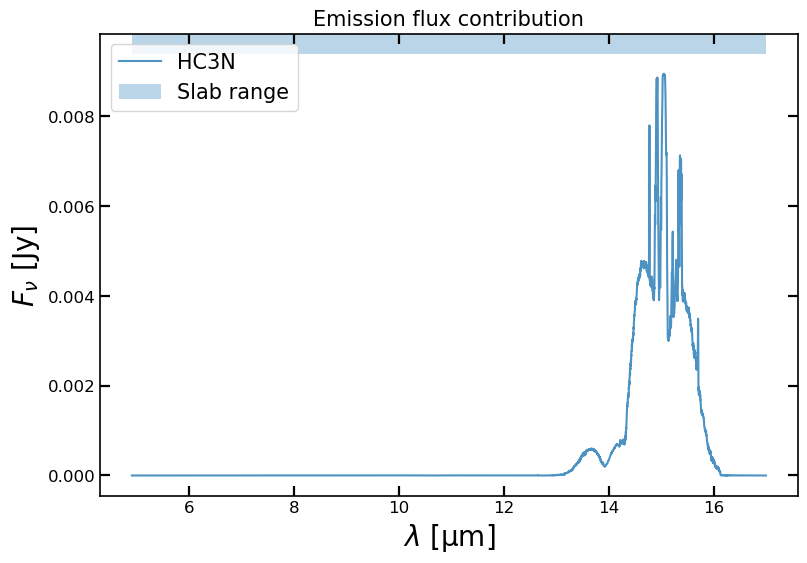

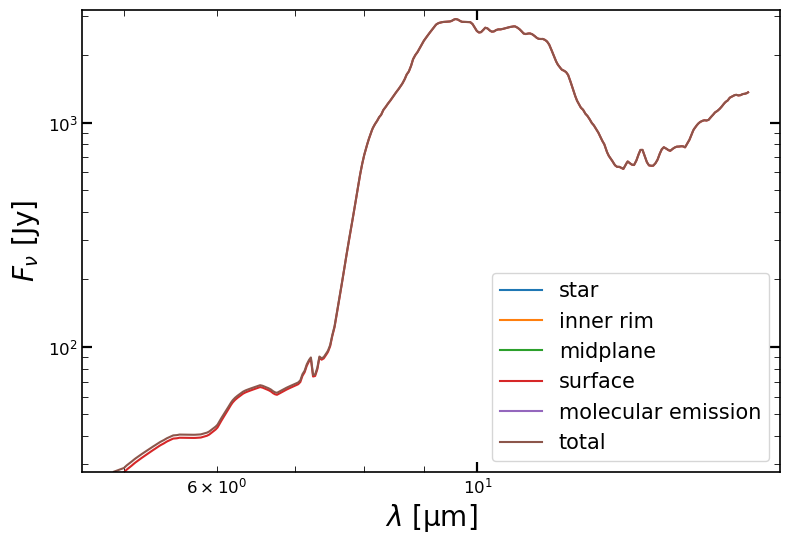

In [116]:
old_version=False
mod.run_model(variables=var_dict,dust_species=abundance_dict,slab_dict=slab_dict,output_all=False,timeit=True)
mod.plot() #this plots the final model


In [120]:
mod.calc_integrated_flux('HC3N',wave_lims=[14,16])

8.754439850276665e-17

In [39]:
freq_steps=[]

freq_steps.append(abs(mod.freq[0]-mod.freq[1]))
for i in range(1,len(mod.freq)-1):
    freq_steps.append(abs(mod.freq[i-1]-mod.freq[i+1])/2)
    
freq_steps.append(abs(mod.freq[-2]-mod.freq[-1]))
freq_steps=np.array(freq_steps)
print(freq_steps)

[9.96937930e+09 9.96775363e+09 9.96450310e+09 ... 2.59526872e+09
 2.59450529e+09 2.59412366e+09]


In [41]:
calc_integrated_flux('HC3N')

9.261915765901668e-17

In [203]:
old_version=False
mod.run_model(variables=var_dict,dust_species=abundance_dict,slab_dict=slab_dict,output_all=True,timeit=True)
#mod.plot() #this plots the final model


--------------
Surface time
Init 2.9325485229492188e-05
Call array 0.0007214546203613281
BB times exp 2.7418136596679688e-05
Multiplying 0.0006415843963623047
First and last point 8.797645568847656e-05
Multiplying with dust opacity 0.00038242340087890625
Summing up 0.00022220611572265625
--------------
--------------
Slab of HC3N
Single slab version
Temp,coldens 1340.1854267608269 1.9229996305157082e+20
temp_lower 1325
temp_upper 1350
dens_lower 1.4677992676220615e+20
dens_upper 2.1544346900318778e+20
--------------



(array([0.00159218, 0.00159175, 0.00159131, ..., 0.00041696, 0.00041684,
        0.00041673]),
 array([2.23035406e+16, 2.22996641e+16, 2.22957884e+16, ...,
        7.89394853e+15, 7.89208391e+15, 7.89021993e+15]),
 array([1.23870634e+08, 1.23868733e+08, 1.23866827e+08, ...,
        7.56066976e+07, 7.55943205e+07, 7.55819458e+07]),
 {'MgOlivine0.1.Combined.Kappa_rv0.1.dat': array([ 825614.10520126,  827741.90910034,  829869.84989065, ...,
         5705686.70882324, 5709328.20132232, 5712969.49145512]),
  'MgOlivine2.0.Combined.Kappa_rv2.0.dat': array([1.95559584e+07, 1.96026513e+07, 1.96493472e+07, ...,
         1.18347549e+08, 1.18415287e+08, 1.18483020e+08]),
  'MgOlivine5.0.Combined.Kappa_rv5.0.dat': array([5.13984213e+07, 5.15126064e+07, 5.16267987e+07, ...,
         2.48389754e+08, 2.48487226e+08, 2.48584691e+08]),
  'MgPyroxene0.1.Combined.Kappa_rv0.1.dat': array([ 3556937.26594786,  3571273.66941912,  3585611.05000669, ...,
         10387499.02835586, 10395115.08804737, 10402730.

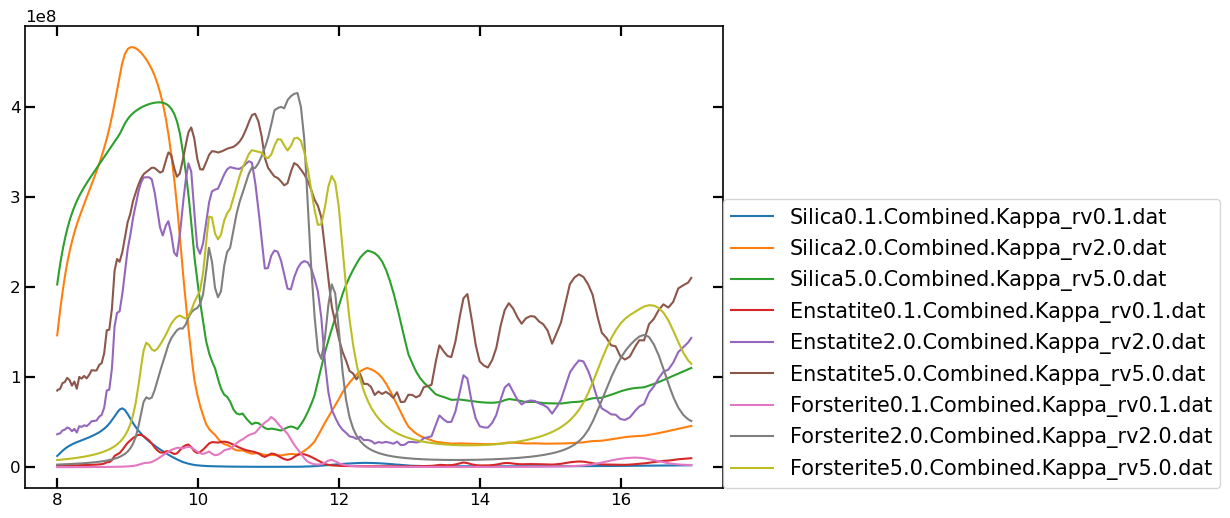

In [211]:
for key in mod.surface_flux_individual_scaled:
    if 'Olivine' not in key and 'Pyroxene' not in key:
        
        plt.plot(mod.xnew,mod.surface_flux_individual_scaled[key],label=key)
plt.legend(loc=(1,0))
plt.show()

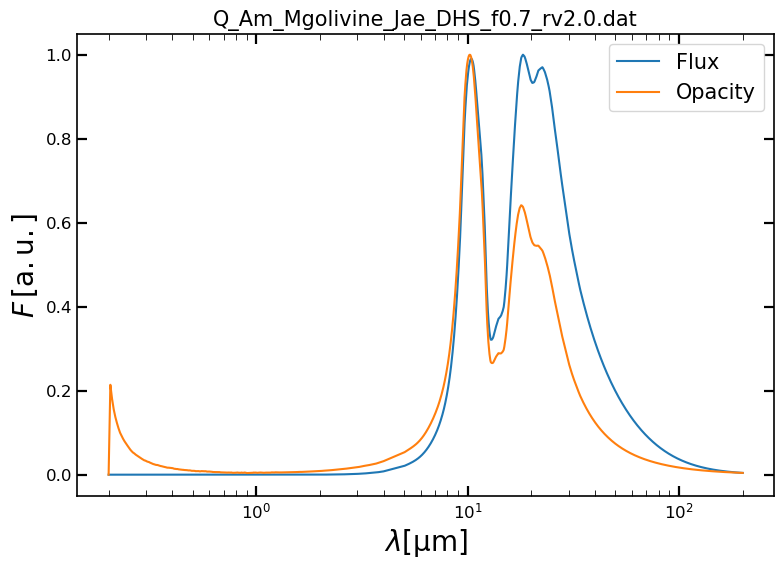

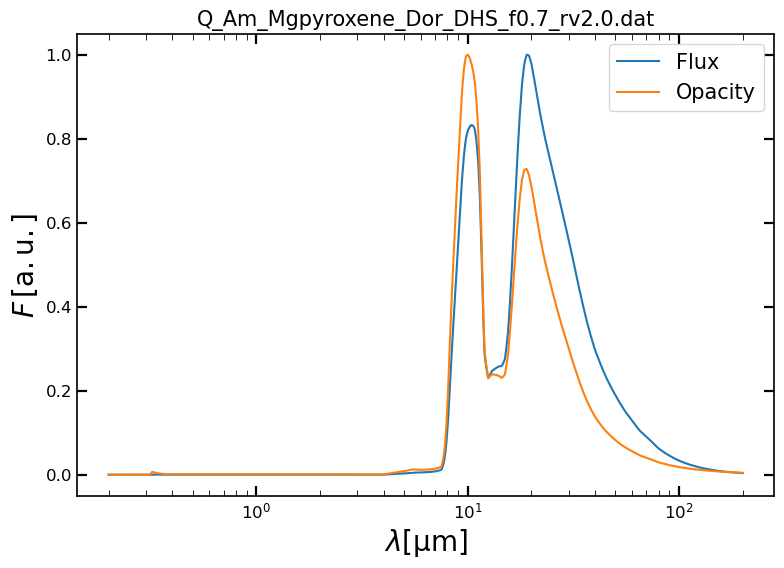

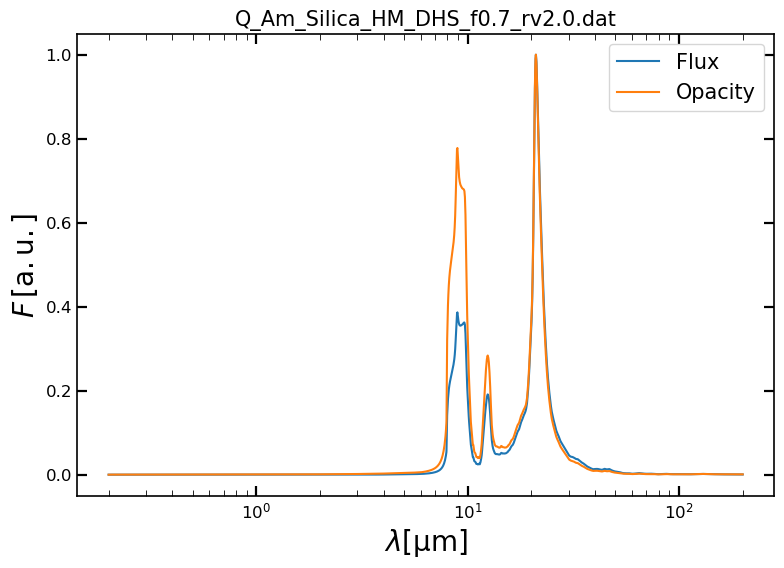

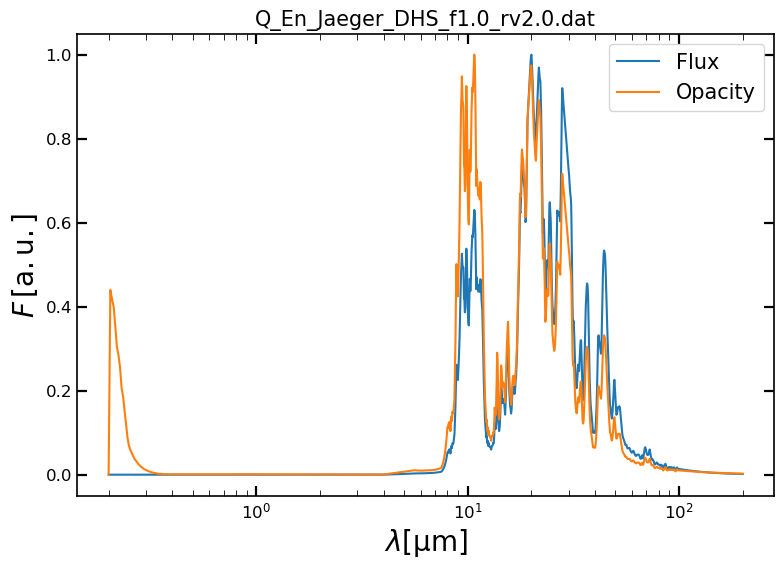

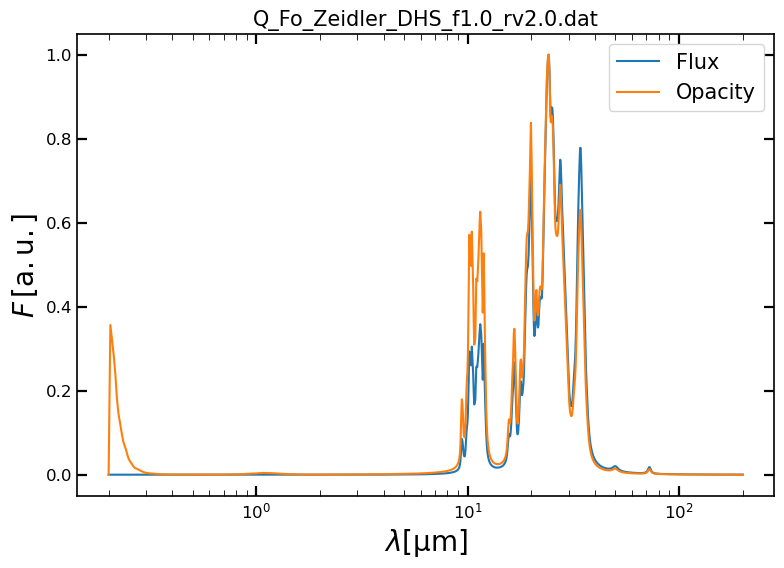

In [34]:

comp_colors_dust=['#e6194b', '#3cb44b',  '#4363d8', '#f58231', '#911eb4', '#46f0f0',
             '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
             '#aaffc3', '#808000', '#ffd8b1','#ffe119', '#000075', '#808080', '#ffffff', '#000000']

threshold=1.3e-10
plot_species=['Q_Am_Mgolivine_Jae_DHS_f0.7_rv0.1.dat','Q_Am_Silica_HM_DHS_f0.7_rv0.1.dat','Q_Am_Silica_HM_DHS_f0.7_rv2.0.dat','Q_En_Jaeger_DHS_f1.0_rv1.5.dat']
use_th=False
use_species=False
plt.figure(figsize=(9,6))
i=0
for key in mod.surface_flux_individual_scaled:
    plotting=True
    if use_th:
        if np.max(abundance_dict[key]*mod.surface_flux_individual_scaled[key])*1000>=threshold:
            plotting=True
        else:
            plotting=False
    if use_species:
        if key in plot_species:
            plotting=True
        else:
            plotting=False
    if plotting:
        plt.title(key)
        plt.plot(mod.xnew,mod.surface_flux_individual_scaled[key]/np.max(mod.surface_flux_individual_scaled[key]),label='Flux')
        plt.plot(mod.xnew,mod.data_dict[key]/np.max(mod.data_dict[key]),label='Opacity')
        
        i+=1
        #plt.xlim(13.5,16.5)
        #plt.yscale('log')
        plt.xscale('log')
        plt.legend()
        plt.ylabel('$F \, [\mathrm{a.u.}]$')
        plt.xlabel('$\lambda [\mathrm{\mu m}]$')
        plt.show()

In [121]:
var_dict={'q_emis': -0.6947498083114624,
         'distance':191.4,
         'incl':0.0}

In [131]:
import numpy as np
data_model=np.loadtxt('../JWST_data/secret/adi8147_Suppl. Other File Type_seq1_v1.dat',skiprows=0)
min_wave=7
max_wave=15.5
lam_obs=data_model[:,0]
flux_obs=data_model[:,2]
sig_obs=flux_obs*0.005
idx=np.where(lam_obs<=max_wave)[0]
lam_obs=lam_obs[idx]
flux_obs=flux_obs[idx]
sig_obs=sig_obs[idx]
idx=np.where(lam_obs>=min_wave)[0]
lam_obs=lam_obs[idx]
flux_obs=flux_obs[idx]
sig_obs=sig_obs[idx]

wavelength=lam_obs

In [132]:
slab_dict={'C2H4_I': {'ColDens': 403522821087202.0, 'temis': 1375.4698246717453}, 'CH4': {'ColDens_tmin': 2.6264339219014165e+22, 'ColDens_tmax': 264173605952562.72, 'tmax': 796.6141119599342, 'tmin': 329.3930187821388}, 'C2H6_I': {'ColDens': 4.771174989752387e+20, 'temis': 29.255439341068268}, 'HCN': {'ColDens': 9.747053784983203e+17, 'temis': 1366.7231529951096}, 'C2H2_I':{'ColDens_tmin': 2.6264339219014165e+22, 'ColDens_tmax': 264173605952562.72, 'tmax': 796.6141119599342, 'tmin': 329.3930187821388}, 'C6H6': {'ColDens': 2.4937927677086944e+17, 'temis': 169.14937943220139}, 'CO2_II': {'ColDens': 2.53373823131872e+21, 'temis': 1091.3656413555145}, 'HC3N': {'ColDens': 9.176974660046845e+16, 'temis': 1309.0328186750412}}

In [133]:

mod=complete_model()

#wavelength=10**np.linspace(np.log10(4),np.log10(30),5000)
print(len(wavelength))
mod.read_data(variables=var_dict,dust_species={},slab_dict=slab_dict,wavelength_points=wavelength,
              slab_prefix='10_',save_binned_data=True,load_binned_data=True,slab_only_mode=True)


5410
Folder to be searched for pre-binned data:
['./LineData//binned_data/0', './LineData//binned_data/1', './LineData//binned_data/10', './LineData//binned_data/11', './LineData//binned_data/12', './LineData//binned_data/13', './LineData//binned_data/14', './LineData//binned_data/15', './LineData//binned_data/16', './LineData//binned_data/17', './LineData//binned_data/18', './LineData//binned_data/19', './LineData//binned_data/2', './LineData//binned_data/20', './LineData//binned_data/21', './LineData//binned_data/22', './LineData//binned_data/23', './LineData//binned_data/24', './LineData//binned_data/25', './LineData//binned_data/26', './LineData//binned_data/27', './LineData//binned_data/28', './LineData//binned_data/29', './LineData//binned_data/3', './LineData//binned_data/30', './LineData//binned_data/31', './LineData//binned_data/32', './LineData//binned_data/33', './LineData//binned_data/34', './LineData//binned_data/35', './LineData//binned_data/36', './LineData//binned_data/

In [134]:
mod.slab_only_mode

True

In [135]:
mod.emission_flux_individual

{}

In [136]:
slab_dict

{'C2H4_I': {'ColDens': 403522821087202.0, 'temis': 1375.4698246717453},
 'CH4': {'ColDens_tmin': 2.6264339219014165e+22,
  'ColDens_tmax': 264173605952562.72,
  'tmax': 796.6141119599342,
  'tmin': 329.3930187821388},
 'C2H6_I': {'ColDens': 4.771174989752387e+20, 'temis': 29.255439341068268},
 'HCN': {'ColDens': 9.747053784983203e+17, 'temis': 1366.7231529951096},
 'C2H2_I': {'ColDens_tmin': 2.6264339219014165e+22,
  'ColDens_tmax': 264173605952562.72,
  'tmax': 796.6141119599342,
  'tmin': 329.3930187821388},
 'C6H6': {'ColDens': 2.4937927677086944e+17, 'temis': 169.14937943220139},
 'CO2_II': {'ColDens': 2.53373823131872e+21, 'temis': 1091.3656413555145},
 'HC3N': {'ColDens': 9.176974660046845e+16, 'temis': 1309.0328186750412}}

Mean compo_ar:
0
0.02301382140656404
1
0.06291715497306168
2
0.019786329060824226
3
0.04509816376157639
4
0.10783219316906768
5
0.004722753332406056
6
0.3042228404025211
7
0.011674318268850261
Mean flux obs:
1.2733886992836194
before norm [4.77317448 2.51190363 1.29035914 0.17564913 0.36833221 4.3349113
 2.44086945 0.        ]
compo array min and max values
[6.59257924e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
[1. 1. 1. 1. 1. 1. 1. 1.]
0 13357.108383909715 C2H4_I
1 0.18727442381995069 CH4
2 3287692618.2655816 C2H6_I
3 0.02013162683310211 HCN
4 0.013413968345402314 C2H2_I
5 66.09802413698223 C6H6
6 0.11469745578184778 CO2_II
7 0.0 HC3N


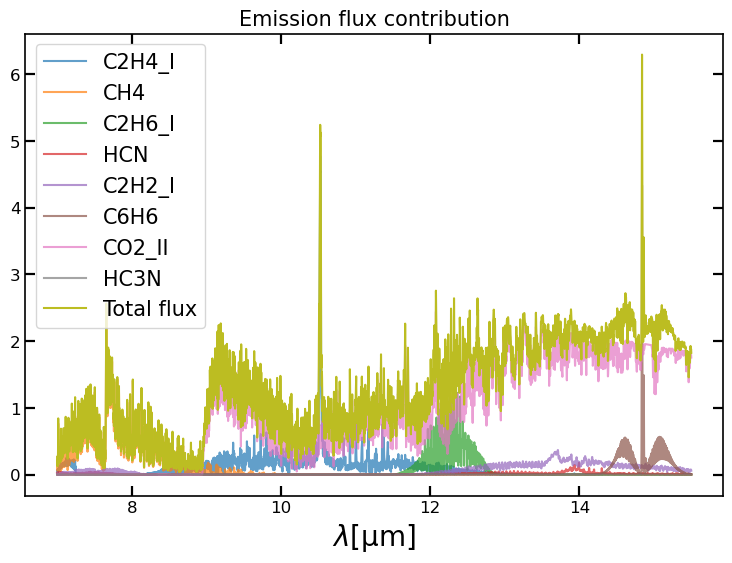

In [137]:
old_version=False
tot_flux=mod.run_fitted_to_obs_slab(variables=var_dict,slab_dict=slab_dict,flux_obs=flux_obs,lam_obs=lam_obs,
                                    debug=True,save_output=True)
#mod.plot() #this plots the final model


In [144]:
radii=np.sqrt(mod.scaleparas)
i=0
for key in slab_dict: 
    slab_dict[key]['radius']=radii[i]
    i+=1

In [145]:
# this dictonary has a single temperature for the inner rim
var_dict={'tstar':9000,
         'rstar':2.5,
         't_rim':1500.6,
         'tmin_s':50.3,
         'tmax_s':1000.1,
         'tmin_mp':99.3,
         'tmax_mp':1100.4,
         'sc_ir':1e-16,
         'sc_mid':1e-6,
         'q_mid':-0.6,
         'q_thin':-0.55,
         'bb_star':True,
         'q_emis': -0.6947498083114624,
         'distance':191.4,
         'incl':0.0}

In [146]:
min_wave=7
max_wave=15.5
data=np.loadtxt('../JWST_data/secret/final_spectra.txt',skiprows=0)

lam_obs=data[:,0]
flux_obs=data[:,1]
sig_obs=flux_obs*0.005
idx=np.where(lam_obs<=max_wave)[0]
lam_obs=lam_obs[idx]
flux_obs=flux_obs[idx]
sig_obs=sig_obs[idx]
idx=np.where(lam_obs>=min_wave)[0]
lam_obs=lam_obs[idx]
flux_obs=flux_obs[idx]
sig_obs=sig_obs[idx]


In [147]:

mod_both=complete_model()

#wavelength=10**np.linspace(np.log10(4),np.log10(30),5000)
print(len(wavelength))
mod_both.read_data(variables=var_dict,dust_species=abundance_dict,slab_dict=slab_dict,wavelength_points=wavelength,
              slab_prefix='10_',save_binned_data=True,load_binned_data=True,slab_only_mode=False)


5410
Folder to be searched for pre-binned data:
['./LineData//binned_data/0', './LineData//binned_data/1', './LineData//binned_data/10', './LineData//binned_data/11', './LineData//binned_data/12', './LineData//binned_data/13', './LineData//binned_data/14', './LineData//binned_data/15', './LineData//binned_data/16', './LineData//binned_data/17', './LineData//binned_data/18', './LineData//binned_data/19', './LineData//binned_data/2', './LineData//binned_data/20', './LineData//binned_data/21', './LineData//binned_data/22', './LineData//binned_data/23', './LineData//binned_data/24', './LineData//binned_data/25', './LineData//binned_data/26', './LineData//binned_data/27', './LineData//binned_data/28', './LineData//binned_data/29', './LineData//binned_data/3', './LineData//binned_data/30', './LineData//binned_data/31', './LineData//binned_data/32', './LineData//binned_data/33', './LineData//binned_data/34', './LineData//binned_data/35', './LineData//binned_data/36', './LineData//binned_data/

In [150]:
old_version=False
tot_flux=mod_both.run_model(variables=var_dict,dust_species=abundance_dict,slab_dict=slab_dict)
#mod.plot() #this plots the final model


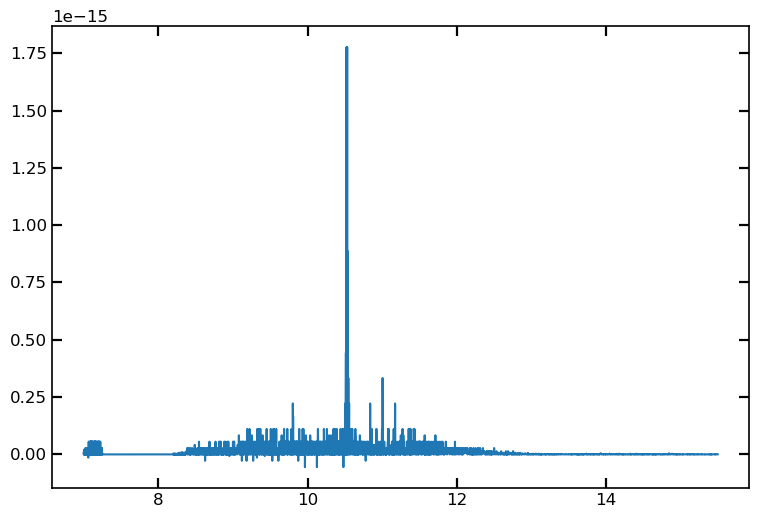

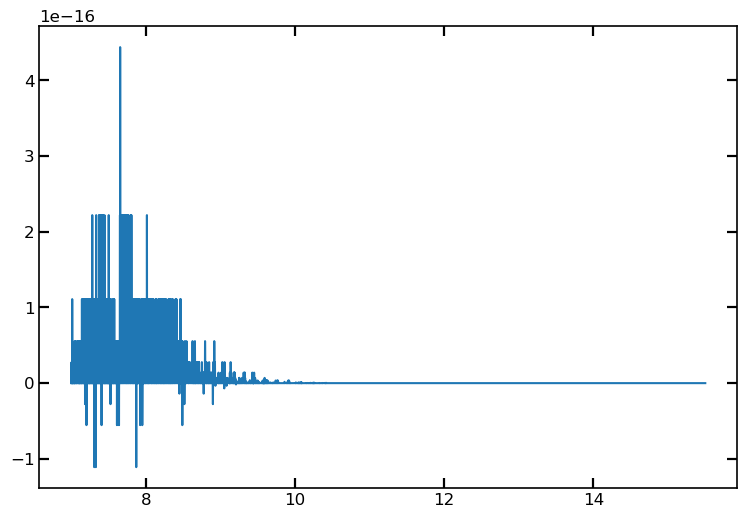

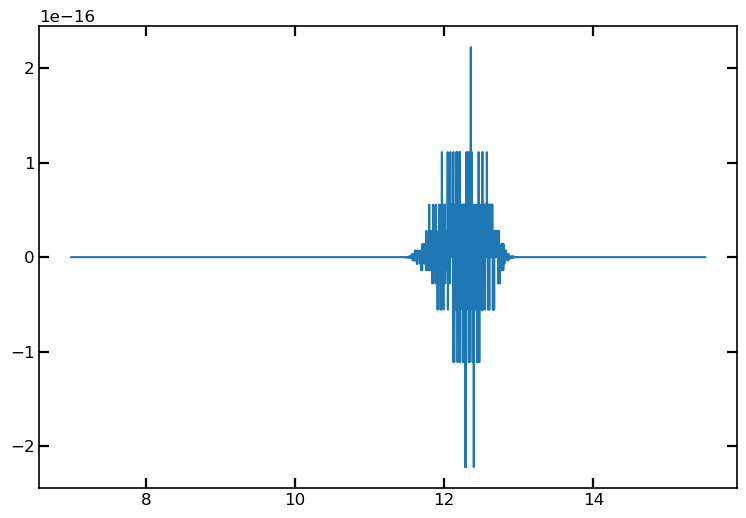

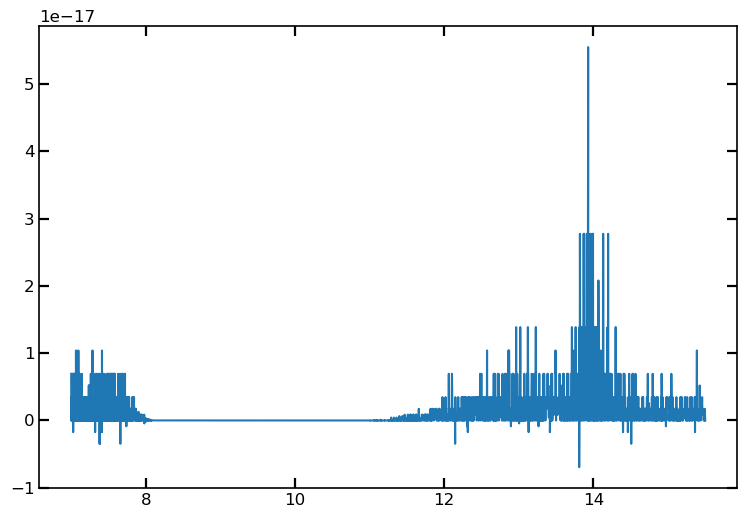

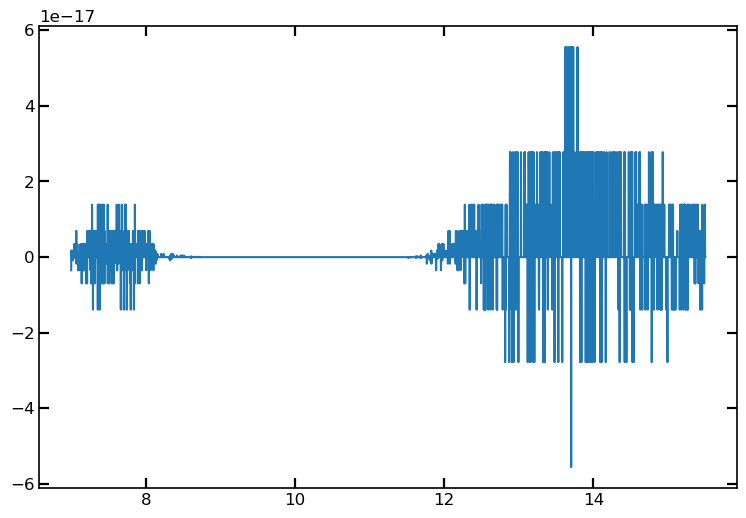

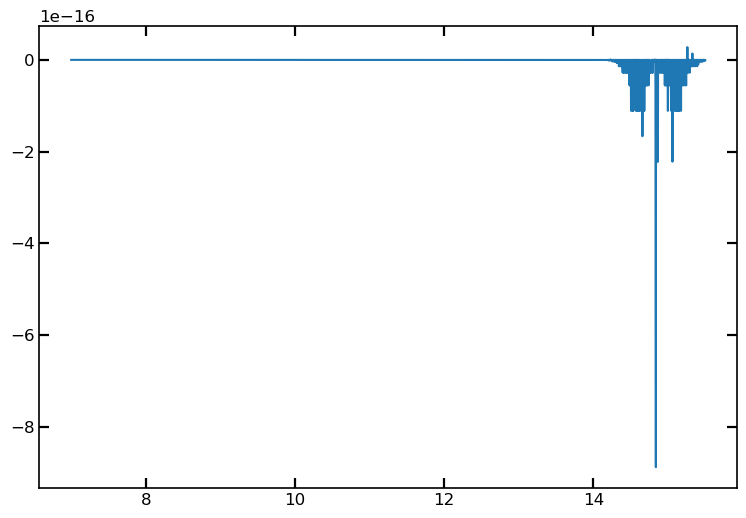

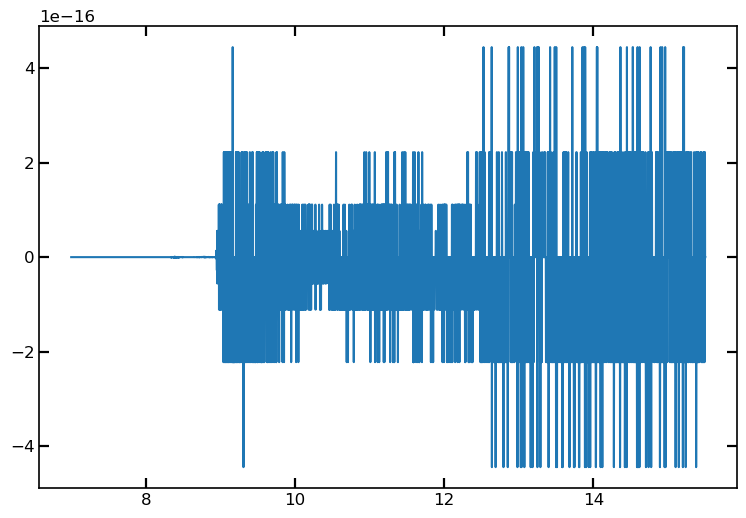

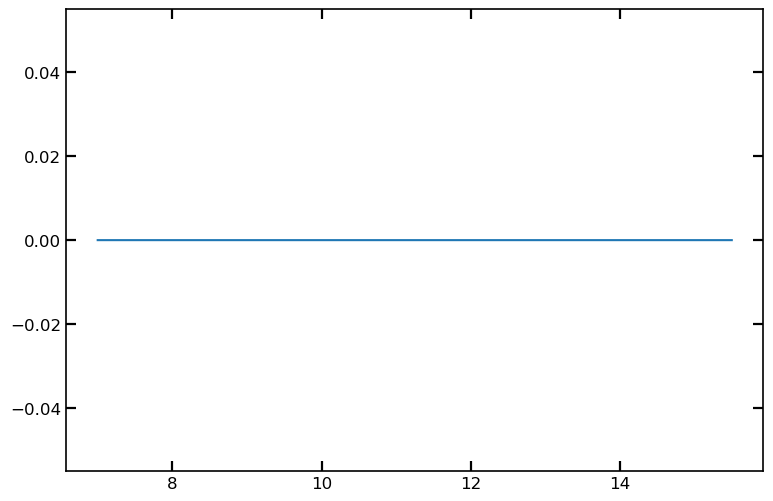

In [152]:
for key in mod.emission_flux_individual_scaled:
    plt.plot(mod.xnew,mod.emission_flux_individual_scaled[key]-mod_both.emission_flux_individual_scaled[key])
    plt.show()

### step two

loading the data

this is done with {name_model}.read_data()

read_data has name input variables, namely:
- variables: this should be your variable dictonary
- dust_species: this should be your abundance dictonary
- wavelength_points: defining the wavelength points at which the model is calculated, default is [] which means a preset grid is used
- stellar_file: path of the stellar spectrum if this should be used, default is './MCMAXspec-hae.in' (will only be used if bb_star=False in variable dict)
- dust_path: the path where the dust files are found, default is dust_path
- q_files: to define is kappa or q_files are used, default is True
- interp_bbody: is not needed anymore, default is False
- debug: should output be printed, default is False


variables will only be used to determine the star, if the inner rim is a black body or a powerlaw, and to set tzones (which will probably not be used) 
dust species will only determine the number of dust species that are used, the scaling factors are ignored 

In [251]:
tot_flux

array([0.79417633, 0.79515864, 0.49310354, ..., 0.09084589, 0.1311502 ,
       0.20201673])

In [35]:

path_spec='./slab-model-testing/AA-Tau-g2d1000/AATau_g2d1000_specFLiTs_CO2_LTE_SNR300.dat'
with open(path_spec,'r') as f:

    lines=f.readlines()[1:]
wave_list=[]
flux_list=[]
for line in lines:
    wave,flux=line.split()
    wave_list.append(float(wave))
    flux_list.append(float(flux))
lam_obs=np.array(wave_list)
wavelength=lam_obs

In [36]:
wavelength=generate_grid(R=300,lambda_0=5,lambda_n=28)
print(len(wavelength))

518


In [37]:
slab_dict={
            'CO2_H':{'ColDens_tmin':1.0e15,
                     'ColDens_tmax':1.0e21,
                    'tmax':905.5,
                    'tmin':82.9,
                     'radius':30
                    }

          }
slab_dict={
            'CO2_H':{'ColDens_tmin':1e15,
                  'ColDens_tmax':1e21,
                    'tmax':905.5,
                    'tmin':399.9,
                     'radius':30
                    }

          }

In [30]:
slab_dict={
            'CO2':{'ColDens_tmin':1e18,
                   'ColDens_tmax':1e21,
                    'tmax':700,
                    'tmin':600,
                     'radius':0.2
                    },
            'H2O':{'ColDens_tmin':5e17,
                   'ColDens_tmax':5e21,
                    'tmax':921.1,
                    'tmin':821,
                     'radius':0.2
                    },
                'HCN':{'ColDens_tmin':5e17,
                    'ColDens_tmax':5e19,
                    'tmax':921.1,
                    'tmin':521,
                     'radius':0.2
                    },

          }

In [31]:
slab_dict={
            'CO2':{'ColDens_tmin':1e18,
                   'ColDens_tmax':1e21,
                    'tmax':700,
                    'tmin':699,
                     'radius':0.2
                    },
            'C6H6':{'ColDens_tmin':5e17,
                    'ColDens_tmax':5e19,
                    'tmax':521.1,
                    'tmin':500.0,
                     'radius':0.2
                    }
            

          }

In [32]:
mod.cosi


True

In [34]:
slab_dict={
           'H2O':{'ColDens':5e20,
                    'tmax':921.1,
                    'tmin':221,
                     'radius':0.7
                    },
    
            'CO2_H':{'ColDens':5e19,
                    'tmax':500,
                    'tmin':200,
                     'radius':0.8
                    },
           'CH4_H':{'ColDens':1e17,
                    'tmax':900,
                    'tmin':400,
                     'radius':0.3
                    },
            'C2H2_H':{'ColDens':1e18,
                    'tmax':600,
                    'tmin':500,
                     'radius':0.2},
            'CH4_H':{'ColDens':1e21,
                    'tmax':900,
                    'tmin':800,
                     'radius':1.8
                    },
           'HCN_H':{'ColDens':5e18,
                    'tmax':900,
                    'tmin':800,
                     'radius':0.3
                    },

          }

In [35]:
slab_dict={'CO2':{
                  'ColDens':1e21,
                    'tmax':851,
                    'tmin':599,
                     'radius':0.15
                    }
          }

In [36]:
slab_dict={
            'C6H6':{'ColDens_tmin':5e17,
            'ColDens_tmax':5e19,
            'tmax':591.1,
            'tmin':590.0,
            'radius':0.2
            },
            'CO2':{
                  'ColDens':1e21,
                    'tmax':851,
                    'tmin':599,
                     'radius':0.15
                    }
          }

In [37]:
slab_dict={'CO2':{'ColDens_tmin':10**1.40897090e+01,
                  'ColDens_tmax':10**1.77311083e+01,
                    'tmax':6.97264974e+02,
                    'tmin':6.19601971e+02,
                     'radius':0.15
                    }
          }

In [46]:
slab_dict={'CO2':{'ColDens_tmin':1e+14,
                  'ColDens_tmax':1e+18,
                    'tmax':6.99e+02,
                    'tmin':6.80e+02,
                     'radius':0.15
                    }
          }

In [47]:
var_dict

{'tstar': 9000,
 'rstar': 2.5,
 'distance': 140,
 't_rim': 1500.6,
 'tmin_s': 50.3,
 'tmax_s': 1000.1,
 'tmin_mp': 99.3,
 'tmax_mp': 1100.4,
 'sc_ir': 1e-16,
 'sc_mid': 1e-06,
 'q_mid': -0.6,
 'q_thin': -0.55,
 'q_emis': -0.55,
 'bb_star': True,
 'incl': 0.0,
 'exp_midplane': -4.333333333333334,
 'exp_surface': -4.636363636363636,
 'exp_emission': -0.55}

-----------
C2H2
ColDens_tmin 609.9953271834132
ColDens_slope 340.5303465636113
logColDens_min 14.018789333436597
upper_in_temp 650
lower_in_temp 625
upper_in 4.056490180857798e-17
lower_in 1.861246614403124e-18
lower_out_temp 609.9953271834132
upper_out_temp 651.5387880918149
lower_out 1.1176059524884907e-18
upper_out 4.9964611416486886e-18
-----------
H2O
ColDens_tmin 600.1864301550374
ColDens_slope -76.52126847811739
logColDens_min 18.95065299513848
inner_part_temp [650]
inner_part [3.51203253e-21]
upper_in_temp 675
lower_in_temp 625
upper_in 9.789115112344348e-23
lower_in 3.122978937360785e-20
lower_out_temp 600.1864301550374
upper_out_temp 677.6089541531853
lower_out 2.757574998091347e-19
upper_out 1.7820560047724765e-23
-----------
----------------
Keys in output dict
C2H2
ColDens_tmin
609.9953271834132
ColDens_slope
340.5303465636113
logColDens_min
14.018789333436597
upper_in_temp
650
lower_in_temp
625
upper_in
4.056490180857798e-17
lower_in
1.861246614403124e-18
lower_out_temp


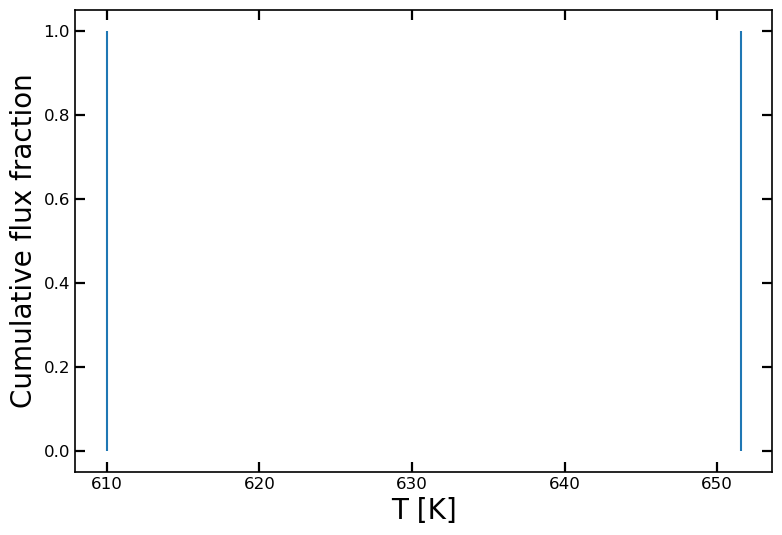

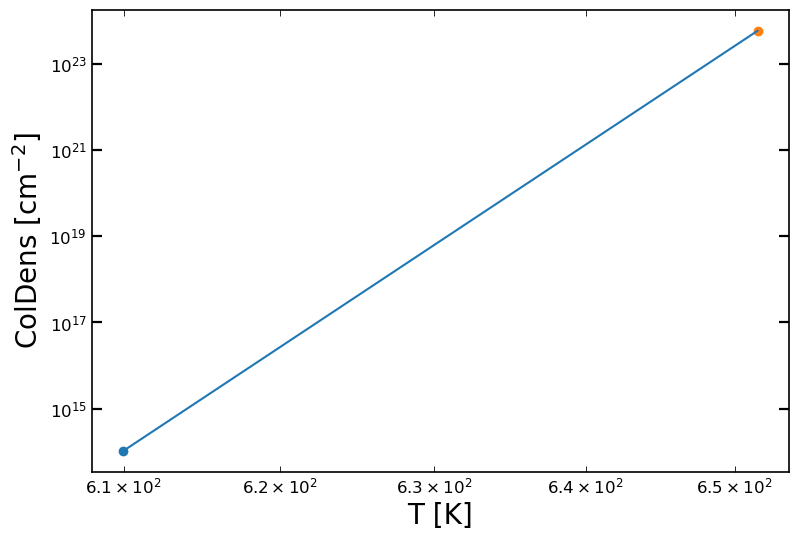

tmax,tmin 651.5387880918149 609.9953271834132
t at max,t at min 651.5387880918149 609.9953271834132


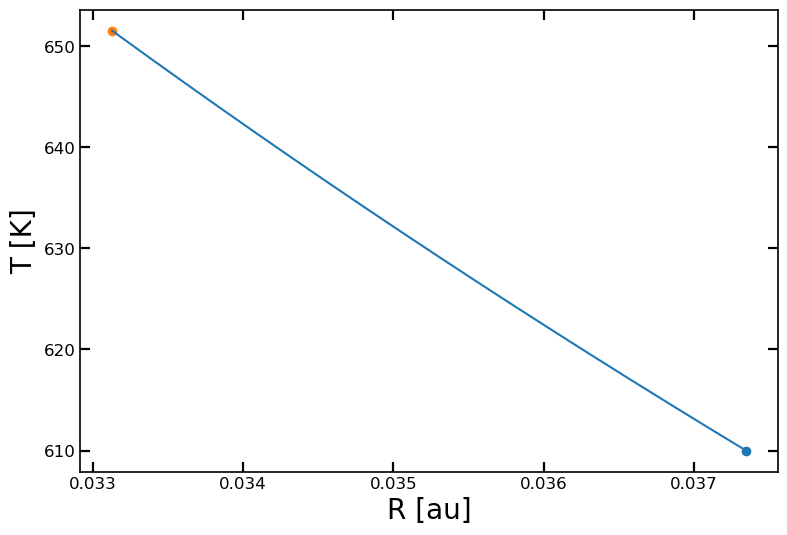

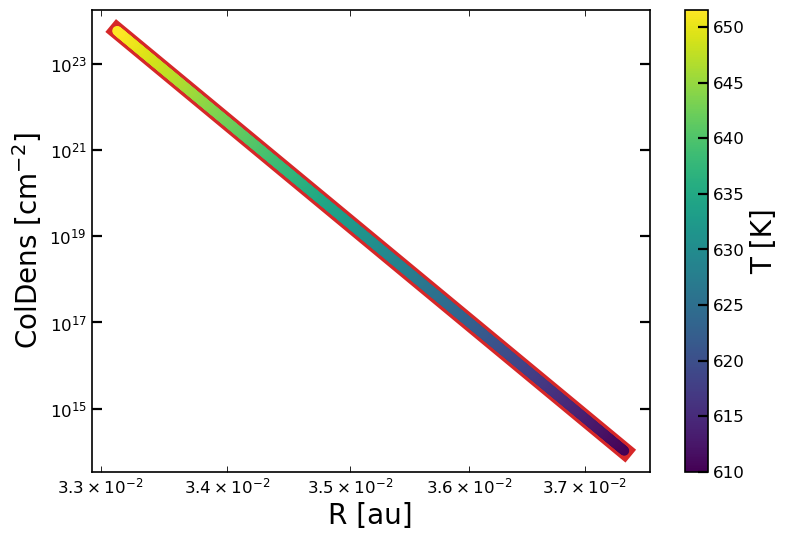

----------------
Keys in output dict
H2O
ColDens_tmin
600.1864301550374
ColDens_slope
-76.52126847811739
logColDens_min
18.95065299513848
inner_part_temp
[650]
inner_part
[3.51203253e-21]
upper_in_temp
675
lower_in_temp
625
upper_in
9.789115112344348e-23
lower_in
3.122978937360785e-20
lower_out_temp
600.1864301550374
upper_out_temp
677.6089541531853
lower_out
2.757574998091347e-19
upper_out
1.7820560047724765e-23
-----------
H2O
Contributing to total flux: inner_part
Contributing to total flux: upper_in
Contributing to total flux: lower_in
Contributing to total flux: lower_out
Contributing to total flux: upper_out
Total flux (w/o) radius and norm 3.106150334264258e-19
FIRST STEP IS ALREADY ABOVE THE SET LOWER LIM
t_at_min 600.1864301550374
t_at_max 625


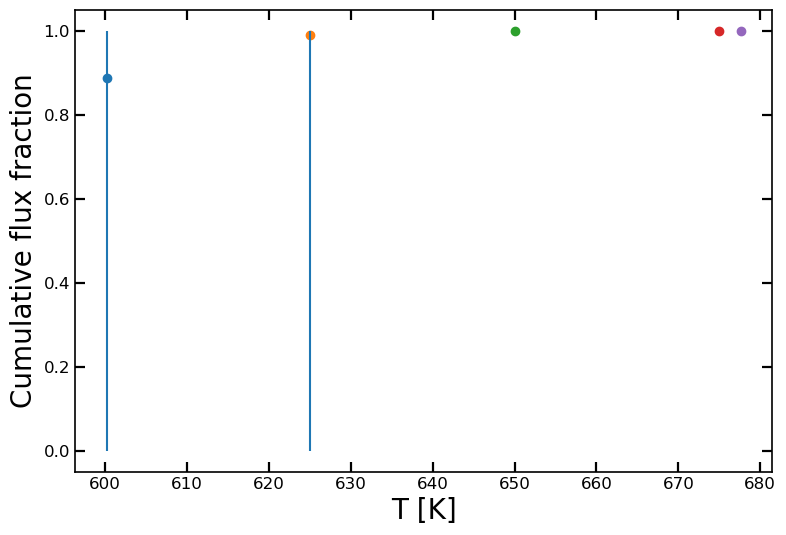

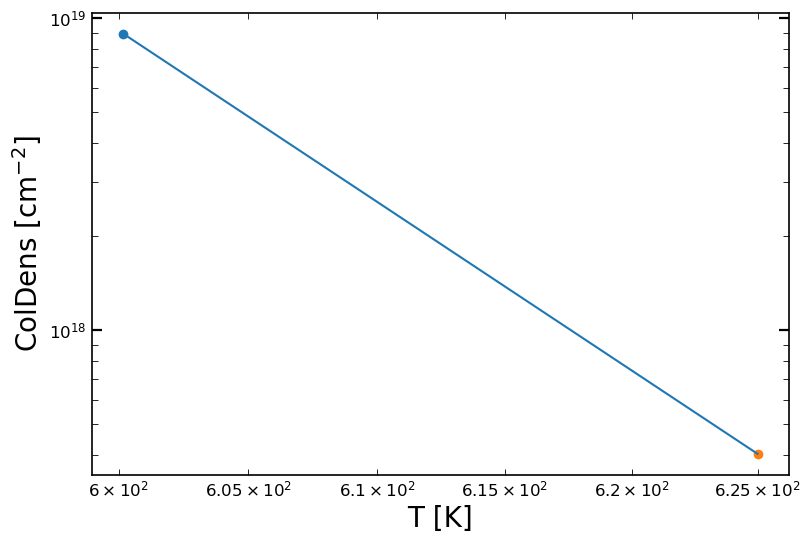

tmax,tmin 677.6089541531853 600.1864301550374
t at max,t at min 625 600.1864301550374


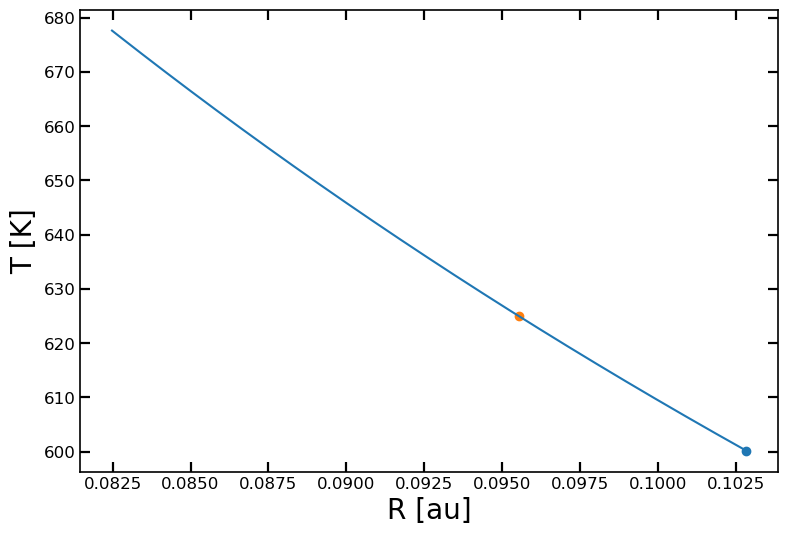

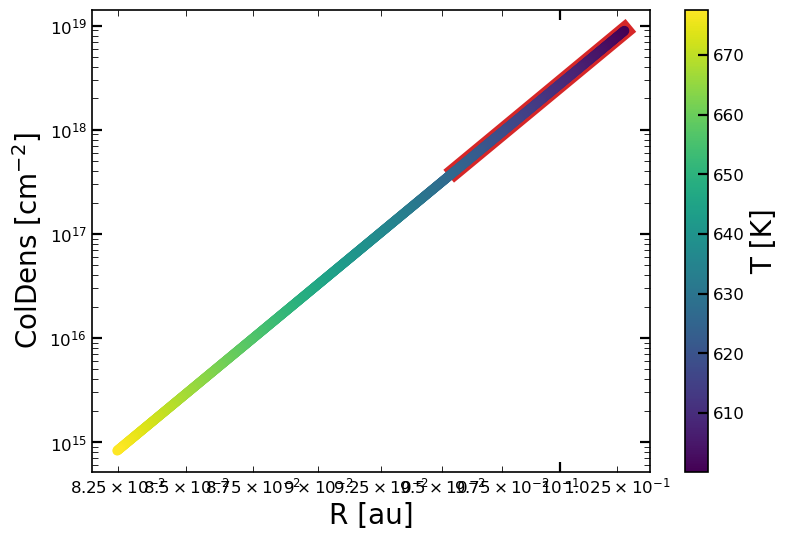

{'C2H2': {'radius_eff': 0.017237492316808933,
  'tmin,tmax': [609.9953271834132, 651.5387880918149],
  'cmin,cmax': [104421357164340.12, 5.78955937543514e+23],
  'rout,rin': [0.037345517438454344, 0.03312939074860645]},
 'H2O': {'radius_eff': 0.03806032888510005,
  'tmin,tmax': [600.1864301550374, 625],
  'cmin,cmax': [8.925920103811254e+18, 4.021144106912396e+17],
  'rout,rin': [0.10283684533904769, 0.09553443423418193]}}

In [106]:
mod.extract_emission_quantities(debug=True)

--------------
Slab of CO2
Single slab version
Temp,coldens 599 9e+19
temp_lower 575
temp_upper 600
dens_lower 6.8129206905795944e+19
dens_upper 1e+20
--------------



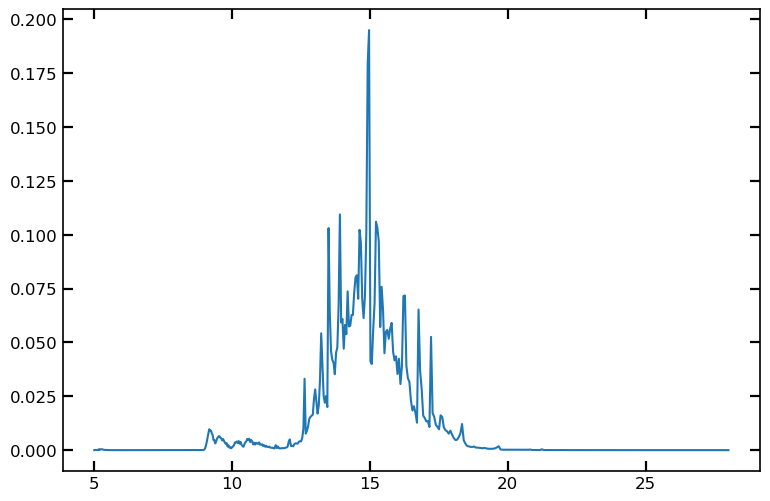

In [73]:

flux=mod.set_emission_lines(one_output=True,debug=True)
plt.plot(mod.xnew,flux)


In [34]:
emflux2=mod.emission_flux.copy()

In [39]:
emflux1=mod.emission_flux

In [40]:
max(abs(emflux1-emflux2))

0.3386003334489718

In [208]:
degree_to_cos(mod.variables['incl'])

0.7071067811865476

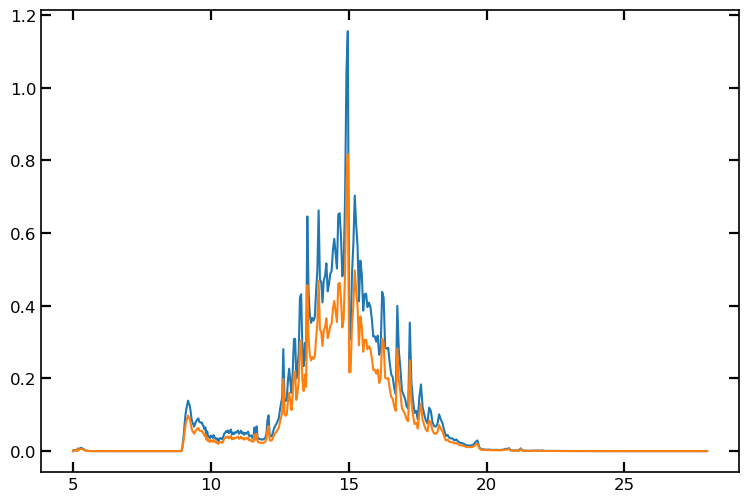

In [41]:
plt.plot(mod.xnew,emflux1)
plt.plot(mod.xnew,emflux2)


/tmp/ipykernel_428310/3818413891.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot((emflux2)/emflux1)


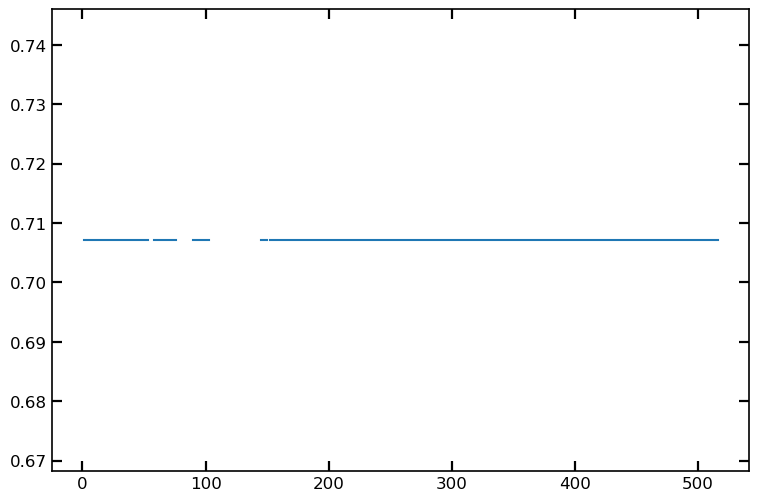

In [42]:
plt.plot((emflux2)/emflux1)


In [128]:
plt.plot((emflux2)/emflux1)
old_version=False
var_dict['q_emis']=mod.variables['exp_emission']
var_dict['sc_ir']=mod.variables['sc_ir']*np.pi*((mod.rsun*mod.variables['rstar'])**2)/((mod.variables['distance']*mod.parsec)**2)
var_dict['sc_mid']=mod.variables['sc_mid']*np.pi*((mod.rsun*mod.variables['rstar'])**2)/((mod.variables['distance']*mod.parsec)**2)

for key in abundance_dict:
    abundance_dict[key]*=np.pi*((mod.rsun*mod.variables['rstar'])**2)/((mod.variables['distance']*mod.parsec)**2)

print(var_dict)
print(abundance_dict)

{'tstar': 9000, 'rstar': 2.5, 'distance': 140, 't_rim': 1500.6, 'tmin_s': 50.3, 'tmax_s': 1000.1, 'tmin_mp': 99.3, 'tmax_mp': 1100.4, 'sc_ir': 3.5711422016510875e-17, 'sc_mid': 5.10163171664441e-07, 'q_mid': -0.6, 'q_thin': -0.55, 'q_emis': -3.0, 'bb_star': True, 'exp_midplane': -4.333333333333334, 'exp_surface': -4.636363636363636, 'exp_emission': -3.0}
{'Q_Am_Mgolivine_Jae_DHS_f0.7_rv2.0.dat': 5.101631716644412e-07, 'Q_Am_Mgpyroxene_Dor_DHS_f0.7_rv2.0.dat': 5.101631716644412e-07, 'Q_Am_Silica_HM_DHS_f0.7_rv2.0.dat': 5.101631716644412e-07, 'Q_En_Jaeger_DHS_f1.0_rv2.0.dat': 5.101631716644412e-07, 'Q_Fo_Zeidler_DHS_f1.0_rv2.0.dat': 5.101631716644412e-07}


Init 3.5762786865234375e-06
Star 0.0005705356597900391
Inner rim 0.0004076957702636719
Midplane 0.0020034313201904297
Surface 0.001367807388305664
Emission 0.01636338233947754
Summing up 5.0067901611328125e-05


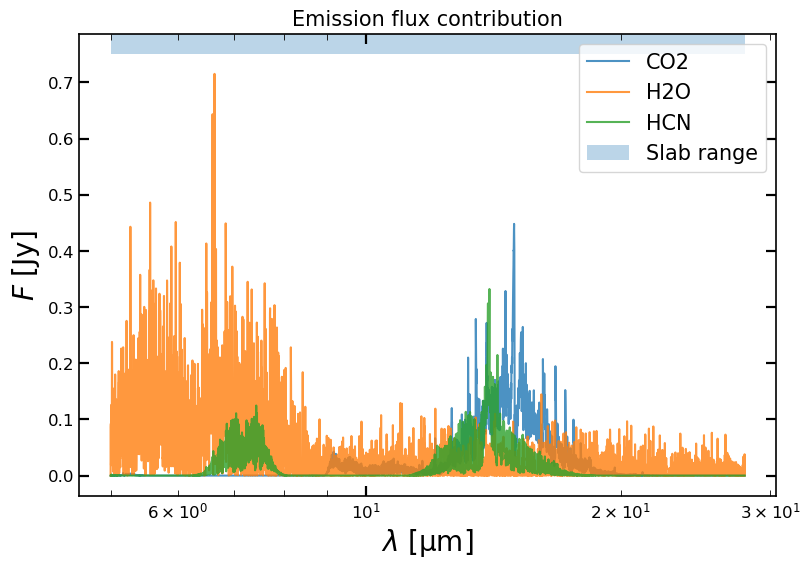

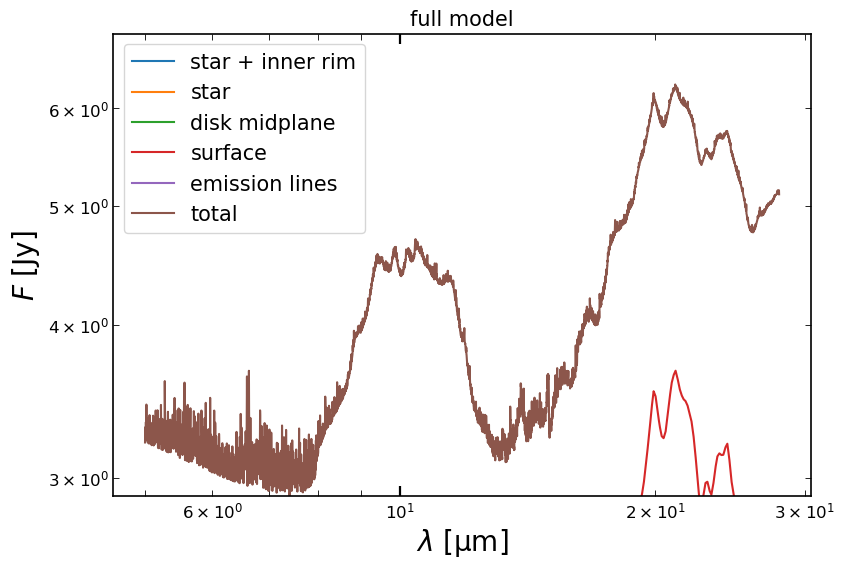

In [129]:
mod.run_model(variables=var_dict,dust_species=abundance_dict,slab_dict=slab_dict,output_all=False,timeit=True)
mod.plot() #this plots the final model


-----------
CO2
ColDens_tmin 599
ColDens_slope 0.023809523809523808
logColDens_min 15.0
inner_part_temp [625 650 675 700 725 750 775 800 825]
inner_part [1.35977244e-12 5.37658662e-12 2.04986583e-11 7.12772857e-11
 2.17451883e-10 5.66455701e-10 1.30484945e-09 2.67852304e-09
 4.88942365e-09]
upper_in_temp 850
lower_in_temp 600
upper_in 3.921431628099208e-09
lower_in 1.695911456715347e-13
lower_out_temp 599
upper_out_temp 851
lower_out 1.3200060797114524e-14
upper_out 3.1664763651280896e-10
norm 0.02064952286160749
-----------
----------------
Keys in output dict
CO2
ColDens_tmin
ColDens_slope
logColDens_min
inner_part_temp
inner_part
upper_in_temp
lower_in_temp
upper_in
lower_in
lower_out_temp
upper_out_temp
lower_out
upper_out
norm
-----------
CO2
Contributing to total flux: inner_part
Contributing to total flux: upper_in
Contributing to total flux: lower_in
Contributing to total flux: lower_out
Contributing to total flux: upper_out
Total flux (w/o) radius and norm 1.3993478090593752e-

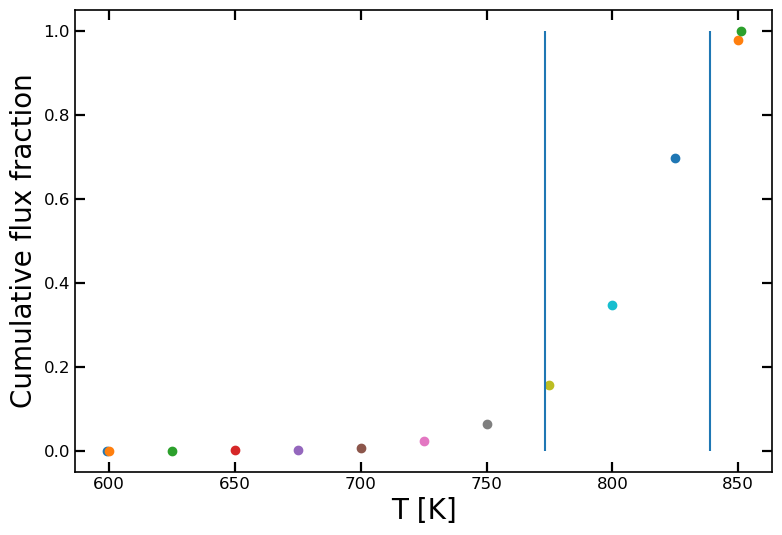

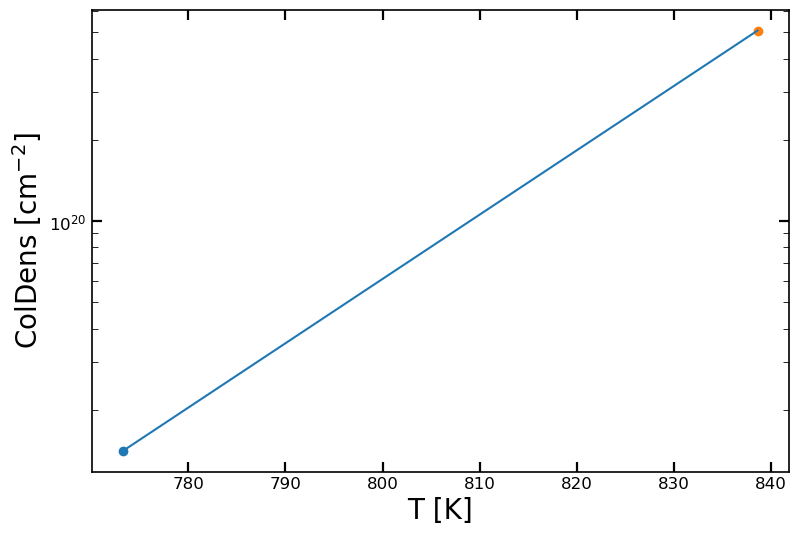

tmax,tmin 851 599
t at max,t at min 838.6369682930044 773.3057352310681


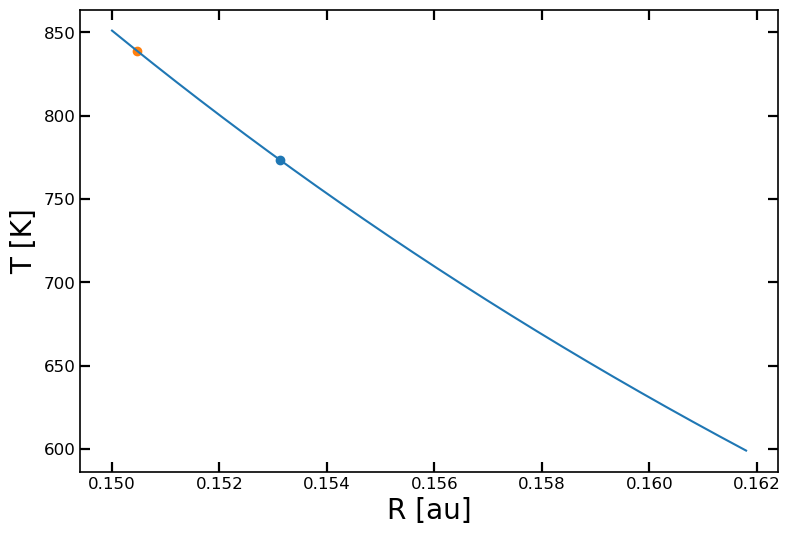

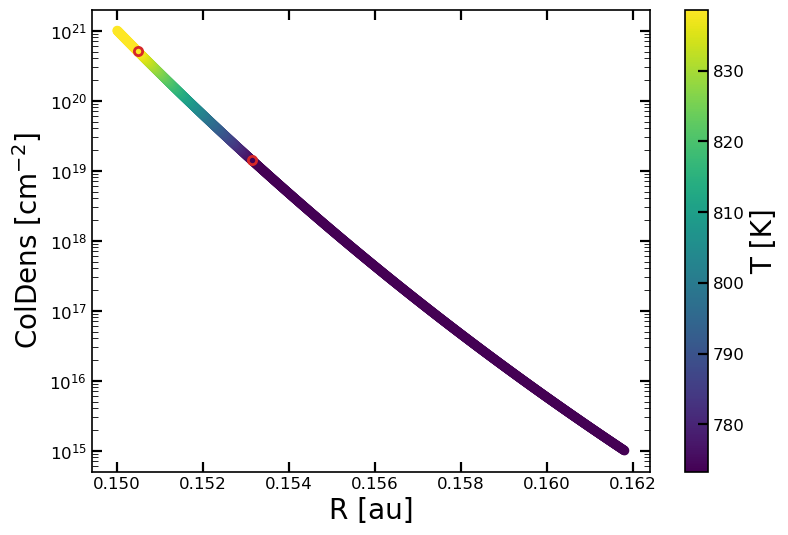

{'CO2': {'tmin,tmax': [773.3057352310681, 838.6369682930044],
  'cmin,cmax': [1.4129817518258555e+19, 5.077408458960713e+20],
  'rmin,rmax': [0.15312959501172937, 0.15047420778331722]}}

In [123]:
mod.extract_emission_quantities(low_contribution=0.15,high_contribution=0.85,debug=True)

-----------
CO2_H
ColDens_tmin 82.9
ColDens_slope 0.0
logColDens_min 21.0
inner_part_temp [100. 110. 120. 130. 140. 150. 160. 170. 180. 190. 200. 210. 220. 230.
 240. 250. 260. 270. 280. 290. 300. 310. 320. 330. 340. 350. 360. 370.
 380. 390. 400. 410. 420. 430. 440. 450. 460. 470. 480. 490. 500. 510.
 520. 530. 540. 550. 560. 570. 580. 590. 600. 610. 620. 630. 640. 650.
 660. 670. 680. 690. 700. 710. 720. 730. 740. 750. 760. 770. 780. 790.
 800. 810. 820. 830. 840. 850. 860. 870. 880. 890.]
inner_part [6.68421671e-19 1.07654237e-18 1.55005750e-18 2.05213000e-18
 2.55326789e-18 3.02935183e-18 3.46071180e-18 3.83527755e-18
 4.14771159e-18 4.39748283e-18 4.58647166e-18 4.71902112e-18
 4.80036122e-18 4.83576894e-18 4.83147723e-18 4.79414318e-18
 4.72974754e-18 4.64326976e-18 4.53897386e-18 4.42060194e-18
 4.29138656e-18 4.15418263e-18 4.01144239e-18 3.86528707e-18
 3.71757995e-18 3.56993085e-18 3.42370852e-18 3.28001802e-18
 3.13966759e-18 3.00326333e-18 2.87119755e-18 2.74375672e-18
 2.6

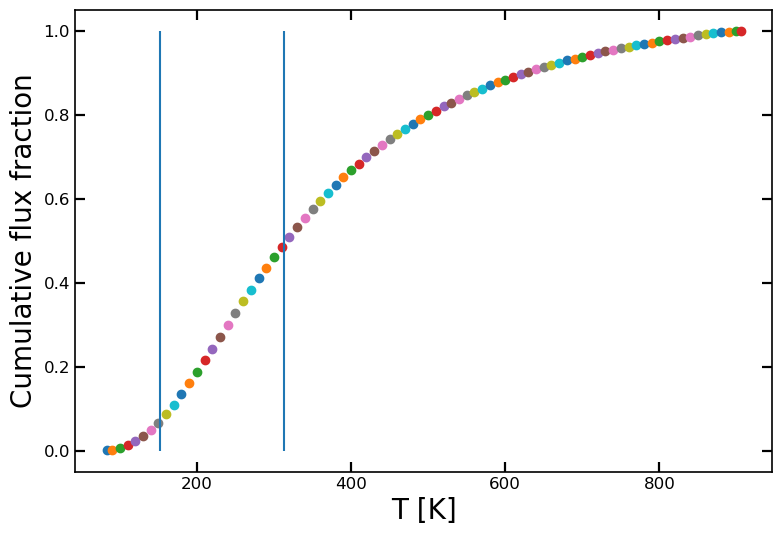

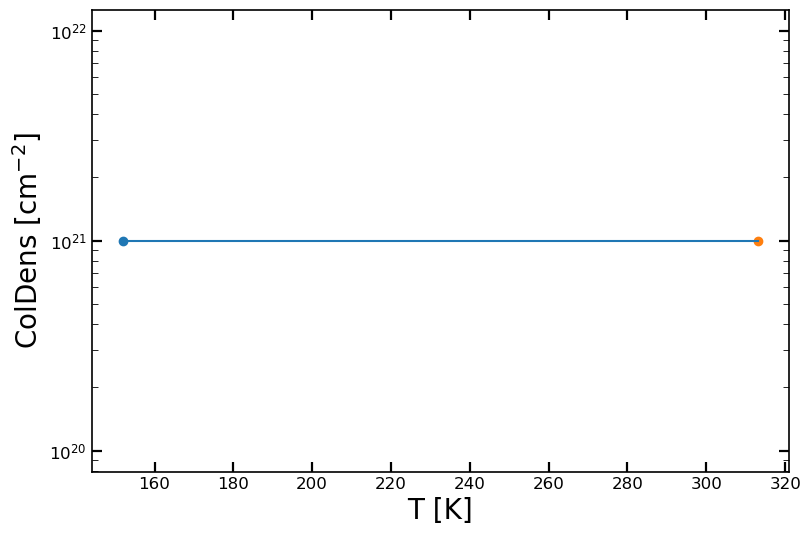

New effectiv radius: 9.58344452593727


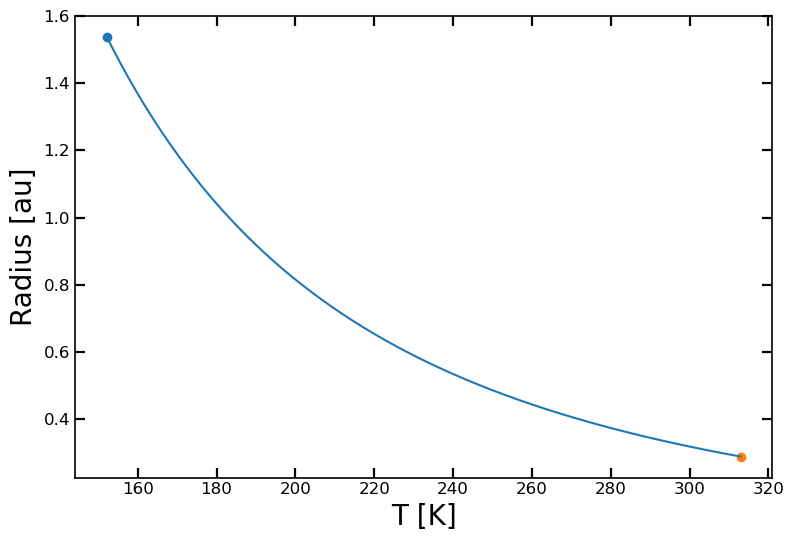

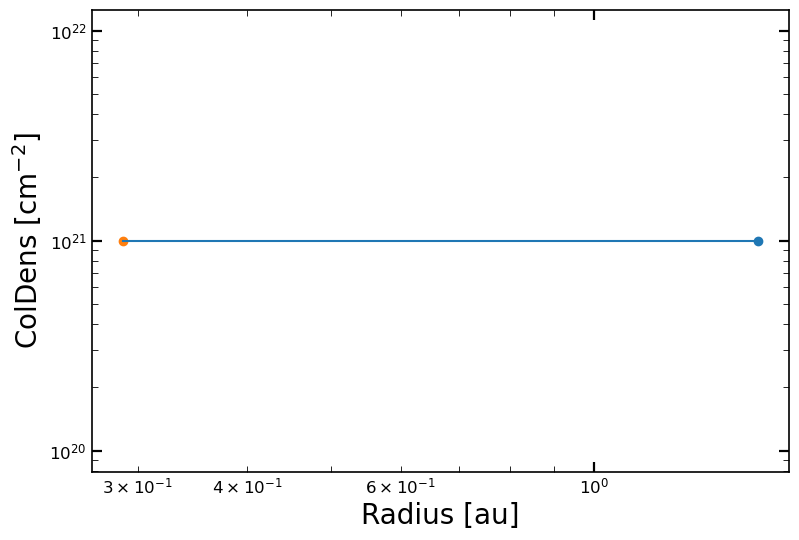

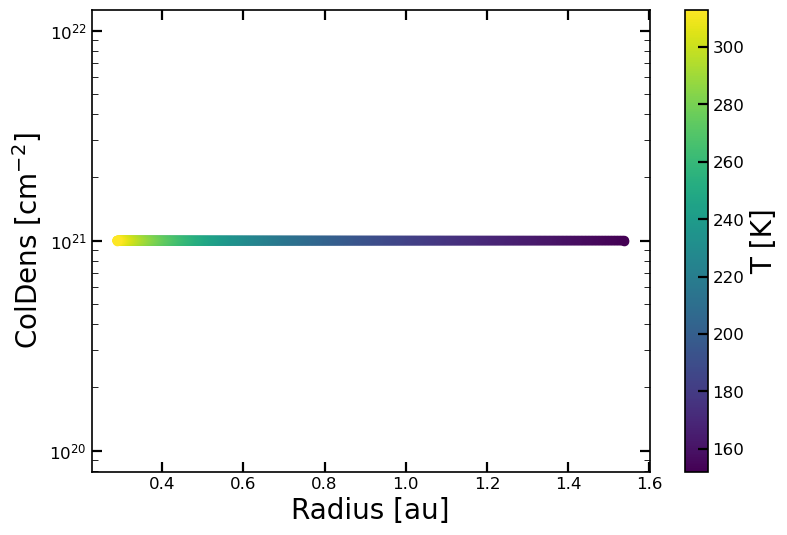

{'CO2_H': {'radius_eff': 9.58344452593727,
  'tmin,tmax': [152.11172571184736, 312.99090070168927],
  'cmin,cmax': [1e+21, 1e+21],
  'rmin,rmax': [1.5385881607832386, 0.2888524299456441]}}

In [223]:
mod.extract_emission_quantities(low_contribution=0.15,high_contribution=0.85,debug=True)

-----------
CO2_H
ColDens_tmin 82.9
ColDens_slope 0.0
logColDens_min 21.0
inner_part_temp [100. 110. 120. 130. 140. 150. 160. 170. 180. 190. 200. 210. 220. 230.
 240. 250. 260. 270. 280. 290. 300. 310. 320. 330. 340. 350. 360. 370.
 380. 390. 400. 410. 420. 430. 440. 450. 460. 470. 480. 490. 500. 510.
 520. 530. 540. 550. 560. 570. 580. 590. 600. 610. 620. 630. 640. 650.
 660. 670. 680. 690. 700. 710. 720. 730. 740. 750. 760. 770. 780. 790.
 800. 810. 820. 830. 840. 850. 860. 870. 880. 890.]
inner_part [6.68421671e-19 1.07654237e-18 1.55005750e-18 2.05213000e-18
 2.55326789e-18 3.02935183e-18 3.46071180e-18 3.83527755e-18
 4.14771159e-18 4.39748283e-18 4.58647166e-18 4.71902112e-18
 4.80036122e-18 4.83576894e-18 4.83147723e-18 4.79414318e-18
 4.72974754e-18 4.64326976e-18 4.53897386e-18 4.42060194e-18
 4.29138656e-18 4.15418263e-18 4.01144239e-18 3.86528707e-18
 3.71757995e-18 3.56993085e-18 3.42370852e-18 3.28001802e-18
 3.13966759e-18 3.00326333e-18 2.87119755e-18 2.74375672e-18
 2.6

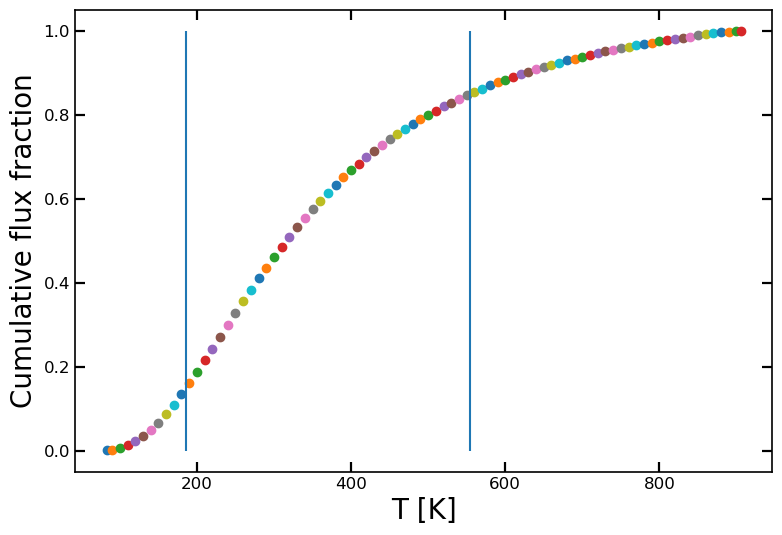

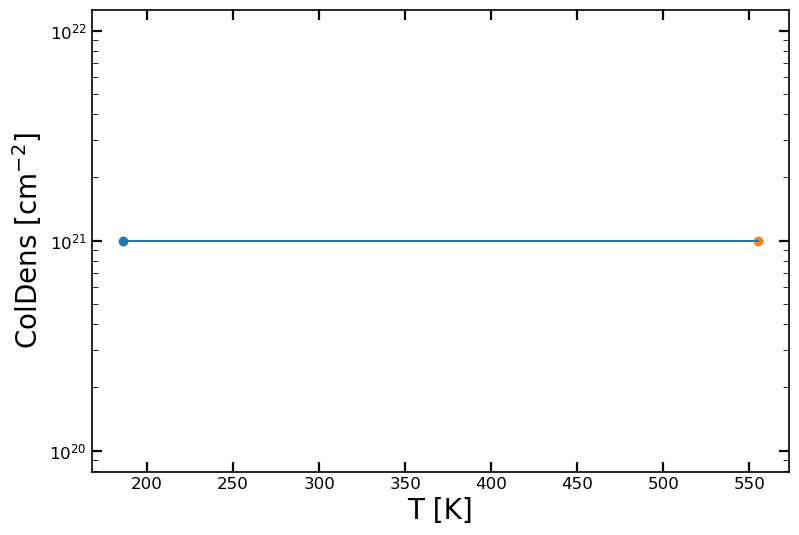

New effectiv radius: 6.823639852433702


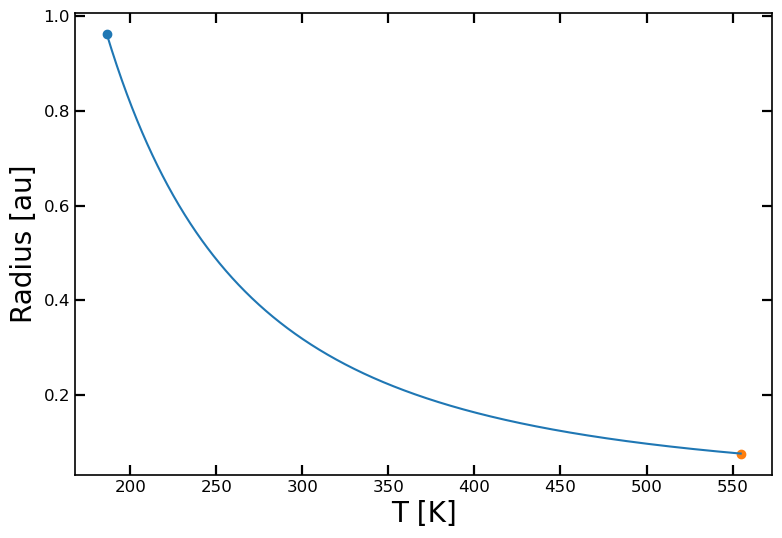

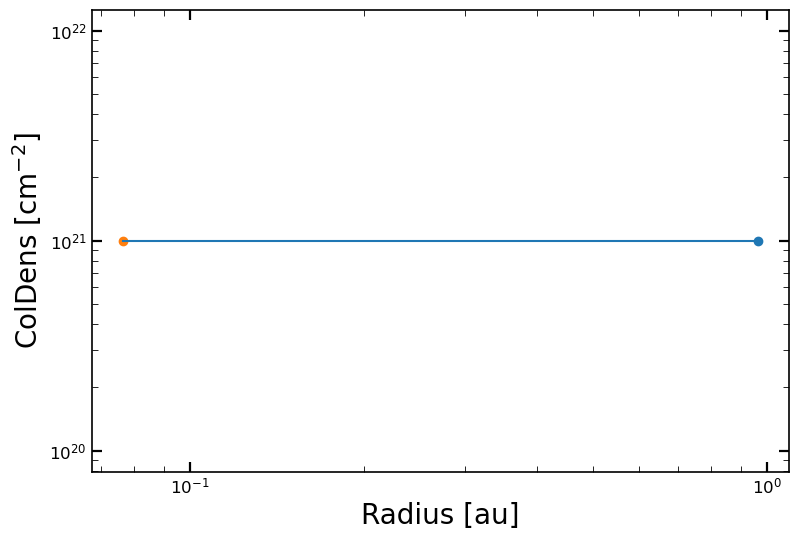

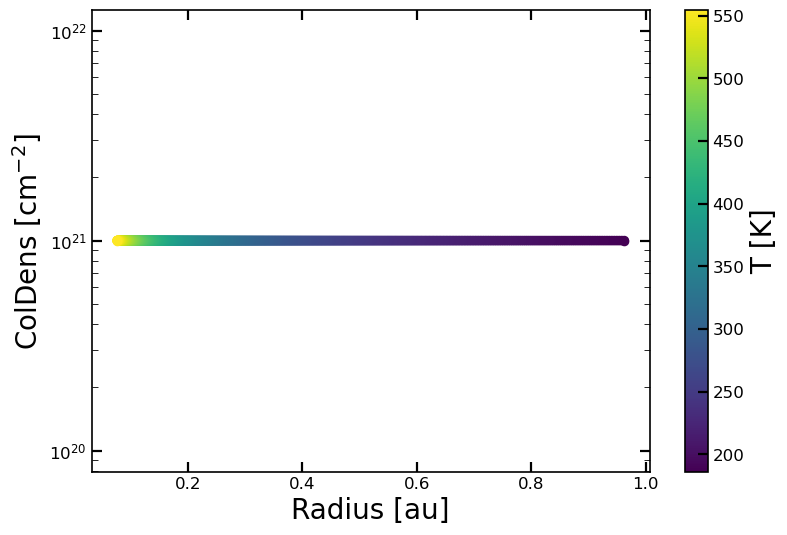

{'CO2_H': {'radius_eff': 6.823639852433702,
  'tmin,tmax': [186.21117257118473, 554.7444872489721],
  'cmin,cmax': [1e+21, 1e+21],
  'rmin,rmax': [0.9626895217102905, 0.07664181444028845]}}

In [233]:
mod.extract_emission_quantities(debug=True)

--------------
Slab of CO2_H
14.089905111439398 0.020316735725666824
Slope 0.020316735725666824
respective cols [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.   

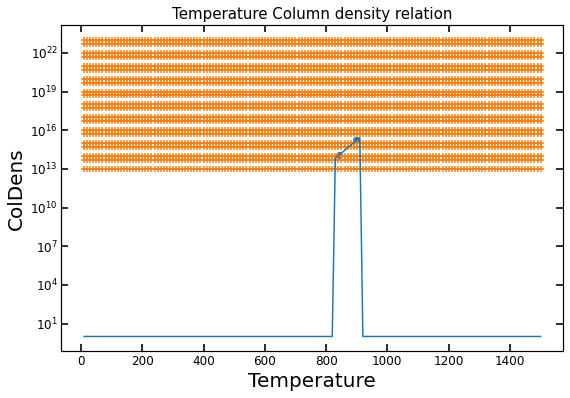

82 [1, 2]
Dens, dens in array 65407745377503.234 [5.e+13 1.e+14]
83 [2, 3]
Dens, dens in array 104423089052350.1 [1.e+14 5.e+14]
84 [2, 3]
Dens, dens in array 166710860683258.62 [1.e+14 5.e+14]
85 [2, 3]
Dens, dens in array 266152929605633.9 [1.e+14 5.e+14]
86 [2, 3]
Dens, dens in array 424911620318776.5 [1.e+14 5.e+14]
87 [3, 4]
Dens, dens in array 678368956334442.0 [5.e+14 1.e+15]
88 [4, 5]
Dens, dens in array 1083012134554105.9 [1.e+15 5.e+15]
89 [4, 5]
Dens, dens in array 1729022639728782.2 [1.e+15 5.e+15]
90 [4, 5]
Dens, dens in array 2760374693239733.5 [1.e+15 5.e+15]
Factors for lower edge interpolation:
Delta 4000000000000000.0
A, fact a/delta 9.662703106120301e-14 0.612625
B, fact b/delta 9.627718992772138e-14 0.329875
C, fact c/delta 4.828737112850664e-13 0.037375
D, fact d/delta 4.811329093991448e-13 0.020125
Sum/ delta 1.0
Factors for lower edge interpolation:
Delta 4e+16
A, fact a/delta 9.448894746469911e-13 0.08375
B, fact b/delta 9.400848113893944e-13 0.75375
C, fact c/d

In [50]:
mod.set_emission_lines(debug=True)

In [26]:
tot_flux_1=mod.tot_flux

In [128]:
tot_flux10=mod.tot_flux


In [514]:
tot_flux_10=mod.tot_flux
%timeit mod.set_surface(one_output=False,new_surface=True,small_window=False,timeit=False)

485 µs ± 1.47 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [410]:
tot_flux_1=mod.tot_flux
%timeit mod.set_surface(one_output=False,new_surface=True,small_window=False,timeit=False)

203 ms ± 573 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


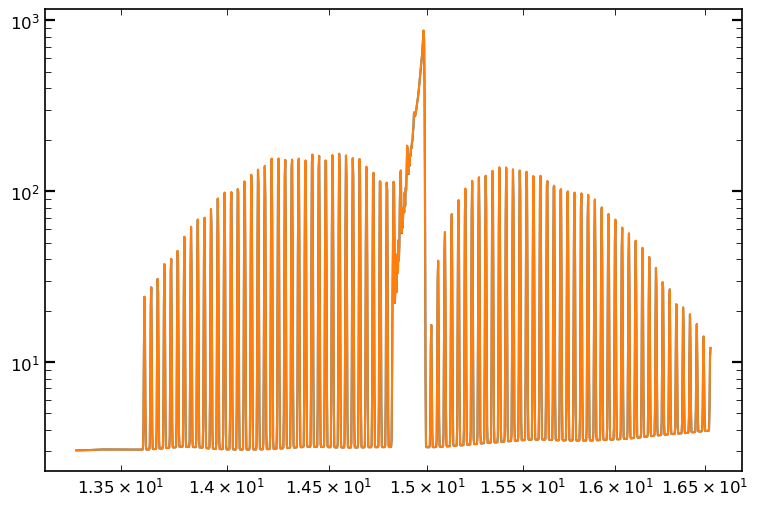

In [129]:
plt.plot(mod.xnew,tot_flux_1)
plt.plot(mod.xnew,tot_flux10)
plt.xscale('log')
plt.yscale('log')
plt.show()

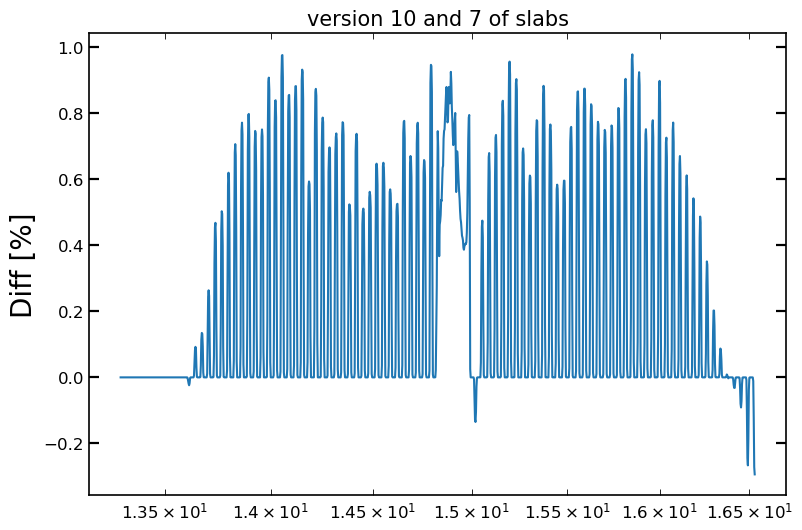

In [130]:
plt.plot(mod.xnew,(tot_flux10-tot_flux_1)/tot_flux_1*100)
plt.xscale('log')
plt.ylabel('Diff [%]')
plt.title('version 10 and 7 of slabs')
#plt.savefig('./diff_slab_10_and_7.png')
plt.show()

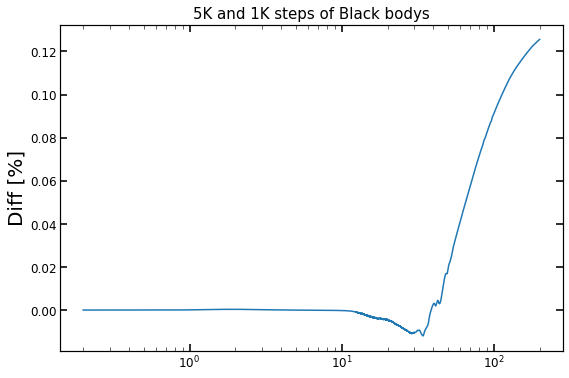

In [435]:
plt.plot(mod.xnew,(tot_flux_10-tot_flux_1)/tot_flux_1*100)
plt.xscale('log')
plt.ylabel('Diff [%]')
plt.title('5K and 1K steps of Black bodys')
plt.savefig('./diff_black_body_interp_5k.png')
plt.show()

In [42]:
%timeit mod.set_surface(one_output=False,new_surface=True,small_window=False,timeit=False)

578 ms ± 2.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [138]:
%timeit mod.set_surface(one_output=False,new_surface=True,small_window=False,timeit=False)

281 ms ± 2.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


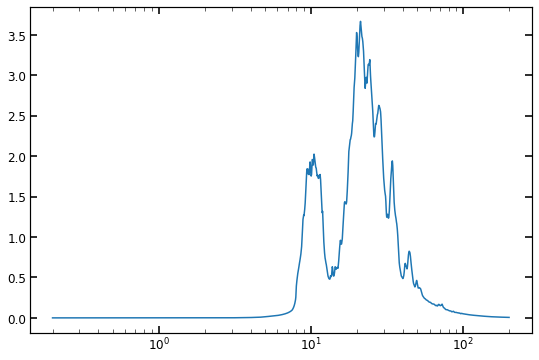

In [211]:
mod.set_surface()
plt.plot(mod.xnew,mod.surface_flux_tot)
plt.xscale('log')

In [290]:
var_dict['tmax_mp']=500

Midplane
Idx_min, t_min 8 90
Idx_max, t_max 10 110
Shapes must match (0, 204289) (0,)
Upper edge 1.0228598734954628e-14
Lower edge 8.771973920453246e-15
Upper bb in 1.0141026898162446e-14
Lower bb in 8.803437548781446e-15


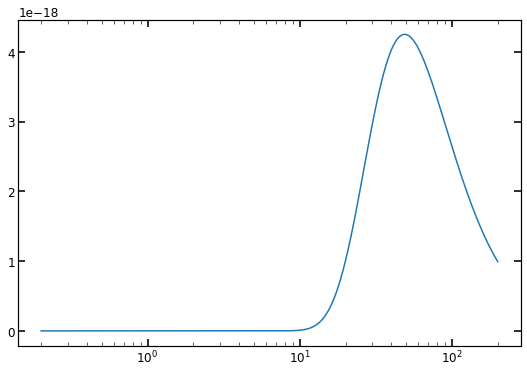

In [284]:

plt.plot(mod.xnew,mod.set_midplane(debug=True))
plt.xscale('log')

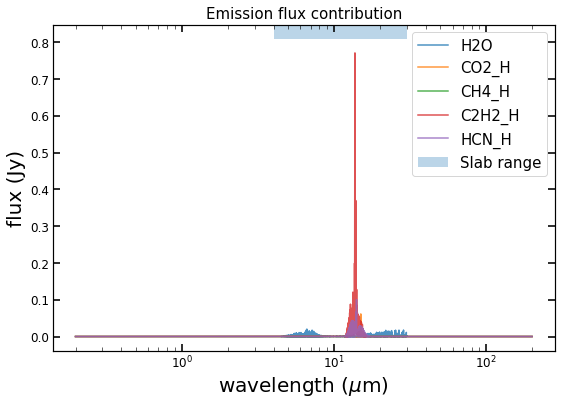

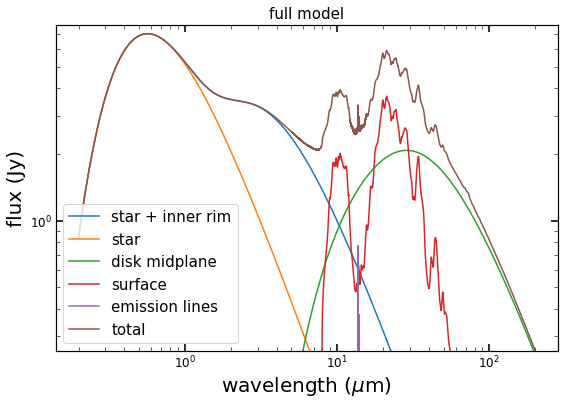

In [323]:
mod.plot() #this plots the final model


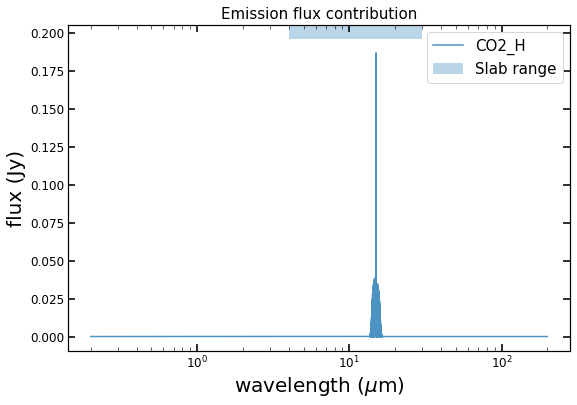

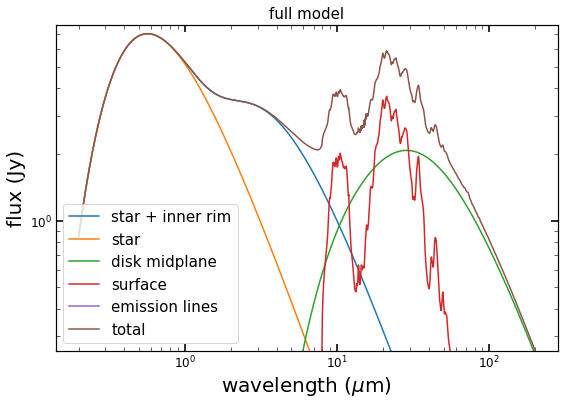

In [314]:
mod.plot() #this plots the final model


In [90]:
mod.bb_temp_list

array([   1,    2,    3, ..., 9997, 9998, 9999])

### step three

running the model with .run_model
the aguments are:
- variables: which should be the variable dict (now all parameters are used)
- dust_species: which should be the abundance_dict (now also the scale factors are used)
- output_all: bool, default is False is the way to compute the total output

Init 5.7220458984375e-06
Star 0.0003292560577392578
Inner rim 0.0004229545593261719
Midplane 0.0010128021240234375
Surface 0.0003533363342285156
Emission 0.0006496906280517578
Summing up 1.8596649169921875e-05


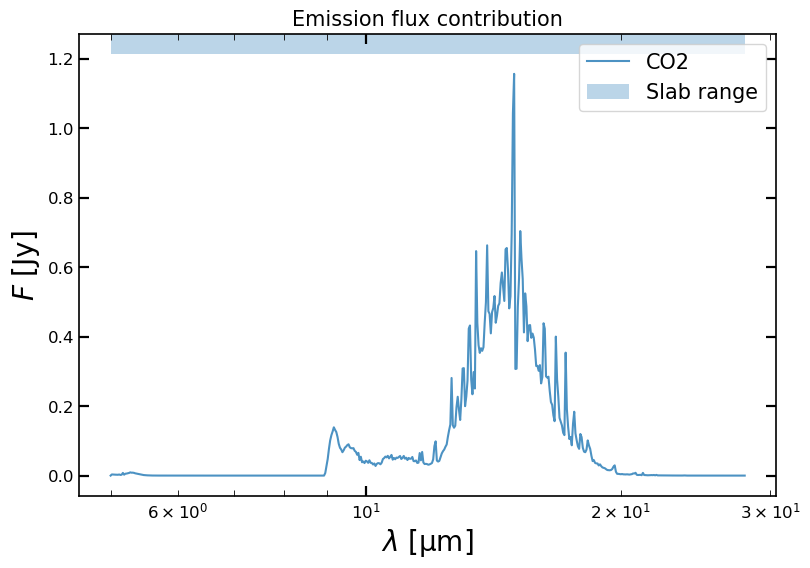

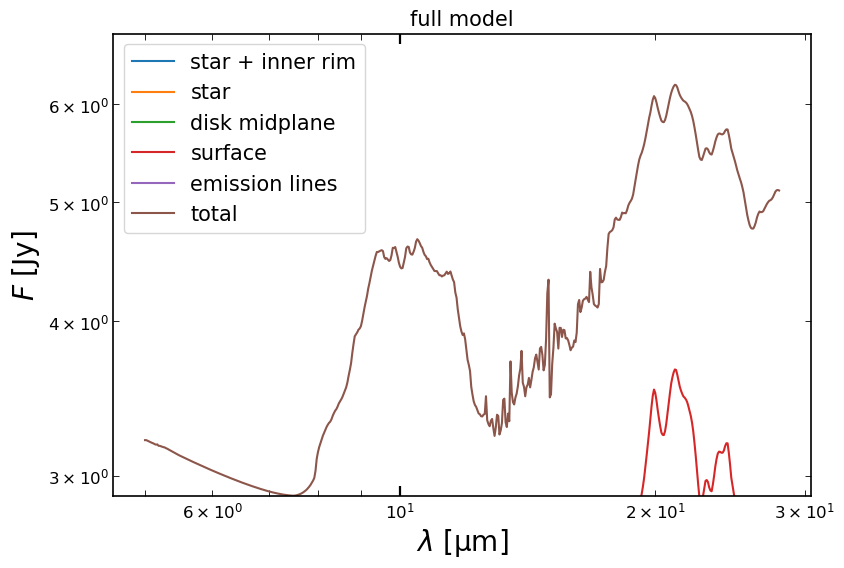

In [49]:
tot_flux_test=mod.run_model(variables=var_dict,dust_species=abundance_dict,slab_dict=slab_dict,output_all=False,timeit=True)
mod.plot() #this plots the final model


In [12]:
len(mod.xnew)

97696

here you can check how long the model needs to run

In [12]:
%timeit mod.run_model(variables=var_dict,dust_species=abundance_dict,slab_dict=slab_dict,output_all=False)

4.67 s ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
%timeit mod.run_model(variables=var_dict,dust_species=abundance_dict,slab_dict=slab_dict,output_all=False)

15.5 ms ± 30 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%timeit mod.run_model(variables=var_dict,dust_species=abundance_dict,slab_dict=slab_dict,output_all=True)

# retrieving linear parameters

In this section I will show how the linear parameters are retrieved.
The idea is to set up a new model with var_dict_new and abundance_dict_new.
Note that the scale factors are left empty.



In [51]:
# this dictonary has a single temperature for the inner rim
var_dict_new={'tstar':9000,
         'rstar':2.5,
         'distance':140,
         't_rim':1500.6,
         'tmin_s':50.3,
         'tmax_s':1000.1,
         'tmin_mp':99.3,
         'tmax_mp':110.4,
         'sc_ir':70,
         'sc_mid':1e12,
         'q_mid':-0.6,
         'q_thin':-0.55,
         'q_emis':-0.55,
         'bb_star':True,
         'incl':0.0}




abundance_dict_new={#'Q_Am_Mgolivine_Jae_DHS_f0.7_rv0.1.dat':None,
                #'Q_Am_Mgolivine_Jae_DHS_f0.7_rv1.5.dat':None,
                'Q_Am_Mgolivine_Jae_DHS_f0.7_rv2.0.dat':None,
                #'Q_Am_Mgolivine_Jae_DHS_f0.7_rv5.0.dat':None,
                
                #'Q_Am_Mgpyroxene_Dor_DHS_f0.7_rv0.1.dat':None,
                #'Q_Am_Mgpyroxene_Dor_DHS_f0.7_rv1.5.dat':None,
                'Q_Am_Mgpyroxene_Dor_DHS_f0.7_rv2.0.dat':None,
                #'Q_Am_Mgpyroxene_Dor_DHS_f0.7_rv5.0.dat':None,
                
                #'Q_Am_Silica_HM_DHS_f0.7_rv0.1.dat':None,
                #'Q_Am_Silica_HM_DHS_f0.7_rv1.5.dat':None,
                'Q_Am_Silica_HM_DHS_f0.7_rv2.0.dat':None,
                #'Q_Am_Silica_HM_DHS_f0.7_rv5.0.dat':None,

                #'Q_En_Jaeger_DHS_f1.0_rv0.1.dat':None,
                #'Q_En_Jaeger_DHS_f1.0_rv1.5.dat':None,
                'Q_En_Jaeger_DHS_f1.0_rv2.0.dat':None,
                #'Q_En_Jaeger_DHS_f1.0_rv5.0.dat':None,



                #'Q_Fo_Zeidler_DHS_f1.0_rv0.1.dat':None,
                #'Q_Fo_Zeidler_DHS_f1.0_rv1.5.dat':None,
                'Q_Fo_Zeidler_DHS_f1.0_rv2.0.dat':None}#,
                #'Q_Fo_Zeidler_DHS_f1.0_rv5.0.dat':None}

# this dictonary has a single temperature for the inner rim
var_dict_new={'tstar':9000,
         'rstar':2.5,
         'distance':140,
         't_rim':1500.6,
         'tmin_s':50.3,
         'tmax_s':1000.1,
         'tmin_mp':99.3,
         'tmax_mp':1100.4,
         'sc_ir':70,
         'sc_mid':1e12,
         'q_mid':-0.6,
         'q_thin':-0.55,
         'q_emis':-0.55,
         'bb_star':True,
         'incl':0.0}


slab_dict_new={
           'H2O':{'ColDens':5e17,
                    'tmax':921.1,
                    'tmin':221,
                     'radius':0.3
                    },
    
            'CO2_H':{'ColDens':1e18,
                    'tmax':500,
                    'tmin':200,
                     'radius':0.3
                    },
           'CH4_H':{'ColDens':1e17,
                    'tmax':900,
                    'tmin':400,
                     'radius':0.3
                    },
            'C2H2_H':{'ColDens':1e18,
                    'tmax':600,
                    'tmin':500,
                     'radius':0.2},
            'CH4_H':{'ColDens':1e17,
                    'tmax':900,
                    'tmin':400,
                     'radius':0.3
                    },
           'HCN_H':{'ColDens':1e17,
                    'tmax':900,
                    'tmin':800,
                     'radius':0.3
                    },

          }

In [52]:
old_version=False
var_dict_new['q_emis']=mod.variables['exp_emission']
var_dict_new['sc_ir']=mod.variables['sc_ir']*np.pi*((mod.rsun*mod.variables['rstar'])**2)/((mod.variables['distance']*mod.parsec)**2)
var_dict_new['sc_mid']=mod.variables['sc_mid']*np.pi*((mod.rsun*mod.variables['rstar'])**2)/((mod.variables['distance']*mod.parsec)**2)


I setup the model the same way as previously
with continuum_model and read_data

In [255]:

mod2=complete_model()

mod2.read_data(variables=var_dict_new,dust_species=abundance_dict_new,slab_dict=slab_dict_new,debug=False,slab_prefix='7_')
print(mod2)


NameError: name 'var_dict_new' is not defined

In [308]:
mod2.set_emission_lines(scaled=False)

In [312]:
slab_dict={'C2H4_I': {'ColDens': 2.9535976811656996e+18, 'temis': 1477.8616577386856}, 'CH4': {'ColDens_tmin': 7151459348604565.0, 'ColDens_tmax': 4643330385905455.0, 'tmax': 1104.2571529746056, 'tmin': 851.0829091072083}, 'C2H6_I': {'ColDens': 146931641565767.5, 'temis': 33.32335203886032}, 'HCN': {'ColDens': 3.0093194972266476e+18, 'temis': 440.795361995697}, 'C2H2_I': {'ColDens_tmin': 1.740984469823774e+21, 'ColDens_tmax': 3.2267342142260986e+19, 'tmax': 289.7101655602455, 'tmin': 105.22315949201584}, 'C6H6': {'ColDens': 1.245044637861188e+16, 'temis': 207.54453837871552}, 'CO2_II': {'ColDens': 3.1976151145416532e+16, 'temis': 321.83929085731506}, 'HC3N': {'ColDens': 1.8650621227273134e+19, 'temis': 512.3760312795639}}

In [310]:
for key in mod2.emission_flux_individual:
    print(np.min(mod2.emission_flux_individual[key]),np.max(mod2.emission_flux_individual[key]))

2.3558640151554084e-11 0.00035735088342723516
0.0 13.412956127760504
0.0 3.9248168632851564e-10
0.0 8.725034205474369
-0.17426713249473752 0.0
0.0 0.06558306933740823
0.0 21.280938073591585
0.0 0.11133415325897185


In [313]:

mod2=complete_model()

#wavelength=10**np.linspace(np.log10(4),np.log10(30),5000)
print(len(wavelength))
mod2.read_data(variables=var_dict,dust_species={},slab_dict=slab_dict,wavelength_points=wavelength,
              slab_prefix='10_',save_binned_data=True,load_binned_data=True,slab_only_mode=True)
tot_flux_new=mod2.run_fitted_to_obs_slab(variables=var_dict,slab_dict=slab_dict,
                                    flux_obs=flux_obs,lam_obs=lam_obs,interp=False,debug=False)




5410
Folder to be searched for pre-binned data:
['./LineData//binned_data/0', './LineData//binned_data/1', './LineData//binned_data/10', './LineData//binned_data/11', './LineData//binned_data/12', './LineData//binned_data/13', './LineData//binned_data/14', './LineData//binned_data/15', './LineData//binned_data/16', './LineData//binned_data/17', './LineData//binned_data/18', './LineData//binned_data/19', './LineData//binned_data/2', './LineData//binned_data/20', './LineData//binned_data/21', './LineData//binned_data/22', './LineData//binned_data/23', './LineData//binned_data/24', './LineData//binned_data/25', './LineData//binned_data/26', './LineData//binned_data/27', './LineData//binned_data/28', './LineData//binned_data/29', './LineData//binned_data/3', './LineData//binned_data/30', './LineData//binned_data/31', './LineData//binned_data/32', './LineData//binned_data/33', './LineData//binned_data/34', './LineData//binned_data/35', './LineData//binned_data/36', './LineData//binned_data/

## fitting

Here is where the magic happens..

with run_fitted_to_obs the model is run again but the linear parameters are retrieved.

### how it works
run_fitted_to_obs executes run_model(output_all=True) which returns all the components (star, rim, midplane, every dust species) seperatly.

These components (without the star) are then put into an array

Then numpy uses least square fitting to fit the scale factors of every component.
The output it is fitted agained is the observation minus the stellar component (because the star has no scale factor)

The scale factors are saved, every component scaled by it, and all the components summed up

### input arguments

- variables: dictionary with all the variables (scale factors are not needed)
- dust_species: dictionary with all the dust species (scale factors are not needed)
- flux_obs: flux of the observation
- lam_obs: wavelength points of the observation (should be same as wavelength_points in read_data)
- interp: if lam_obs != wavelength_points this option can be used to interpolate the model
- debug: printing output


In [314]:
tot_flux_new=mod2.run_fitted_to_obs(variables=var_dict_new,dust_species=abundance_dict_new,slab_dict=slab_dict_new,
                                    flux_obs=mod.tot_flux,lam_obs=mod.xnew,interp=False,debug=False)




NameError: name 'var_dict_new' is not defined

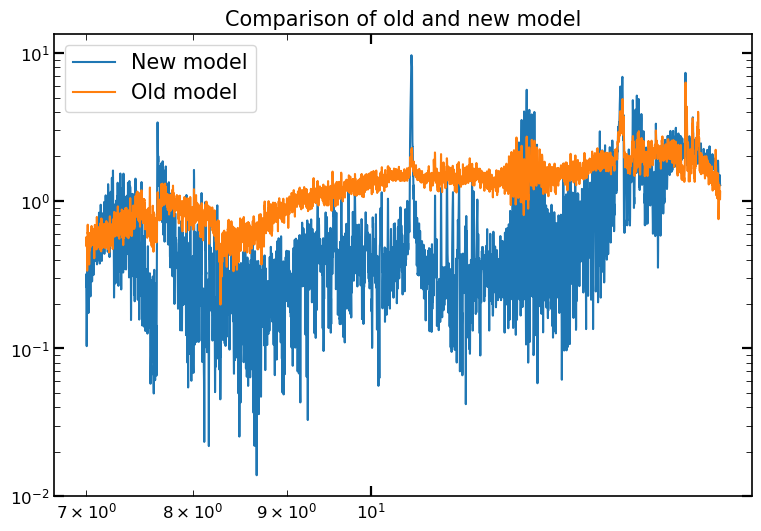

In [315]:
plt.title('Comparison of old and new model')
plt.loglog(mod2.xnew,tot_flux_new,label='New model')
plt.loglog(lam_obs,flux_obs,label='Old model')
plt.legend()
plt.show()


the differences between the old and new model are only extremly small

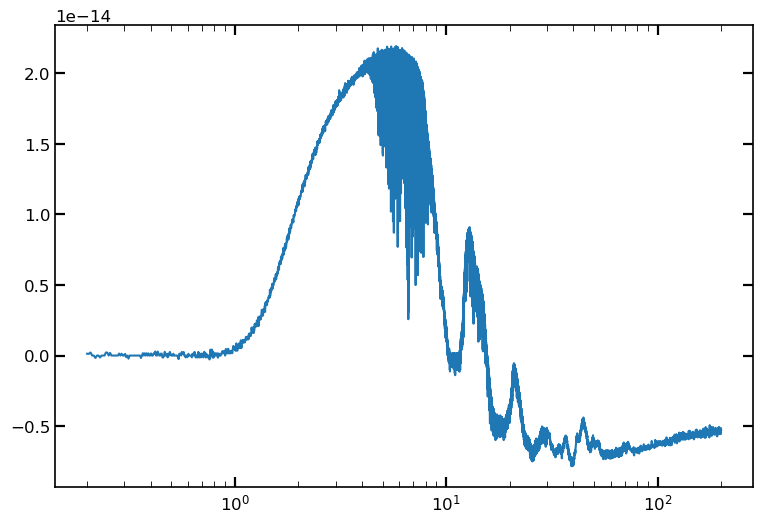

In [28]:
plt.plot(mod.xnew,(mod.tot_flux-tot_flux_new)/tot_flux_new,label='Difference')
plt.xscale('log')
plt.show()

you can also check out the retrieved scale factors.
They should be the same as the ones that you put in.

In [29]:
print('Determined scale factors')
print(mod2.scaleparas)

Determined scale factors
[7.0e+01 1.0e+12 1.0e+12 1.0e+12 1.0e+12 1.0e+12 1.0e+12 2.5e-01]


Let's check out how long it takes to run a model that retrieves the scale parameters

The time depends again on your machine and the complexity (number of dust species) of the model

In [20]:
%timeit mod2.run_fitted_to_obs(variables=var_dict,dust_species=abundance_dict,slab_dict=slab_dict_new,flux_obs=mod.tot_flux,lam_obs=mod.xnew,interp=False,debug=False)


631 ms ± 5.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### simulating observations

The next step simulates an observation, based on the model that we just calculated.

I'll use this model in the multinest notebook to fit the model

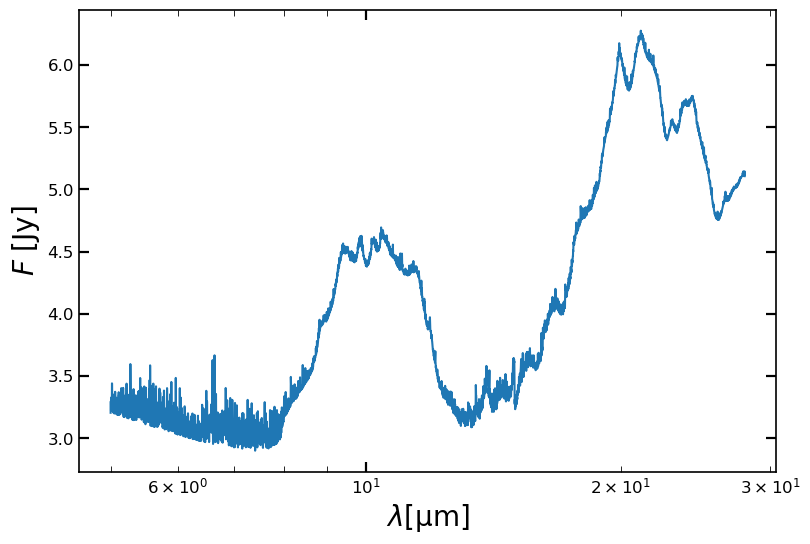

In [131]:
idx_1=np.where(mod.xnew>=4)
select_wave=mod.xnew[idx_1]
select_flux=mod.tot_flux[idx_1]

idx_2=np.where(select_wave<=30)
select_wave=select_wave[idx_2]
select_flux=select_flux[idx_2]
plt.plot(select_wave,select_flux)
plt.xscale('log')
plt.ylabel(r'$F$ [Jy]')

plt.xlabel(r'$\lambda [\rm \mu m]$')

plt.show()
np.save('test_wave',select_wave)
np.save('test_flux',select_flux)

In [132]:
#writing file with the parameters of the mock observation

string='Parameters used to create test_flux.npy \n \n'
for key in var_dict:
    string+=key+': '+str(var_dict[key])+' \n'


###
#Set if the Q-curves where transformed
###
trans_q=False
###
string+='\n'
string+='Transformed Q-cruves: '+str(trans_q)+' \n'
sum_abund=0
for key in abundance_dict:
    string+=f'{key}: %4.4e \n'%abundance_dict[key]
    sum_abund+=abundance_dict[key]
if trans_q:
    string+='Mass fractions: \n'

    for key in abundance_dict:
        frac=abundance_dict[key]/sum_abund
        string+=f'{key}: %4.4f \n'%frac

for key in slab_dict:
    for key1 in slab_dict[key]:
        string+=f'{key}/{key1}: %4.4e \n'%slab_dict[key][key1]

        
        
        
print(string)

with open('Mock_parameters.txt','w') as f:
    f.write(string)

Parameters used to create test_flux.npy 
 
tstar: 9000 
rstar: 2.5 
distance: 140 
t_rim: 1500.6 
tmin_s: 50.3 
tmax_s: 1000.1 
tmin_mp: 99.3 
tmax_mp: 1100.4 
sc_ir: 3.5711422016510875e-17 
sc_mid: 5.10163171664441e-07 
q_mid: -0.6 
q_thin: -0.55 
q_emis: -3.0 
bb_star: True 
exp_midplane: -4.333333333333334 
exp_surface: -4.636363636363636 
exp_emission: -3.0 

Transformed Q-cruves: False 
Q_Am_Mgolivine_Jae_DHS_f0.7_rv2.0.dat: 5.1016e-07 
Q_Am_Mgpyroxene_Dor_DHS_f0.7_rv2.0.dat: 5.1016e-07 
Q_Am_Silica_HM_DHS_f0.7_rv2.0.dat: 5.1016e-07 
Q_En_Jaeger_DHS_f1.0_rv2.0.dat: 5.1016e-07 
Q_Fo_Zeidler_DHS_f1.0_rv2.0.dat: 5.1016e-07 
CO2/ColDens_tmin: 1.0000e+18 
CO2/ColDens_tmax: 1.0000e+21 
CO2/tmax: 7.0000e+02 
CO2/tmin: 6.0000e+02 
CO2/radius: 2.0000e-01 
H2O/ColDens_tmin: 5.0000e+17 
H2O/ColDens_tmax: 5.0000e+21 
H2O/tmax: 9.2110e+02 
H2O/tmin: 8.2100e+02 
H2O/radius: 2.0000e-01 
HCN/ColDens_tmin: 5.0000e+17 
HCN/ColDens_tmax: 5.0000e+19 
HCN/tmax: 9.2110e+02 
HCN/tmin: 5.2100e+02 
HCN/ra

In [22]:
#np.save('standard_wave',mod.xnew)

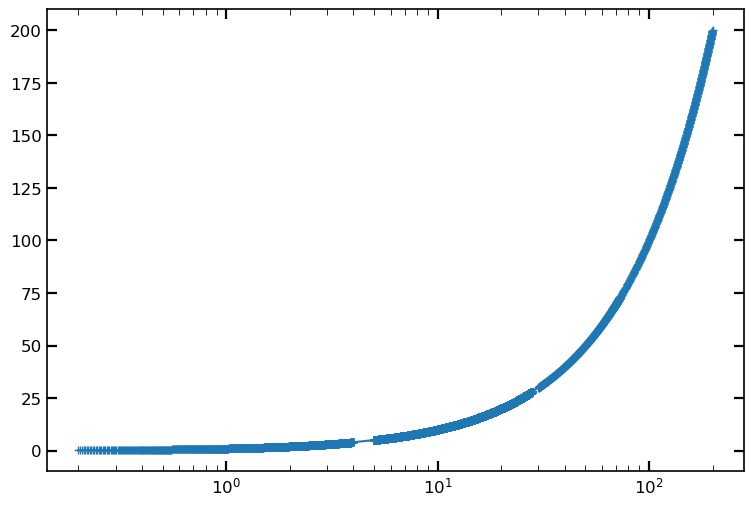

In [21]:
plt.plot(mod.xnew,mod.xnew,marker='+')
plt.xscale('log')

In [21]:
stwave=np.load('standard_wave.npy')
print(len(stwave))
print(len(mod.xnew))

175075
97696
